In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit
import math

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

In [2]:
root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data" / "raw" / "SiteA_Scans_Global_I_RGB_RHV" / "SiteA_RHV_01.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [3]:
# sort by the second to last column
pcd = pcd[pcd[:, -2].argsort()]

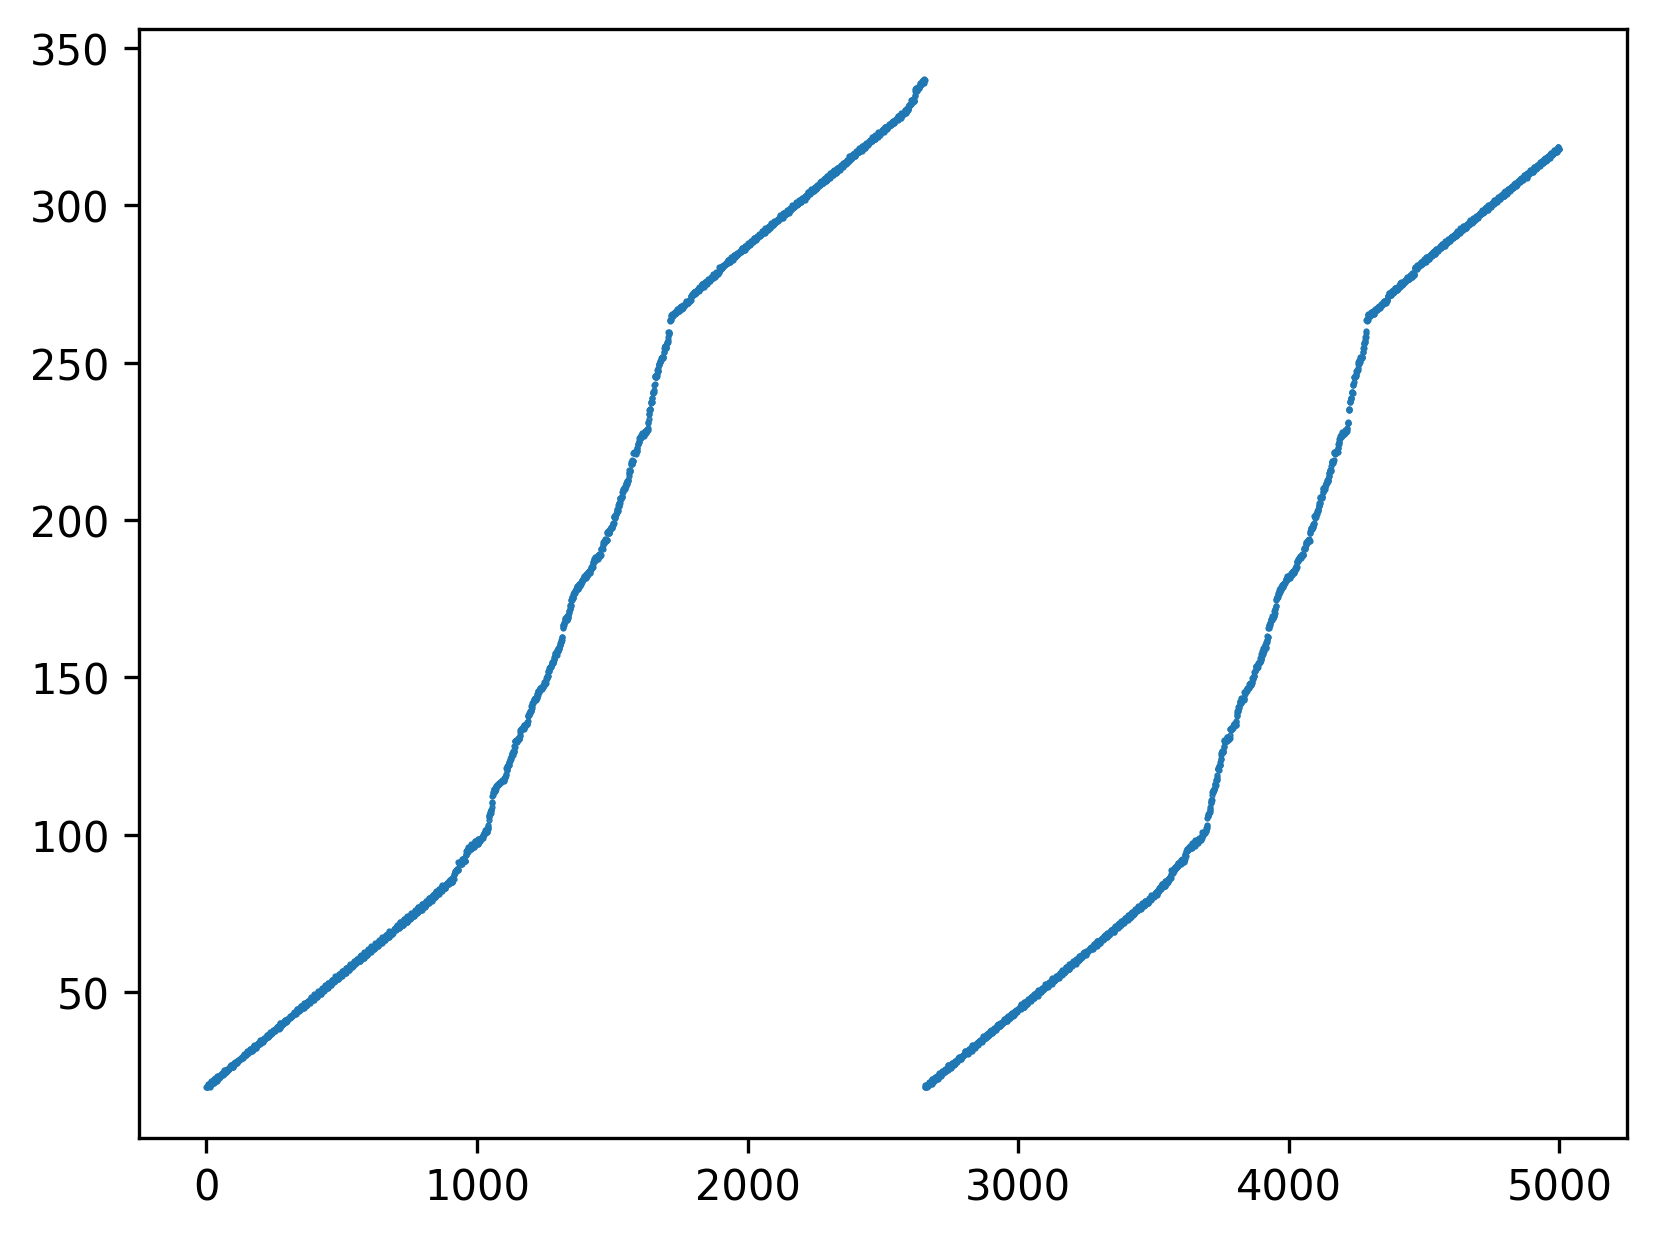

In [18]:
# plot the length of pcd[:,-2] against pcd[:,-2]
start = 0
stop = start + 5000

col = -1

plt.plot(np.arange(len(pcd[start:stop, col])), pcd[start:stop, col], "o", markersize=0.5)
plt.show()

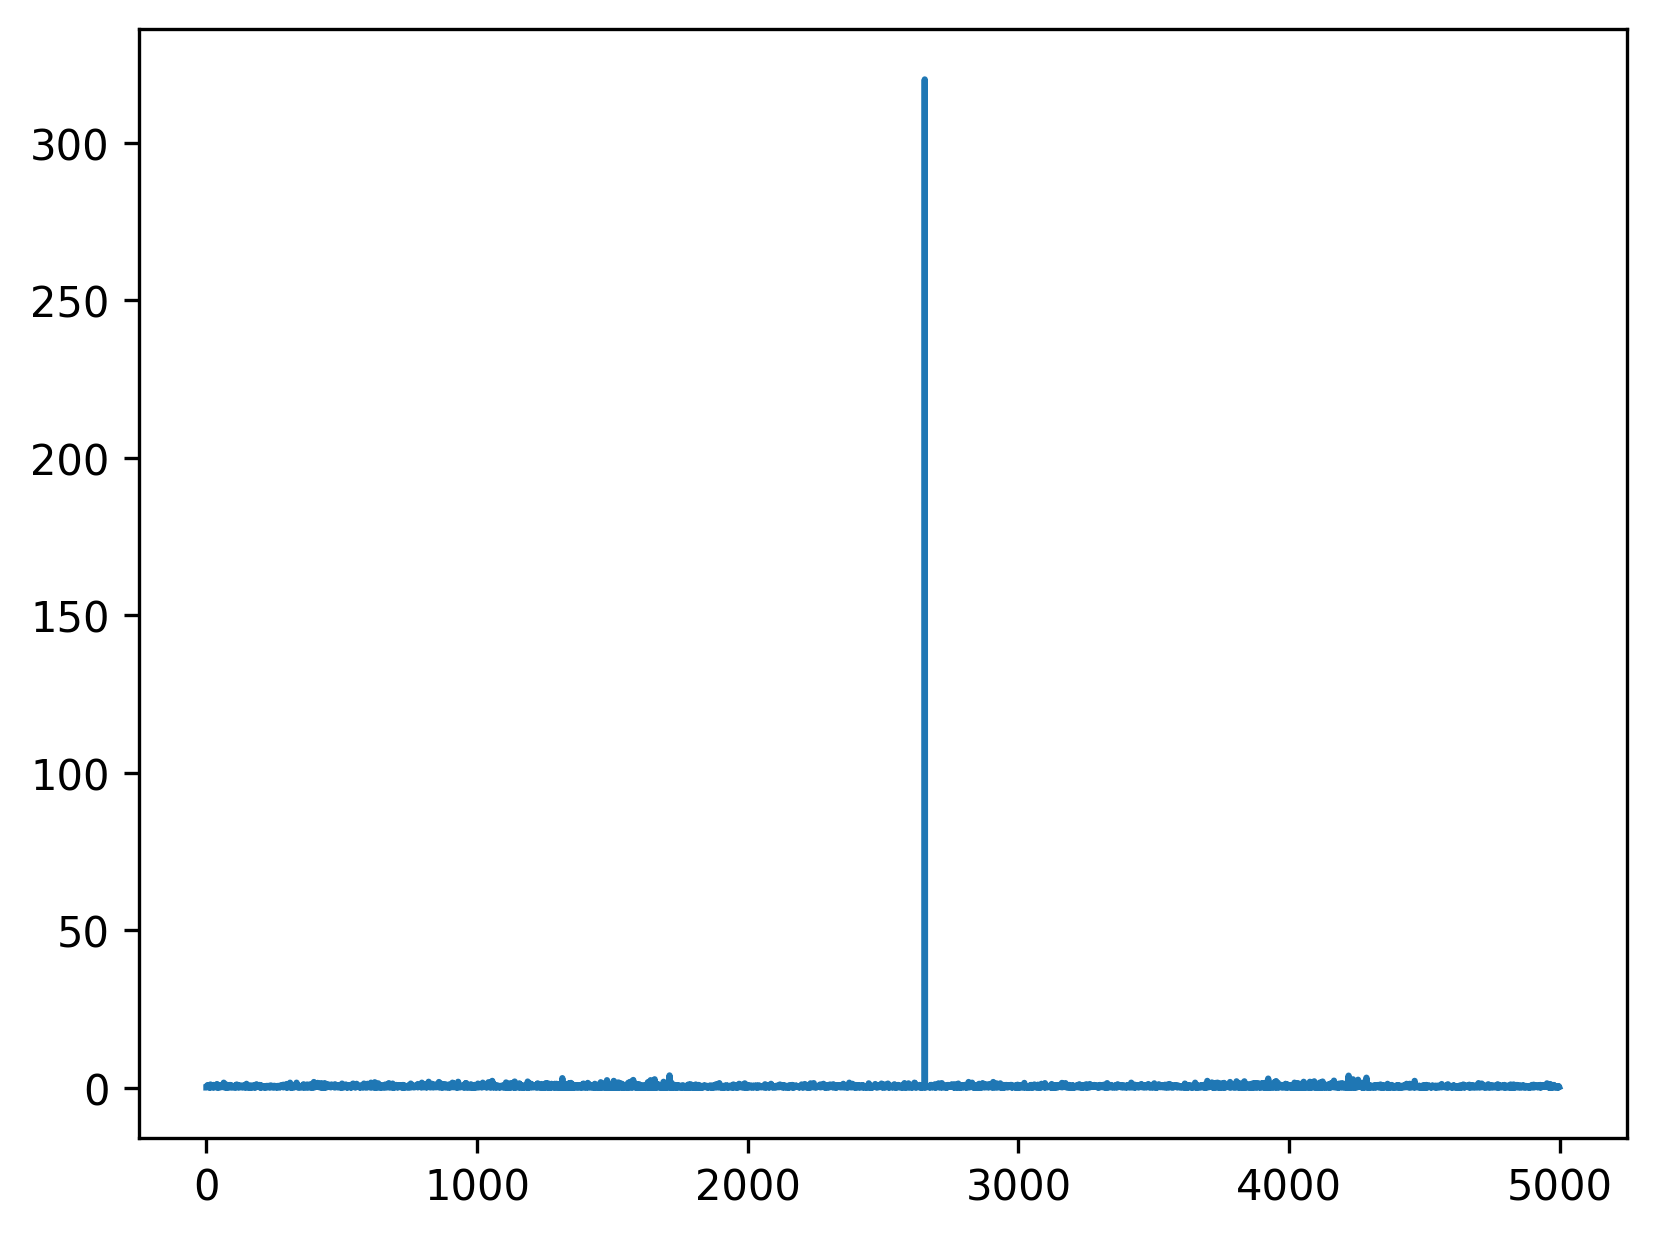

In [22]:
# calculate the difference between each point of pcd[:, -2]
start = 0
stop = start + 5000

diff = abs(np.diff(pcd[start:stop, -1]))

# plot the length against the difference
plt.plot(np.arange(len(diff)), diff, "-", markersize=0.5)
plt.show()

In [33]:
pcd = pcd[pcd[:, -2].argsort()]

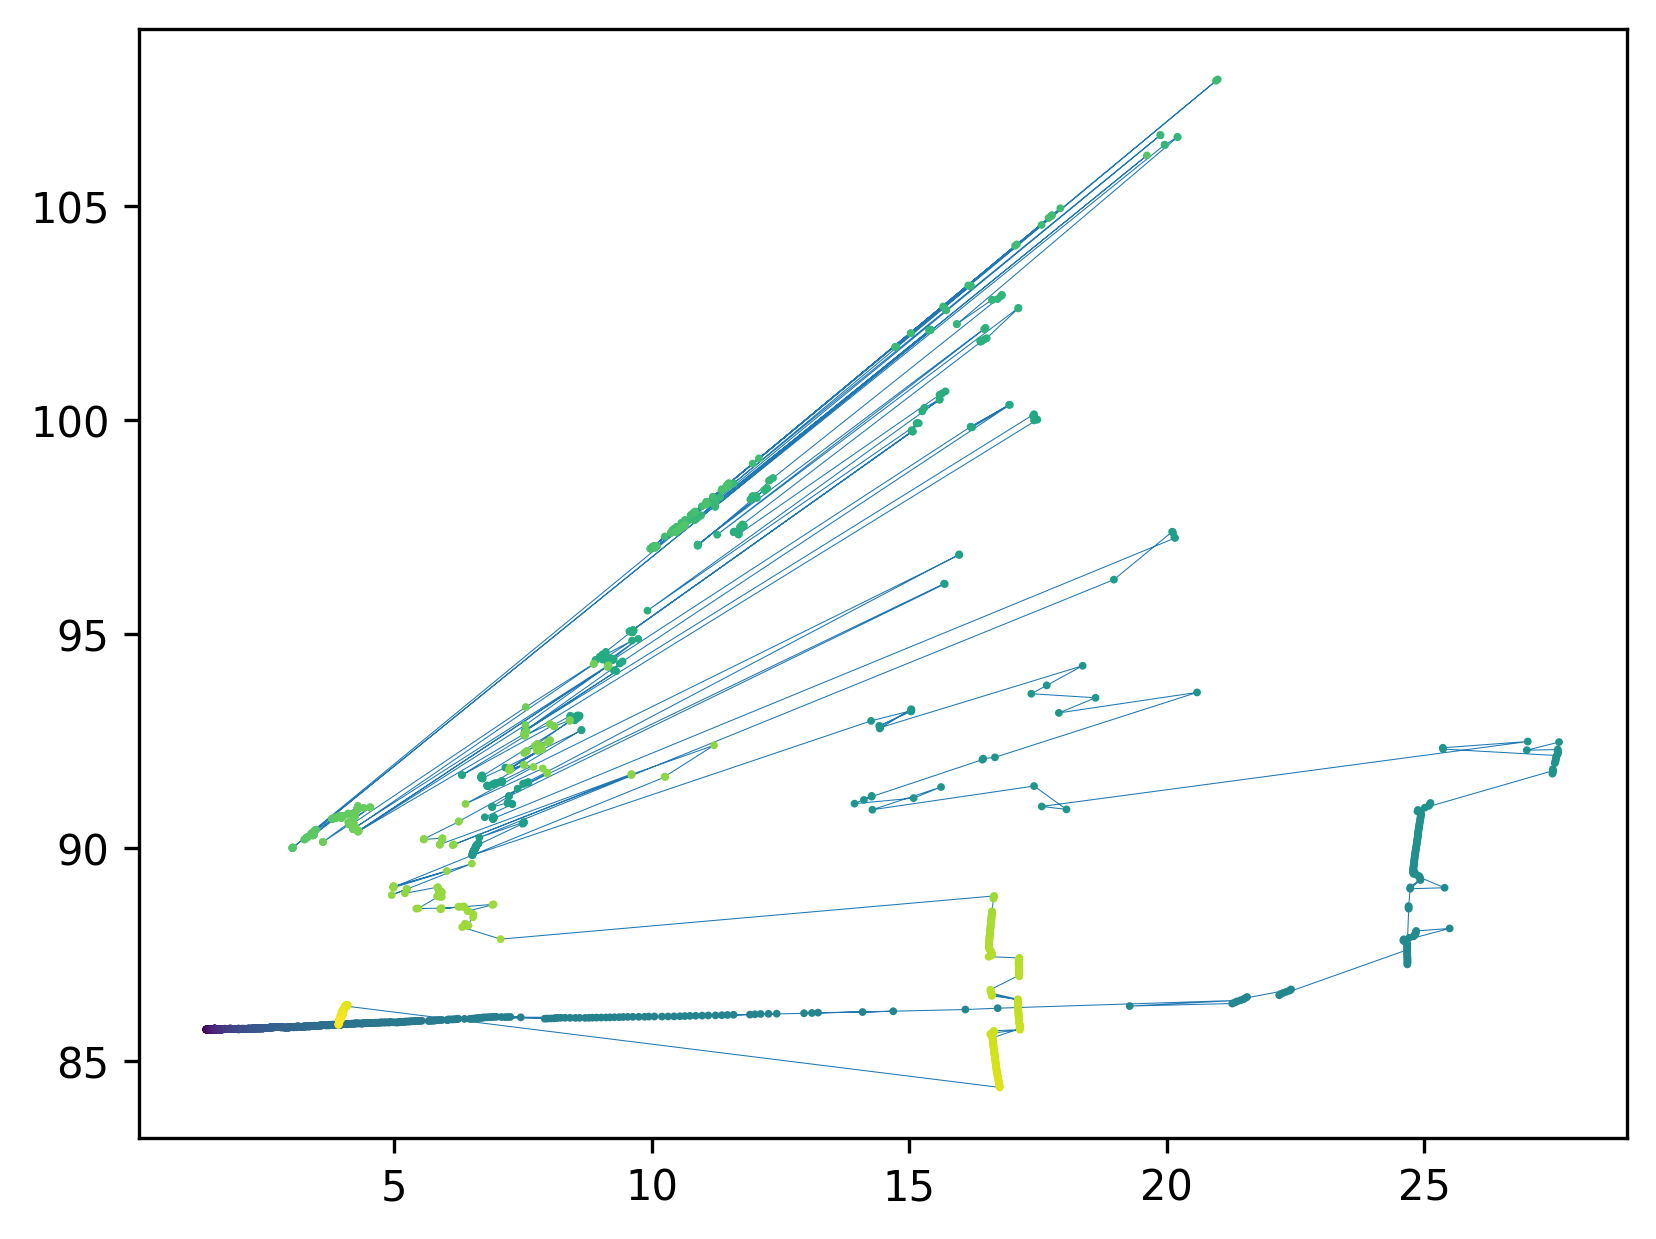

In [5]:
# plot the length of pcd[:,-3] against pcd[:,2]
start = 0
stop = start + 2000

cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, 2000))

col1 = -3
col2 = 2

plt.plot(pcd[start:stop, col1], pcd[start:stop, col2], "-", linewidth=0.25, zorder=1)

# colorize the points with a viridis colorbar and strech the colorbar to the length of the pcd such that the color of the points is proportional to the length of the pcd
plt.scatter(pcd[start:stop, col1], pcd[start:stop, col2], c=colors, s=0.75, zorder=2)

# same as points with a line    
#plt.plot(pcd[start:stop, col1], pcd[start:stop, col2], "-o", markersize=0.5)

plt.show()

In [29]:
# add a column with the np.arange of the length of the pcd
#pcd = np.hstack((pcd, np.arange(len(pcd)).reshape(-1, 1)))

pcd.shape

(6989110, 11)

In [30]:
# save the pcd as a ascii file
#np.savetxt(root_dir / "data" / "sorted" / "SiteA_Scans_Global_I_RGB_RHV" /"Scan01_sorted_H.asc", pcd, delimiter=" ", fmt="%1.4f")

In [4]:
pcd = pcd[pcd[:, -3].argsort()]

In [46]:
pcd[::10, -3].shape

(698911,)

In [111]:
# Assuming pcd is a numpy array
k = 50

tree = cKDTree(pcd[:, [-3]])

# Query the tree for the nearest neighbor of each point
distances, indices = tree.query(pcd[:, [-3]], workers=-1, k=k)

In [112]:
distances

array([[  0.    ,   0.0001,   0.0002, ...,   0.0129,   0.013 ,   0.0131],
       [  0.    ,   0.0001,   0.0001, ...,   0.0128,   0.0129,   0.013 ],
       [  0.    ,   0.    ,   0.0001, ...,   0.0127,   0.0128,   0.0129],
       ...,
       [  0.    ,  22.9552,  36.9911, ..., 156.467 , 156.514 , 156.6353],
       [  0.    ,  14.0359,  22.9552, ..., 179.4222, 179.4692, 179.5905],
       [  0.    ,  14.0359,  36.9911, ..., 193.4581, 193.5051, 193.6264]])

In [113]:
# The first column of distances and indices will be 0 and the indices to the points themselves, because each point is its own nearest neighbor. So we take the second column:
nearest_neighbor_distances = np.mean(distances[:, 1:k], axis=1)
nearest_neighbor_indices = np.mean(indices[:, 1:k], axis=1)

nearest_neighbor_distances = np.where(nearest_neighbor_distances == 0, 0.00001, nearest_neighbor_distances)
density = 1 / nearest_neighbor_distances

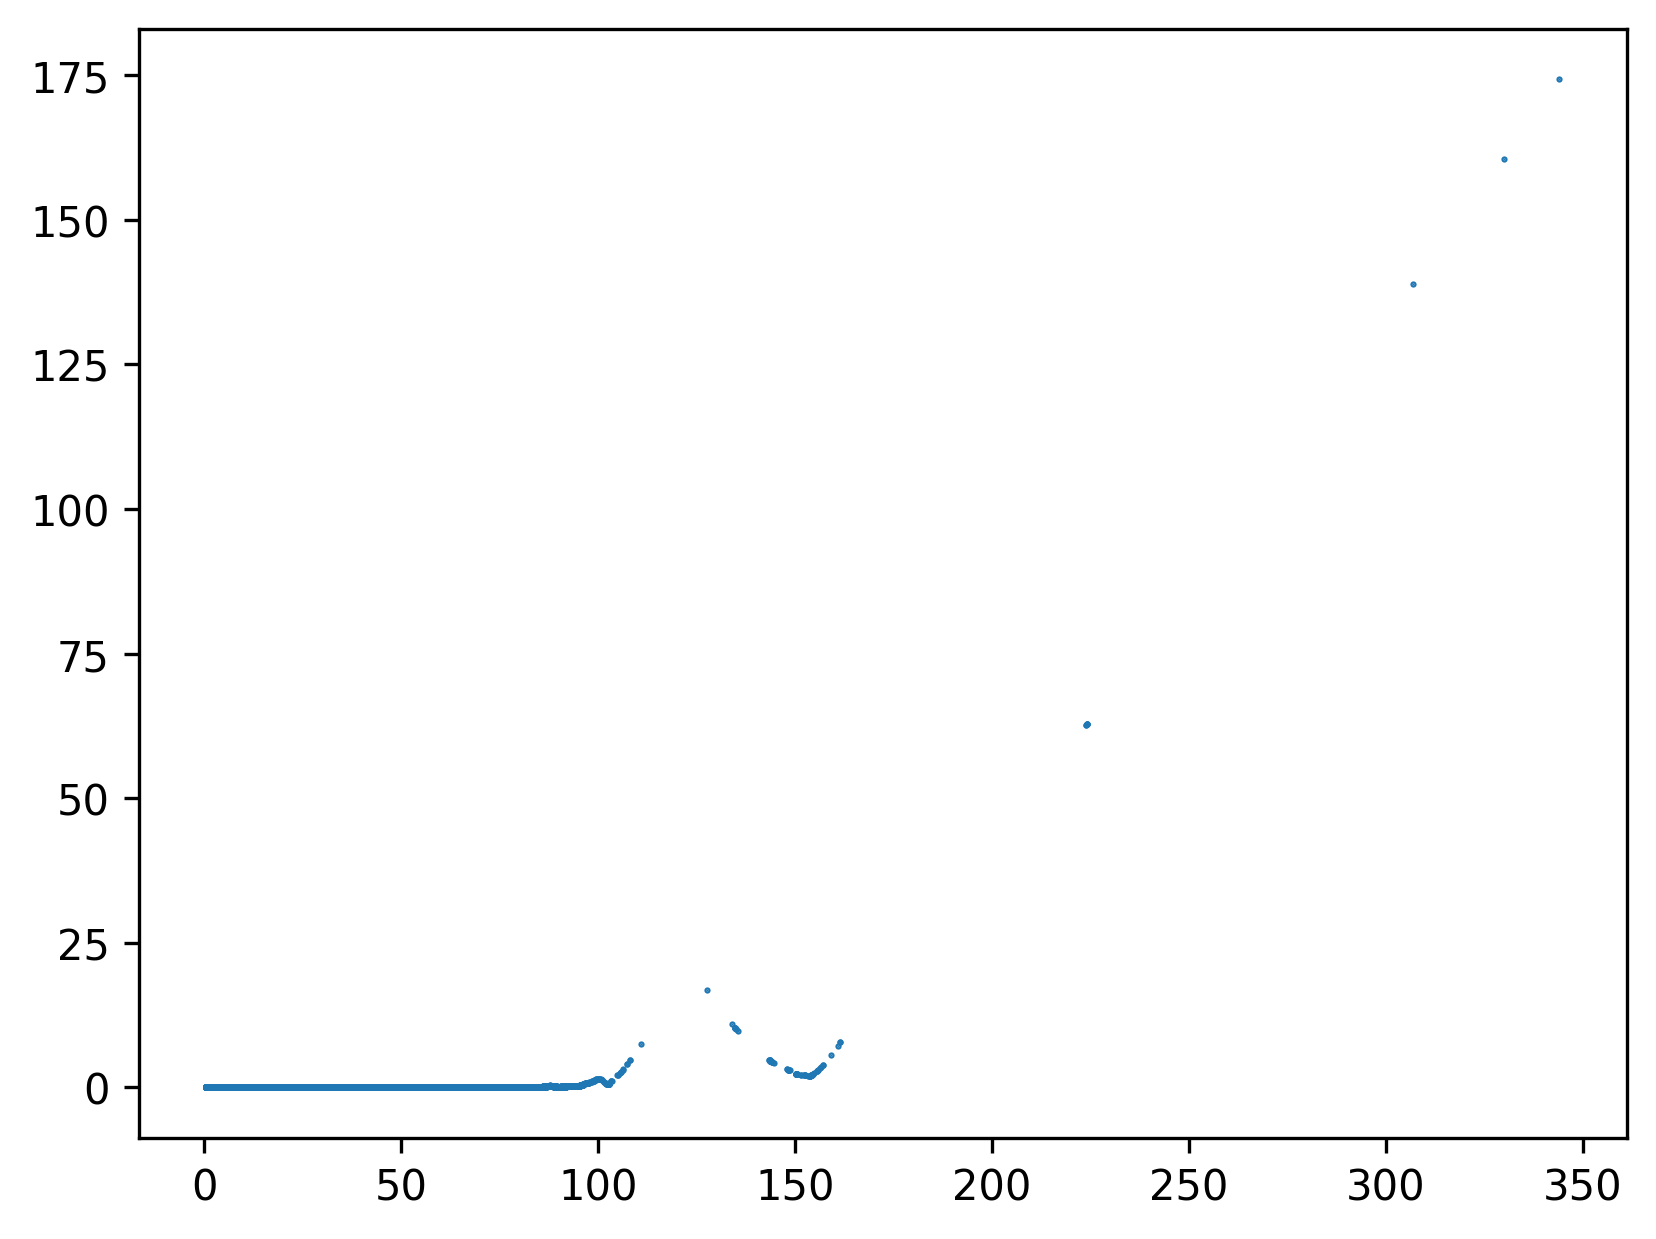

In [115]:
# plot pcd[:, -3] against nearest_neighbor_distances
start = 0
stop = nearest_neighbor_distances.shape[0]

# a = np.ones(nearest_neighbor_distances.shape[0])
# b = nearest_neighbor_distances
# densityy = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

plt.plot(pcd[start:stop, -3], nearest_neighbor_distances[start:stop], "o", markersize=0.5)
#plt.plot(pcd[start:stop, -3], density[start:stop], "o", markersize=0.5)

plt.show()

In [186]:
# Define the bin edges
bin_size = 1

bins = np.arange(min(pcd[start:stop, -3]), max(pcd[start:stop, -3]), bin_size)

# Bin the pcd data
binned_pcd = np.digitize(pcd[start:stop, -3], bins)

# Initialize an array to hold the max density in each bin
max_density = np.zeros(len(bins))

# Loop over the bins and find the max density in each one
for i in range(len(bins)):
    bin_density = density[start:stop][binned_pcd == i]
    if len(bin_density) > 0:
        max_density[i] = np.max(bin_density)

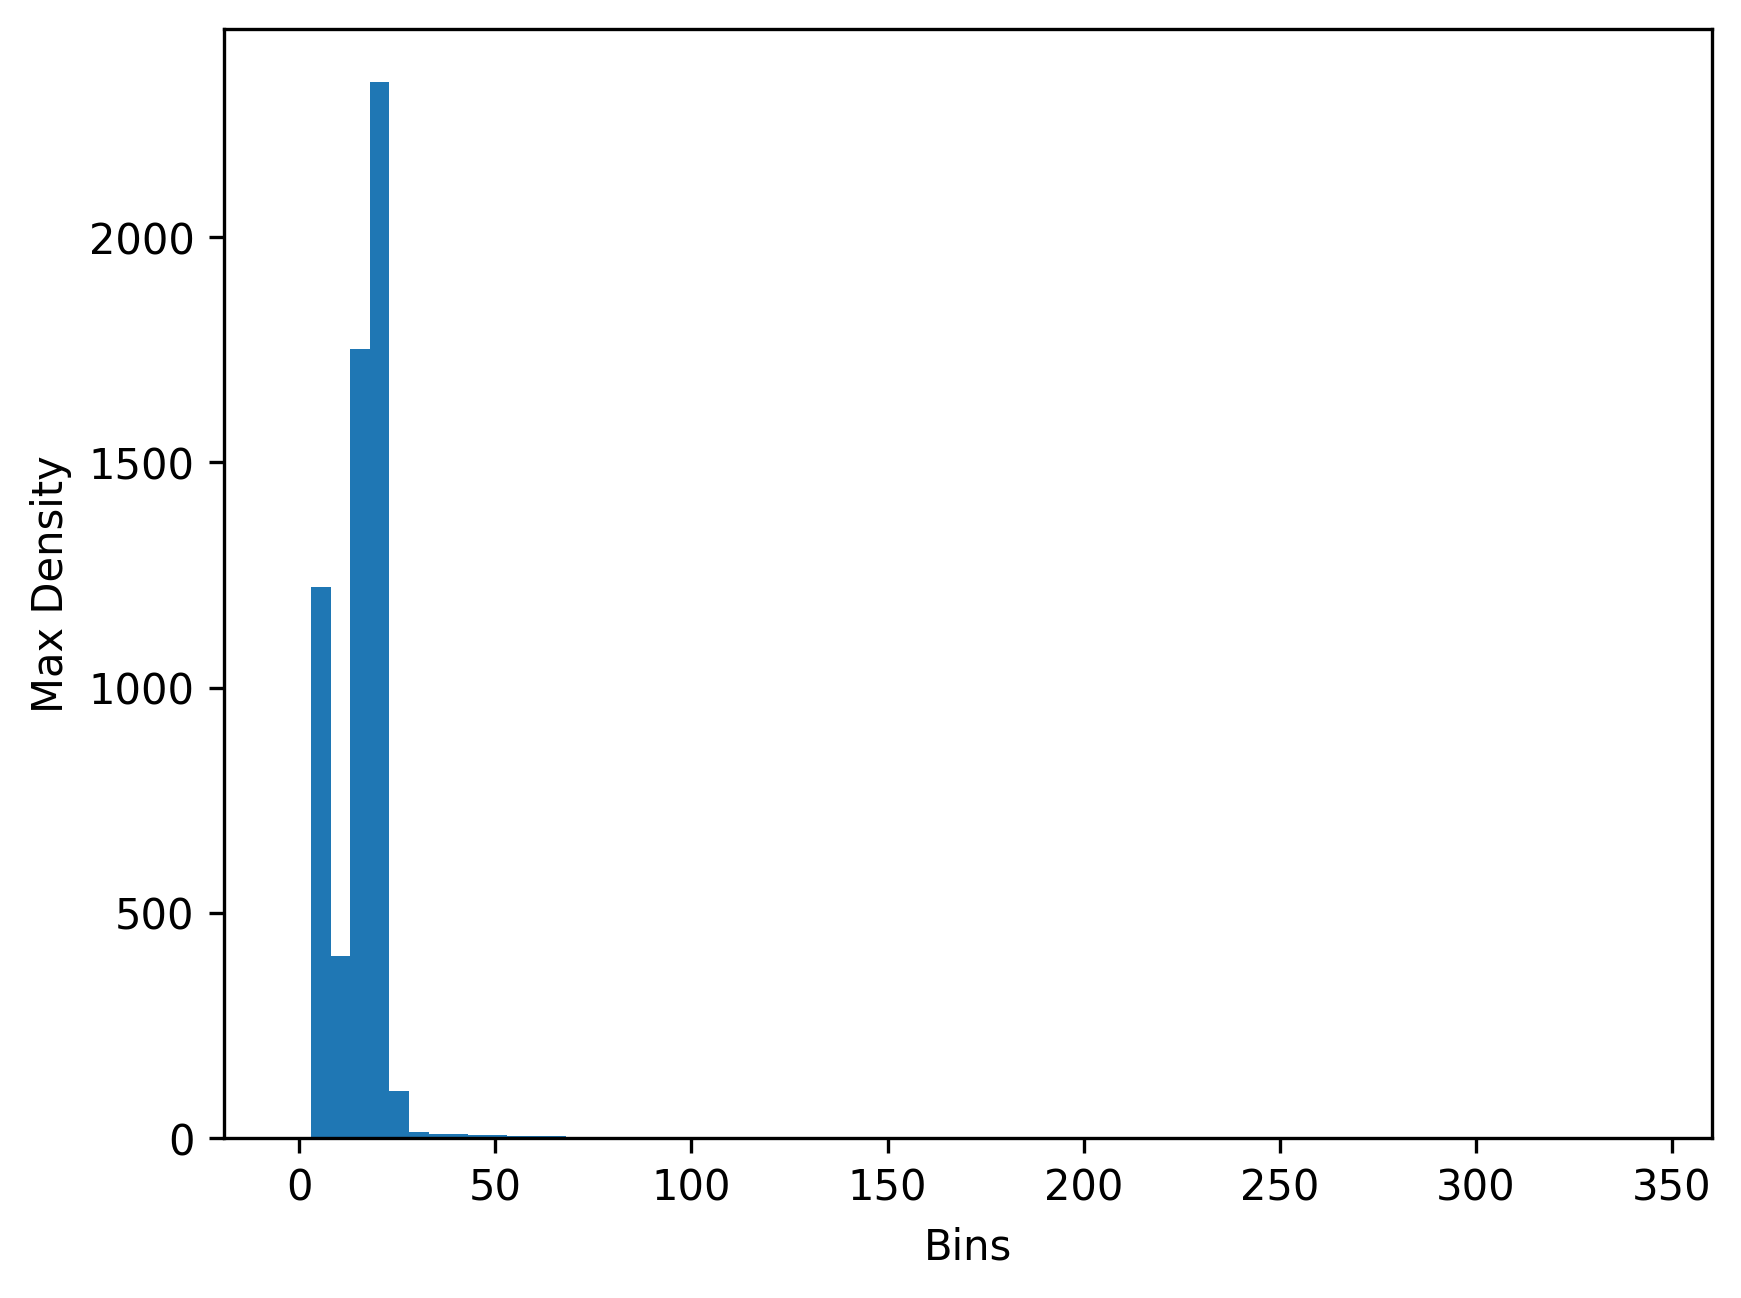

In [103]:
# Plot the max density for each bin as a histogram
plt.bar(bins, max_density, width=bin_size)
plt.xlabel('Bins')
plt.ylabel('Max Density')
plt.show()

In [189]:
# Define the bin edges
bin_size = 1

bins = np.arange(min(pcd[:, -3]), max(pcd[:, -3]), bin_size)

# Bin the pcd data
binned_pcd = np.digitize(pcd[:, -3], bins)

# Initialize an array to hold the max density in each bin
max_distance = np.zeros(len(bins))

# Loop over the bins and find the max density in each one
for i in range(len(bins)):
    bin_distance = nearest_neighbor_distances[binned_pcd == i]
    if len(bin_distance) > 0:
        max_distance[i] = np.max(bin_distance)

In [190]:
# Convert the array to a pandas Series
max_distance_series = pd.Series(max_distance)

max_distance_series.replace(0, np.nan, inplace=True)

# Interpolate missing values
max_distance_interpolated = max_distance_series.interpolate()

# Replace 0s with NaNs
max_distance_interpolated[max_distance_interpolated == 0] = np.nan

# Use forward fill to replace NaNs with the next non-NaN value
max_distance_interpolated.fillna(method='ffill', inplace=True)

# Use backward fill to replace any remaining NaNs with the previous non-NaN value
max_distance_interpolated.fillna(method='bfill', inplace=True)

# Convert back to a numpy array
max_distance = max_distance_interpolated.to_numpy()

/var/folders/j6/k2j8s_l175g46msm1l9hzz780000gn/T/ipykernel_4611/204093891.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  max_distance_interpolated.fillna(method='ffill', inplace=True)
/var/folders/j6/k2j8s_l175g46msm1l9hzz780000gn/T/ipykernel_4611/204093891.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  max_distance_interpolated.fillna(method='bfill', inplace=True)


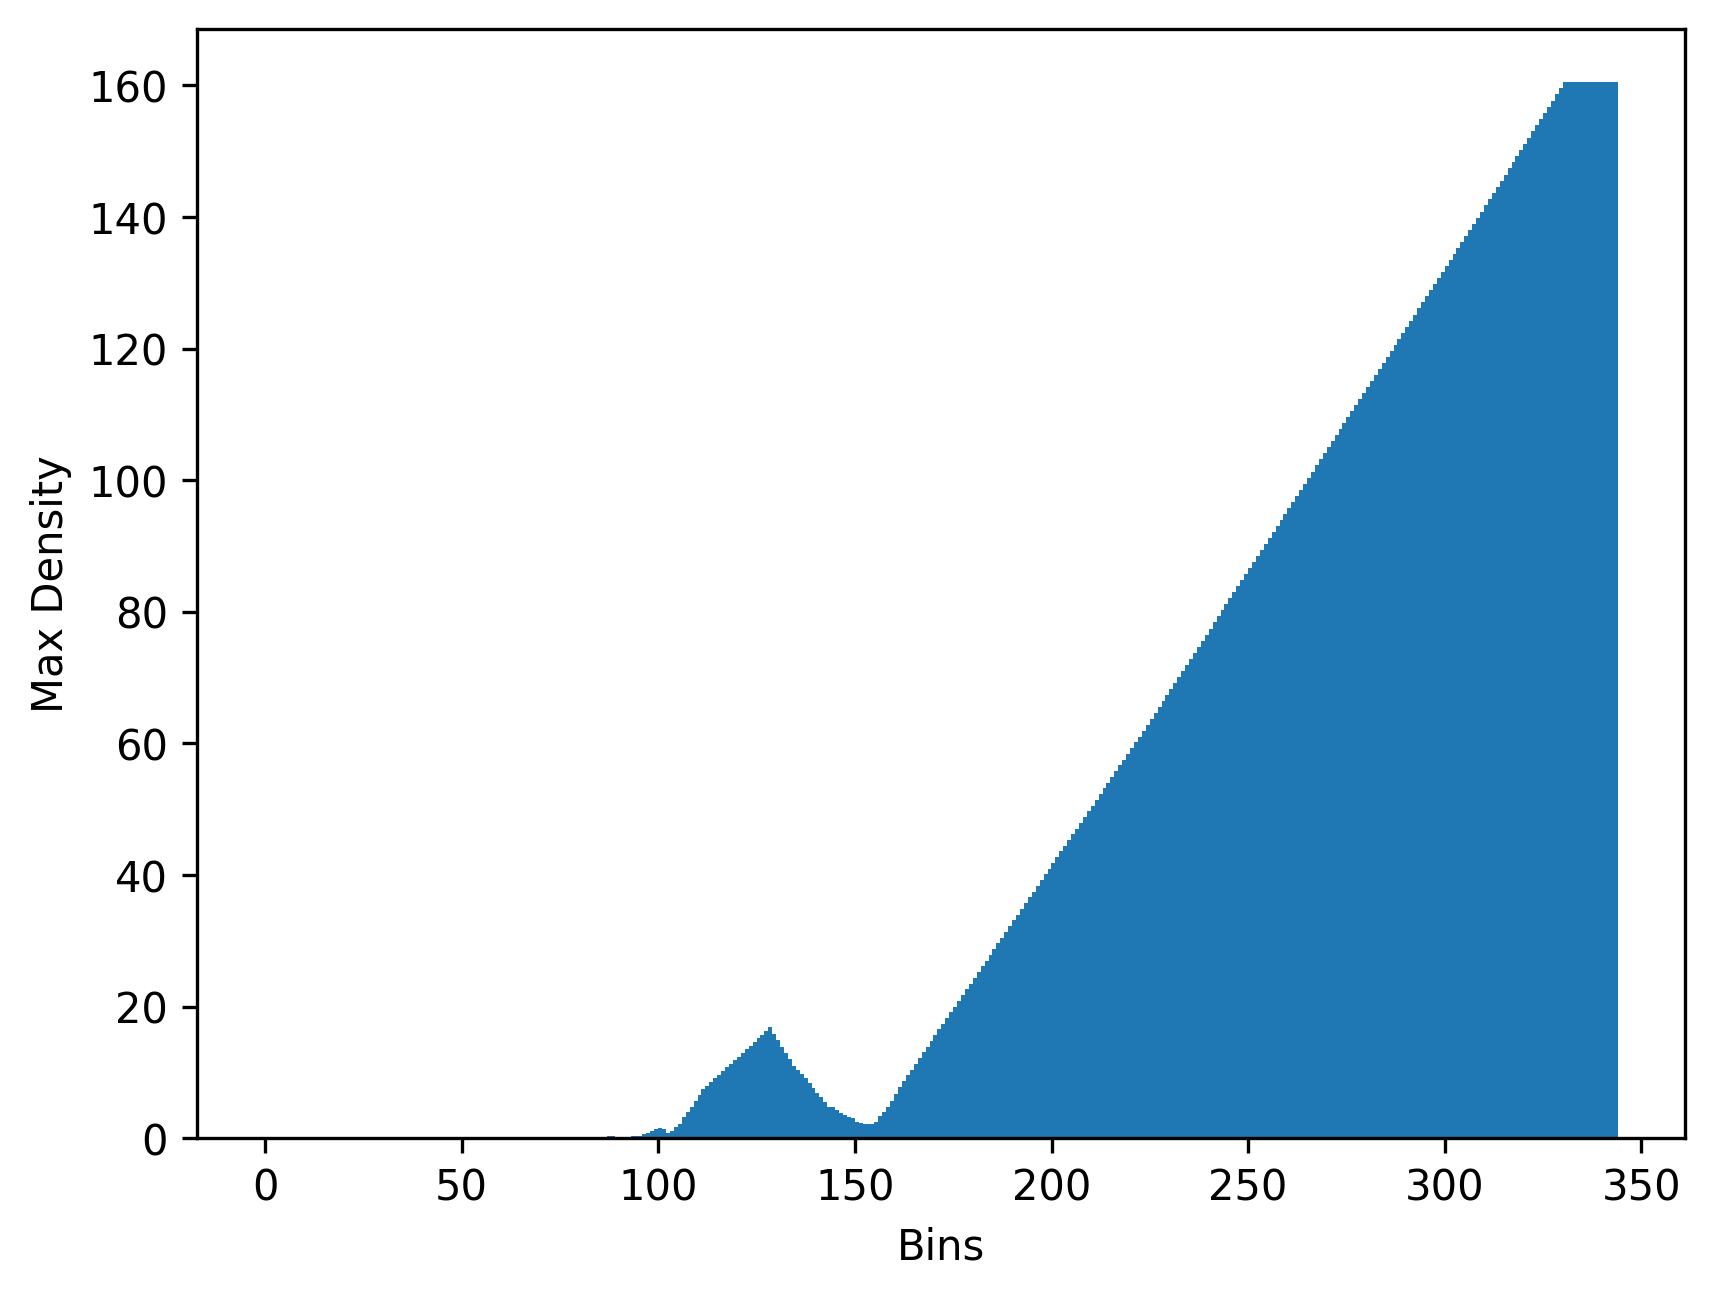

In [191]:
# Plot the max density for each bin as a histogram
plt.bar(bins, max_distance, width=bin_size)
plt.xlabel('Bins')
plt.ylabel('Max Density')
plt.show()

In [192]:
max_distance

array([  0.0941,   0.0941,   0.    ,   0.    ,   0.0001,   0.0001,
         0.0002,   0.0002,   0.0002,   0.0002,   0.0001,   0.0001,
         0.0003,   0.0003,   0.0003,   0.0003,   0.0002,   0.0002,
         0.0003,   0.0003,   0.0003,   0.0005,   0.0004,   0.0005,
         0.0007,   0.001 ,   0.0014,   0.0015,   0.0016,   0.0015,
         0.002 ,   0.0018,   0.0028,   0.003 ,   0.0034,   0.0032,
         0.0045,   0.004 ,   0.0035,   0.0076,   0.0082,   0.01  ,
         0.0134,   0.0086,   0.0082,   0.0042,   0.0091,   0.0115,
         0.0192,   0.0206,   0.0241,   0.0268,   0.0165,   0.0226,
         0.0278,   0.0312,   0.0255,   0.0271,   0.0242,   0.033 ,
         0.0203,   0.0164,   0.0293,   0.0353,   0.0544,   0.0606,
         0.0597,   0.0611,   0.1017,   0.1057,   0.0551,   0.0627,
         0.0487,   0.0475,   0.0296,   0.0619,   0.0803,   0.0596,
         0.0822,   0.0885,   0.0621,   0.1138,   0.1139,   0.13  ,
         0.1308,   0.1265,   0.2041,   0.2591,   0.337 ,   0.2

In [134]:
# Create a copy of the array to avoid modifying the original one
max_distance_filled = max_distance.copy()

# Find the indices of the zeros
zero_indices = np.where(max_distance_filled == 0)[0]

# Loop over the zeros
for zero_index in zero_indices:
    # Create a rolled version of the array that starts at the current zero
    rolled = np.roll(max_distance_filled, -zero_index)

    # Find the index of the first non-zero in the rolled array
    non_zero_index = np.argmax(rolled != 0)

    # Replace the zero with the nearest non-zero
    max_distance_filled[zero_index] = rolled[non_zero_index]

In [135]:
merged = np.column_stack((max_distance, max_distance_filled))

merged

array([[  0.    ,   0.0941],
       [  0.0941,   0.0941],
       [  0.    ,   0.    ],
       [  0.    ,   0.    ],
       [  0.0001,   0.0001],
       [  0.0001,   0.0001],
       [  0.0002,   0.0002],
       [  0.0002,   0.0002],
       [  0.0002,   0.0002],
       [  0.0002,   0.0002],
       [  0.0001,   0.0001],
       [  0.0001,   0.0001],
       [  0.0003,   0.0003],
       [  0.0003,   0.0003],
       [  0.0003,   0.0003],
       [  0.0003,   0.0003],
       [  0.0002,   0.0002],
       [  0.0002,   0.0002],
       [  0.0003,   0.0003],
       [  0.0003,   0.0003],
       [  0.0003,   0.0003],
       [  0.0005,   0.0005],
       [  0.0004,   0.0004],
       [  0.0005,   0.0005],
       [  0.0007,   0.0007],
       [  0.001 ,   0.001 ],
       [  0.0014,   0.0014],
       [  0.0015,   0.0015],
       [  0.0016,   0.0016],
       [  0.0015,   0.0015],
       [  0.002 ,   0.002 ],
       [  0.0018,   0.0018],
       [  0.0028,   0.0028],
       [  0.003 ,   0.003 ],
       [  0.00

# 27.12.2023

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
import math

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data" / "raw" / "SiteA_Scans_Global_I_RGB_RHV" / "SiteA_RHV_01.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [8]:
@jit('(float64, float64)', nopython=True)
def hypot(x, y):
    # Implementation from https://en.wikipedia.org/wiki/Hypot
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

In [42]:
# create an emtpy array with zeros of length 1000
from numba import vectorize, int32, int64, float32, float64
n = 10000000
max_distance = np.zeros(n)

@njit([(int64, float64[:])], parallel=True)
def loopy(n, max_distance):
   for i in prange(n):
      max_distance[i] = i + 1

   return max_distance

In [17]:
test = loopy.py_func(n, max_distance)

In [19]:
test.shape

(900000000,)

In [43]:
test2 = loopy(n, max_distance)

In [5]:
test2.shape

(1000000000,)

In [227]:
x = pcd[:, 0]
y = pcd[:, 1]
z = pcd[:, 2]

vert_angle = pcd[:, -1]
horiz_angle = pcd[:, -2]

In [297]:
points = np.vstack((x.copy(), y.copy(), z.copy())).T
#std = np.std(points, axis=0)
# centroid = np.mean(points, axis=0)
# points -= centroid
#points /= std

# furthest_distance = np.max(np.sqrt(np.sum(abs(points)**2,axis=-1)))
# points /= furthest_distance

#points = 1 / points
points = points.copy()

x_norm = points[:,0]
y_norm = points[:,1]
z_norm = points[:,2]

In [298]:
rho = np.sqrt(x_norm**2 + y_norm**2 + z_norm**2)
eta = np.arccos(z_norm / rho)
phi = np.arctan2(y_norm, x_norm)

eta_deg = eta * (180/np.pi)
phi_deg = phi * (180/np.pi)

# eta_deg = eta_deg % 360
# phi_deg = phi_deg % 360

In [272]:
eta_deg.max()

178.93788

In [301]:
sort_order = np.argsort(phi_deg)
#sort_order = np.argsort(horiz_angle)

In [236]:
vert_angle[sort_order][0]

19.928762

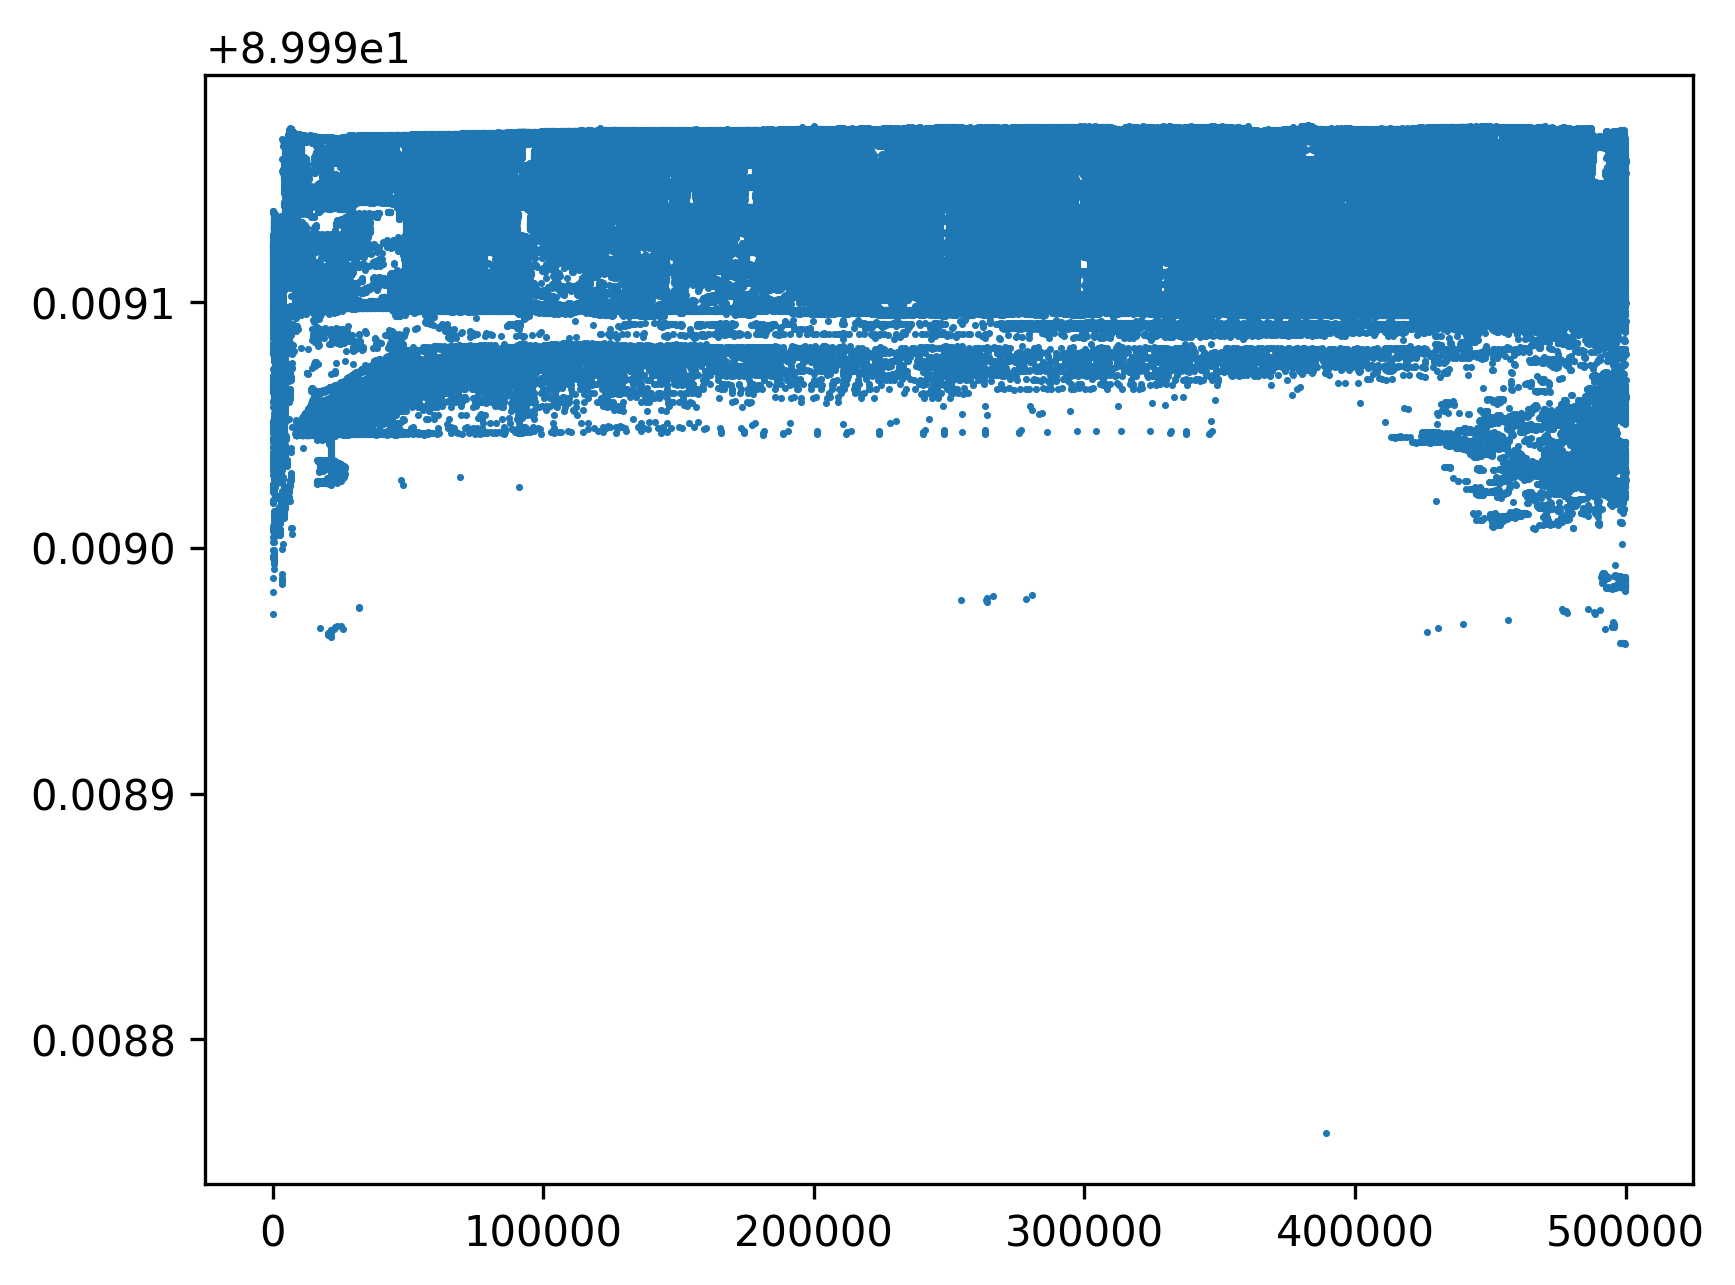

In [305]:
start = 0
stop = start + 500000

#plt.scatter(np.arange(len(vert_angle[sort_order][start:stop])), vert_angle[sort_order][start:stop], s=0.5)
plt.scatter(np.arange(len(eta_deg[sort_order][start:stop])), eta_deg[sort_order][start:stop], s=0.5)

plt.show()

In [58]:
phi_deg_diff = np.diff(phi_deg)

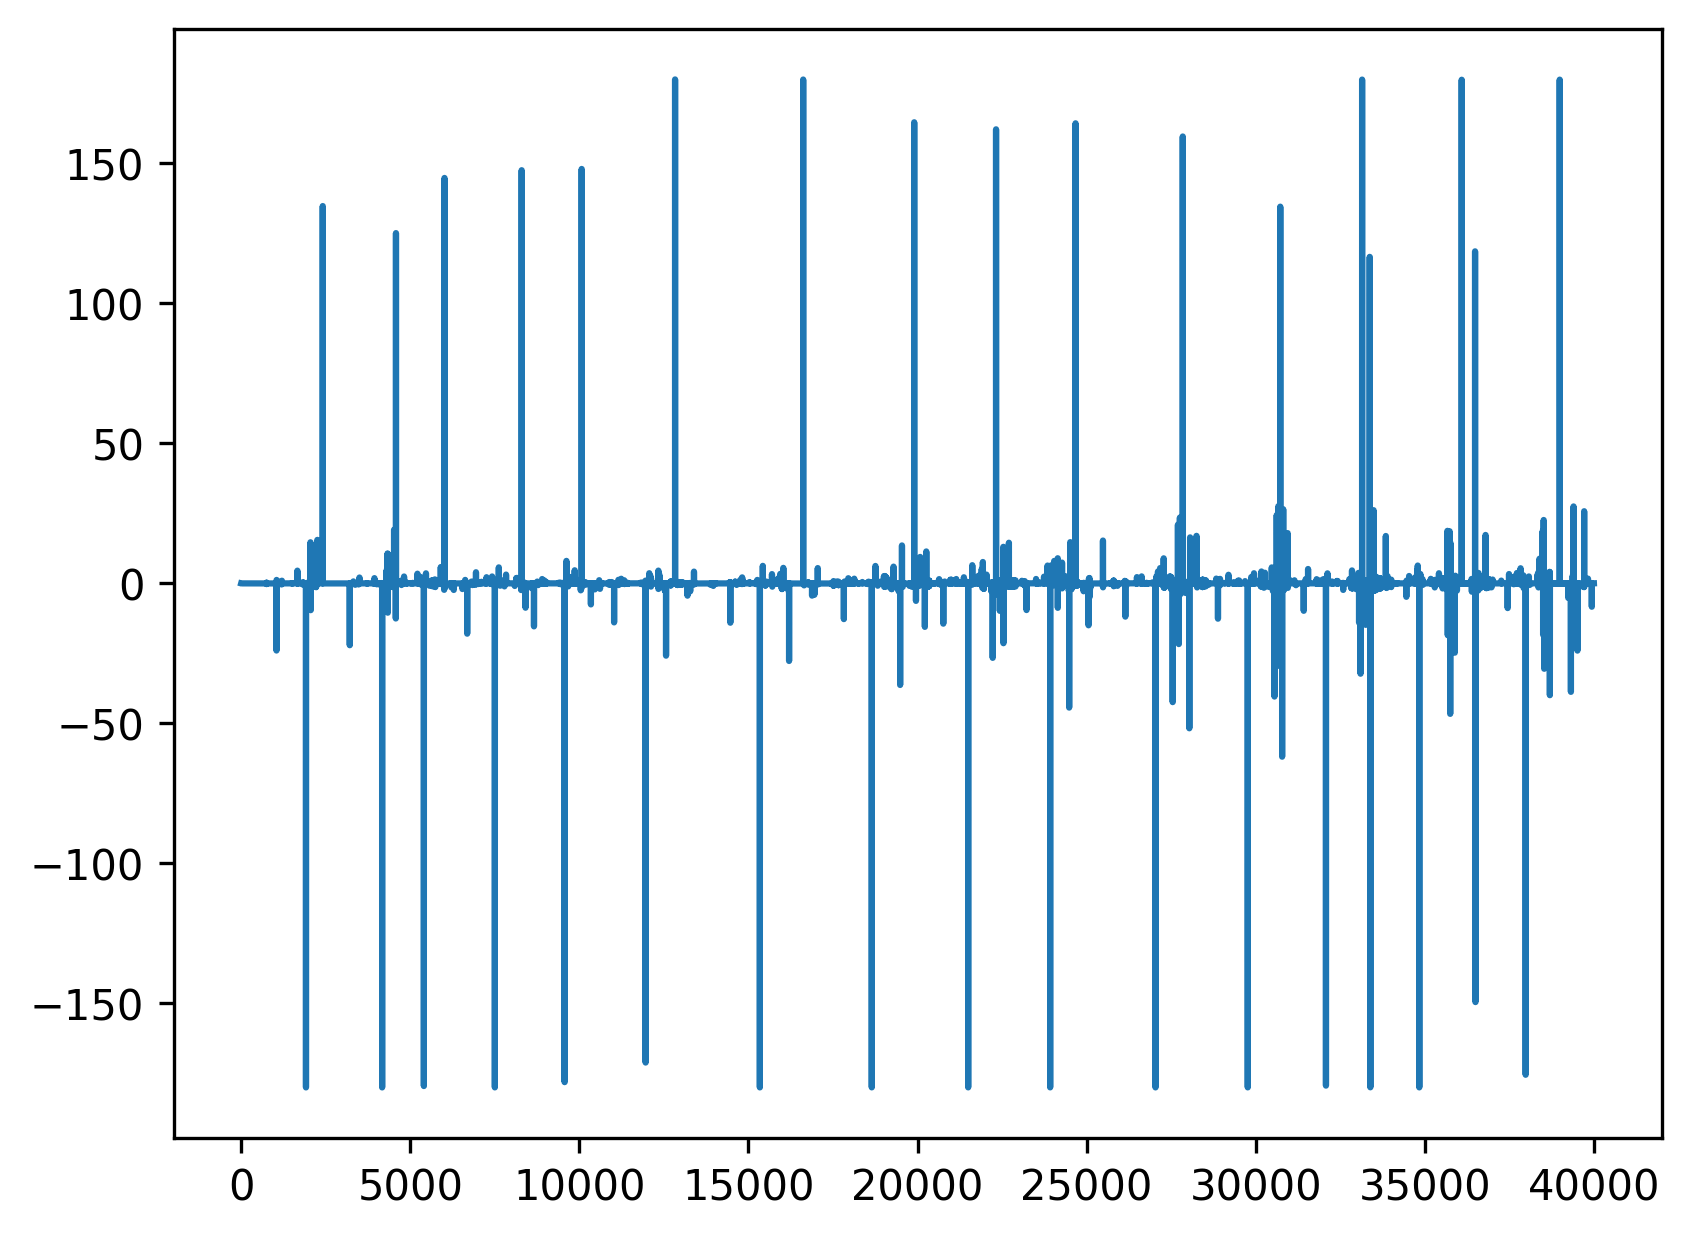

In [67]:
start = 0
stop = 100000

plt.plot(np.arange(len(phi_deg_diff[start:stop])), phi_deg_diff[start:stop])

plt.show()

# 03.01.2024

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data" / "raw" / "SiteA_Scans_Global_I_RGB_RHV" / "SiteA_RHV_01.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [2]:
pcd = pcd[pcd[:, -2].argsort()]

vertical_ang_diff = abs(np.diff(pcd[:, -1]))

vertical_ang_diff = np.append(vertical_ang_diff, vertical_ang_diff[-1])

knickpoints = np.where(vertical_ang_diff > 100)[0]

In [3]:
n = pcd.shape[0]
scanlines = np.zeros(n)

@njit([(int64, float64[:], int64[:])], parallel=True)
def scanline_extraction(n, scanlines, knickpoints):
   
   for i in prange(n):
      scanlines[i] = np.searchsorted(knickpoints, i, side='left')
   
   scanlines += 1
   
   return scanlines

In [4]:
scanlines = scanline_extraction(n, scanlines, knickpoints)

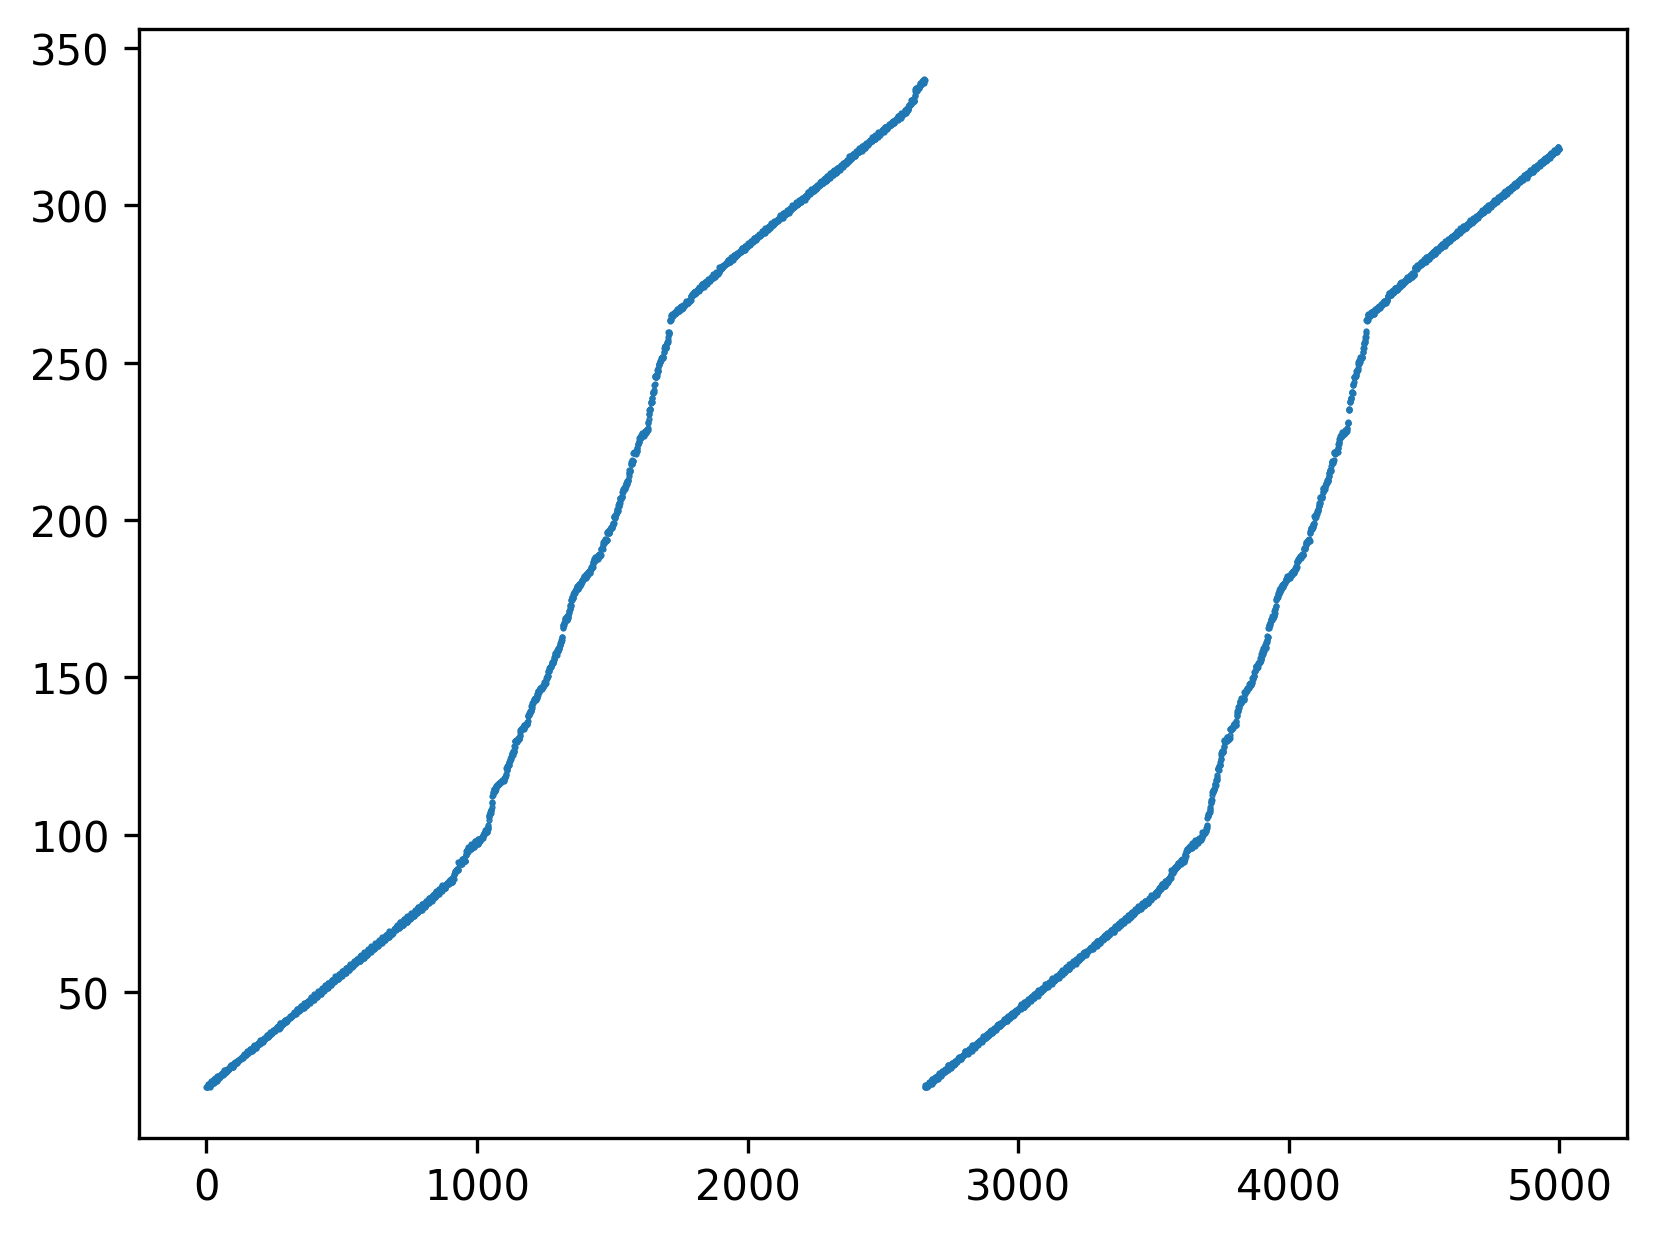

In [5]:
# plot the length of pcd[:,-2] against pcd[:,-2]
start = 0
stop = start + 5000

col = -1

plt.plot(np.arange(len(pcd[start:stop, col])), pcd[start:stop, col], "o", markersize=0.5)
plt.show()

In [11]:
pcd_scanlines = np.c_[pcd, scanlines]

In [14]:
# save the pcd as a ascii file
np.savetxt(root_dir / "data" / "raw_plus_scanline_extraction" / "SiteA_Scans_Global_I_RGB_RHV" /"Scan01_scanline.asc", pcd_scanlines, delimiter=" ", fmt="%1.4f")

# 03.01.2024

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data" / "raw" / "SiteA_Scans_Global_I_RGB_RHV" / "SiteA_RHV_01.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [30]:
# # Assuming pcd is a numpy array
# k = 30

# tree = cKDTree(pcd[:, [-3]])

# # Query the tree for the nearest neighbor of each point
# distances, indices = tree.query(pcd[:, [-3]], workers=-1, k=k)

# mean_distances = np.mean(distances[:, 1:k], axis=1)
# mean_distances = np.where(mean_distances == 0, 0.000001, mean_distances)

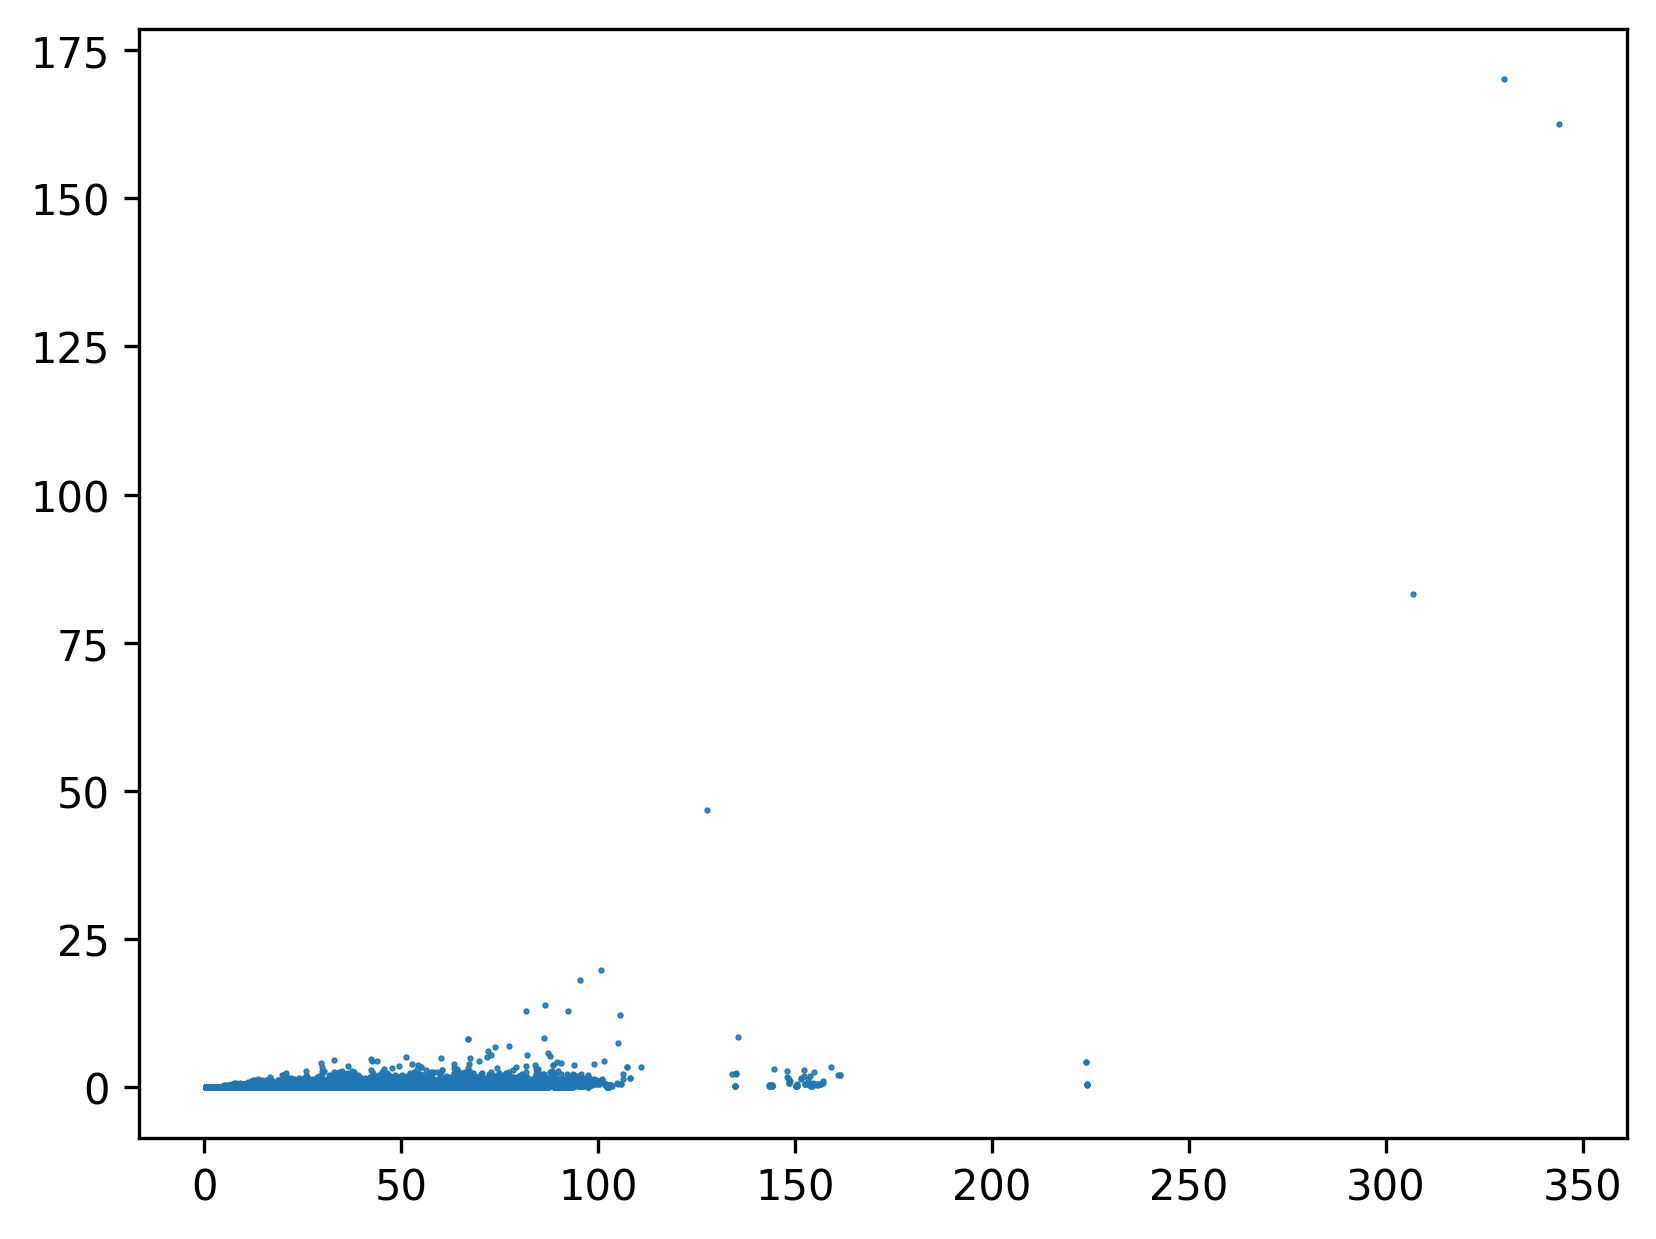

In [5]:
plt.plot(pcd[:, -3], mean_distances, "o", markersize=0.5)
plt.show()

In [3]:
# Assuming pcd is a numpy array
k = 4
tree = cKDTree(pcd[:, (0,1,2)])

# Query the tree for the nearest neighbor of each point
distances, indices = tree.query(pcd[:, (0,1,2)], workers=-1, k=k)

mean_distances = np.mean(distances[:, 1:k], axis=1)
mean_distances = np.where(mean_distances == 0, 0.000001, mean_distances)


# Define the bin edges
bin_size = 1
bins = np.arange(0, max(pcd[:, -3]), bin_size)

# Bin the pcd data
binned_pcd = np.digitize(pcd[:, -3], bins)

# Initialize an array to hold the max density in each bin
binned_distances = np.zeros(len(bins))

# Loop over the bins and find the max density in each one
for i in range(bins.shape[0]):
    bin_distance = mean_distances[binned_pcd == i]
    if len(bin_distance) > 0:
        binned_distances[i] = np.mean(bin_distance)
        
        
# Convert 0s to NaNs
binned_distances[binned_distances == 0] = np.nan

# Create an array of indices
indices = np.arange(binned_distances.shape[0])

# Get the indices of the non-NaN values
non_nan_indices = indices[~np.isnan(binned_distances)]

# Interpolate missing values
interpolated = np.interp(indices, non_nan_indices, binned_distances[non_nan_indices])

# The result is the interpolated array
max_distance = interpolated


expected_value_distance = max_distance[binned_pcd-1]

pcd = np.c_[pcd, expected_value_distance]

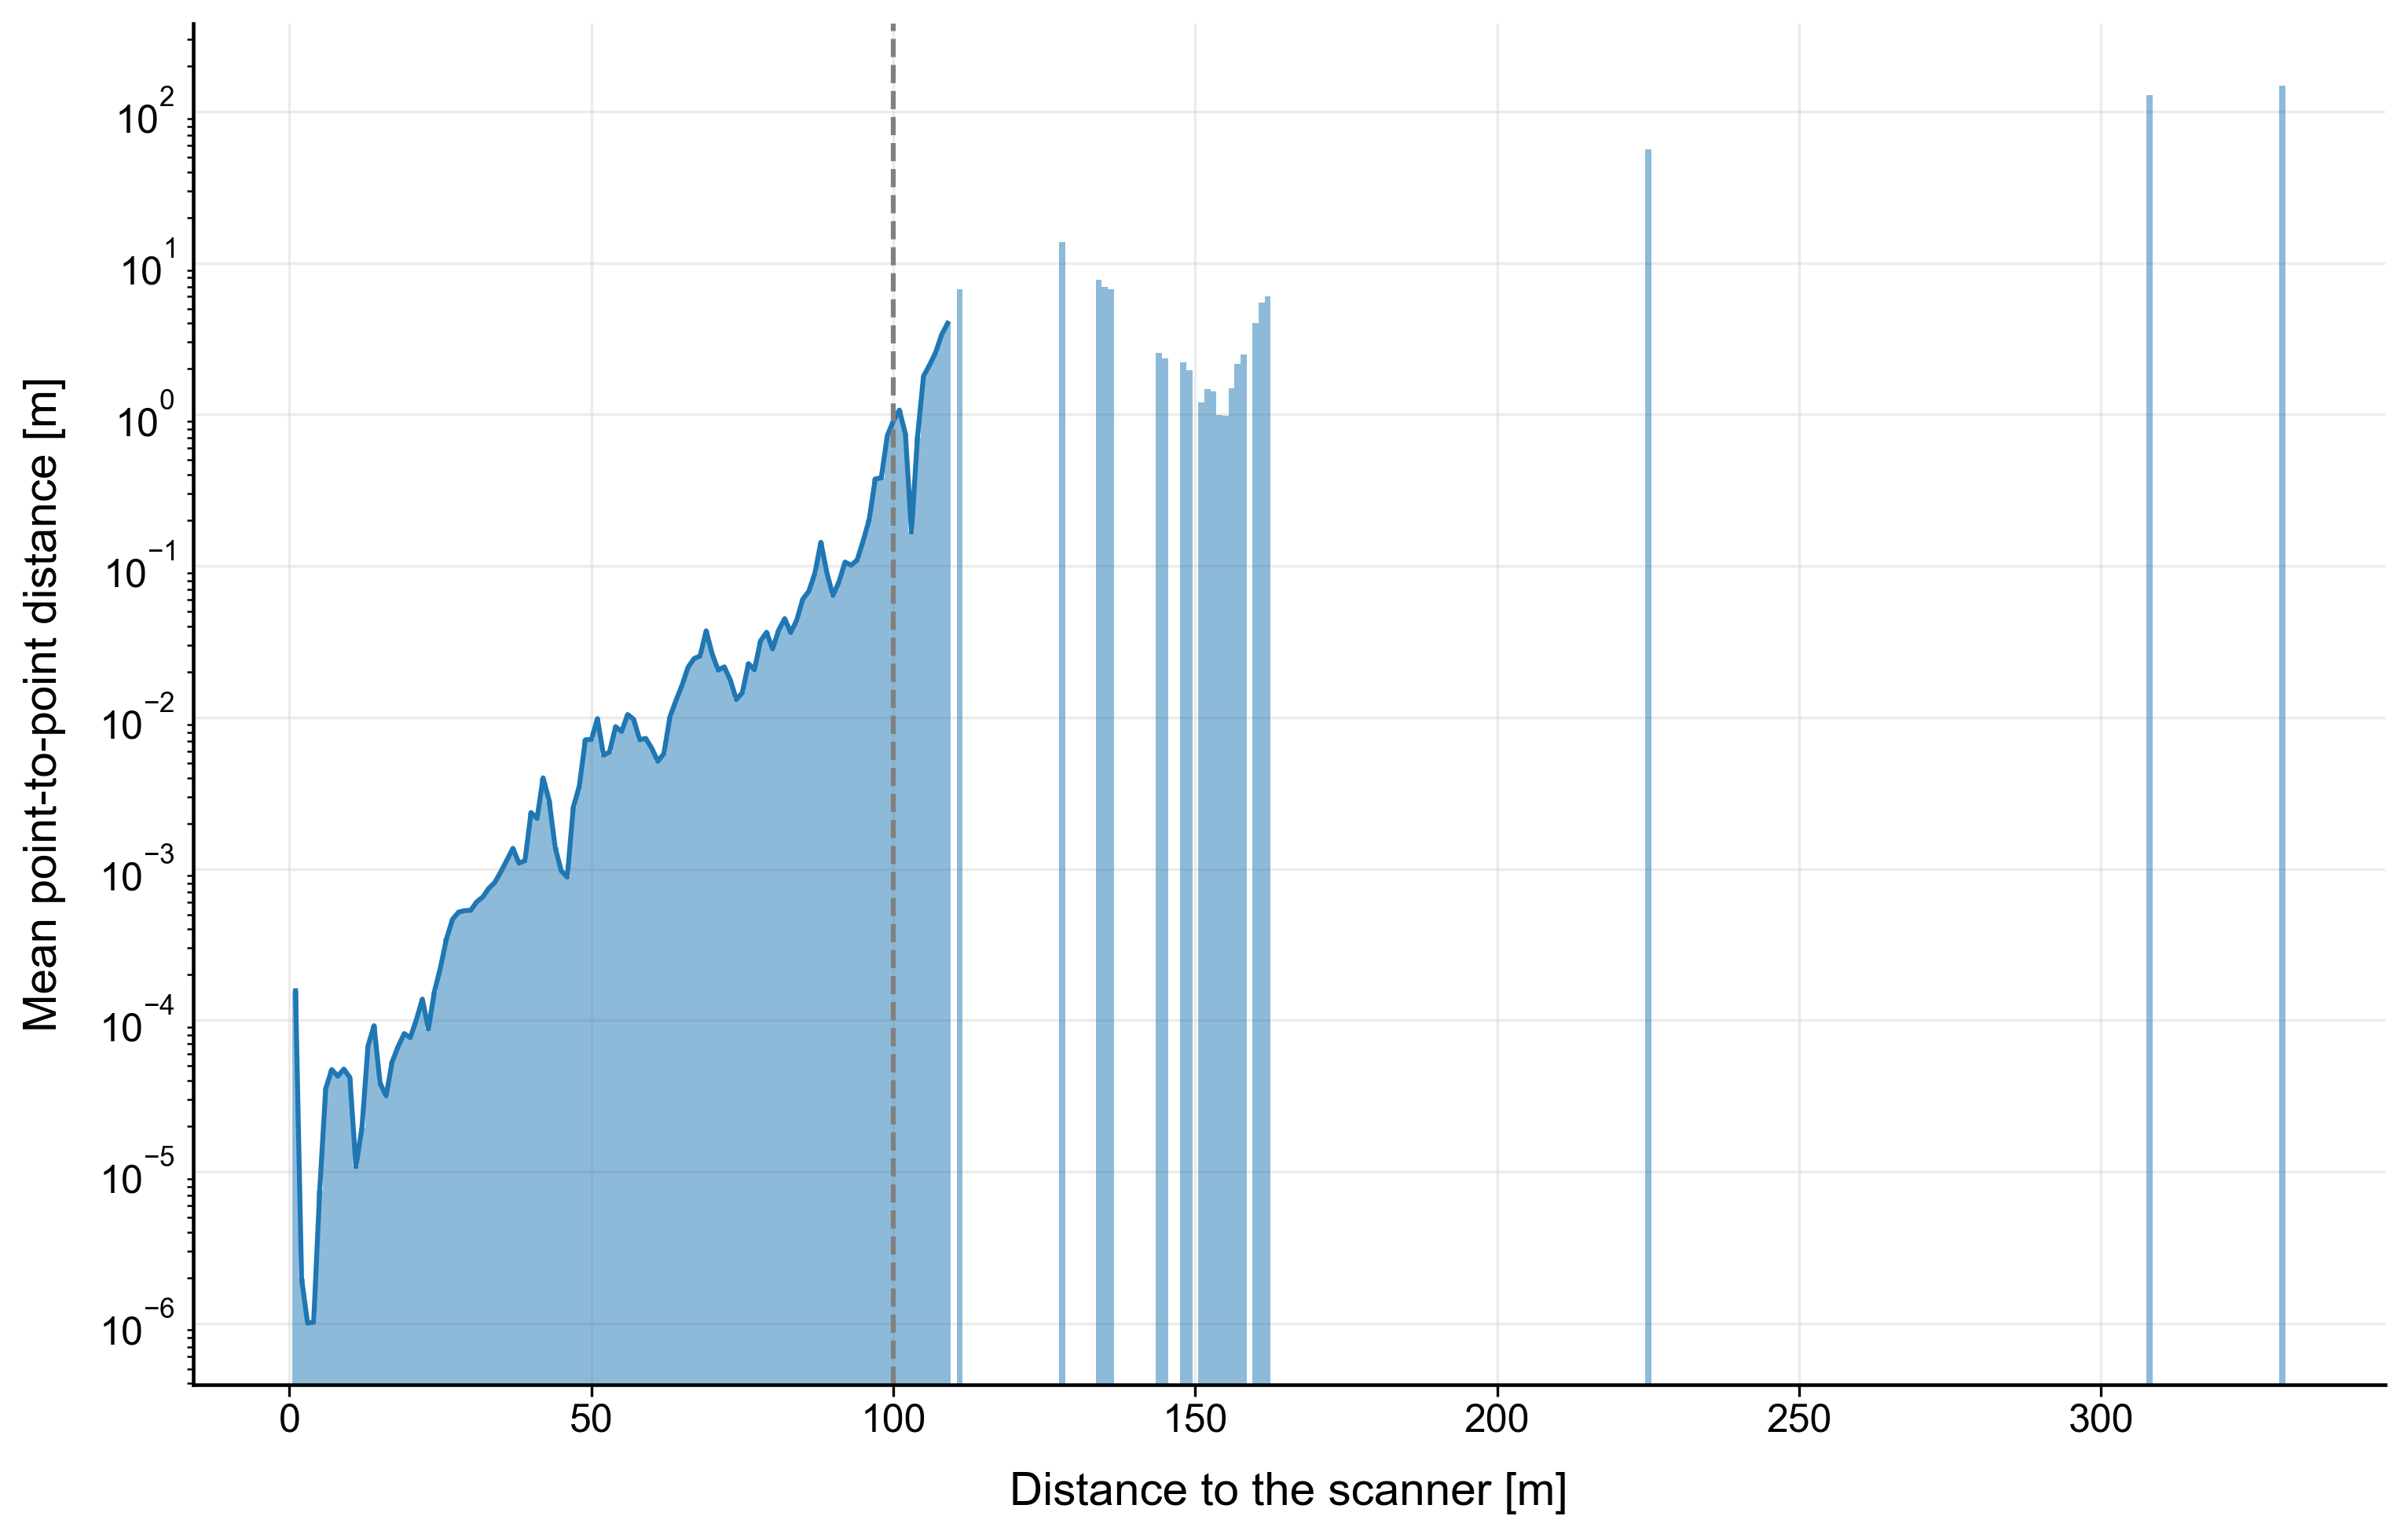

In [35]:
# Set the font to Arial
plt.rcParams["font.family"] = "Arial"
mask = bins <= 125

fig, ax = plt.subplots(figsize=(12,7.5), dpi = 300)

# Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# Plot the max density for each bin as a histogram
ax.bar(bins, binned_distances, width=bin_size, alpha=0.5, zorder=2)
ax.plot(bins[mask], binned_distances[mask], linewidth=1.5)
ax.axvline(x=100, color='grey', linestyle='--')

ax.set_xlabel('Distance to the scanner [m]', fontsize=14, labelpad=10)
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

ax.set_ylabel('Mean point-to-point distance [m]', fontsize=14, labelpad=10)
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)
ax.yaxis.set_label_position("left")

# Set the y-axis to a log scale
ax.set_yscale('log')  

# Remove the spines
ax.spines[['top','right']].set_visible(False)

# Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
ax.spines['bottom'].set_linewidth(1.1)

# Save the figure
# fig.savefig(root_dir / "data/figures/matplotlib/02_point_to_point_distance_only_R.png", bbox_inches='tight', 
#             pad_inches=0.1, dpi=400)

plt.show()

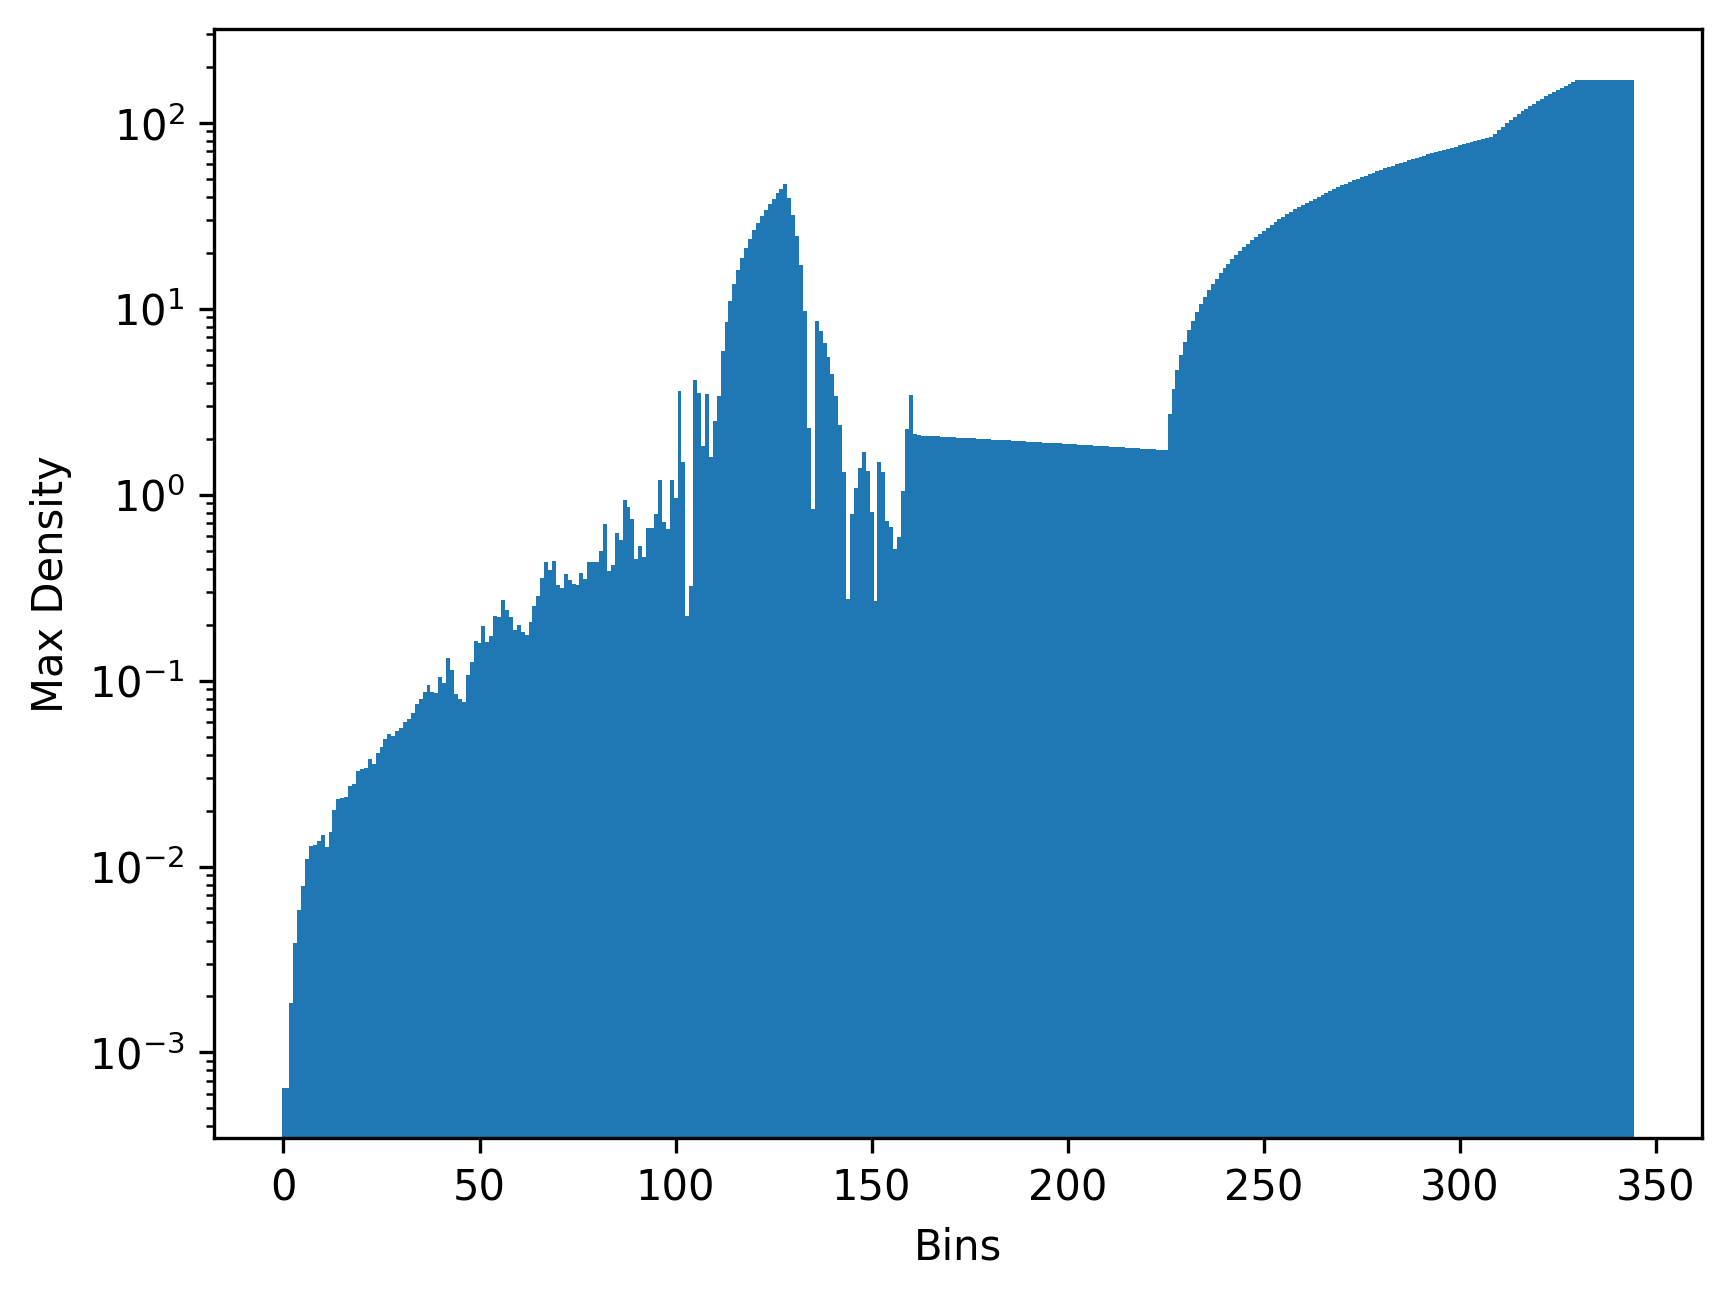

In [15]:
# Plot the max density for each bin as a histogram
plt.bar(bins, max_distance, width=bin_size)
plt.xlabel('Bins')
plt.ylabel('Max Density')
plt.yscale('log')  # Set the y-axis to a log scale
plt.show()

In [6]:
expected_value_distance = max_distance[binned_pcd-1]

In [12]:
pcd = np.c_[pcd, expected_value_distance]

In [3]:
from typing import Tuple

def create_kdtree(points: np.ndarray, 
                  k: int = 4) -> Tuple[np.ndarray, np.ndarray]:
    """
    Creates a KDTree from the given points and queries the tree for the k nearest neighbors of each point.

    Parameters:
    points (np.ndarray): The points to create the KDTree from.
    k (int): The number of nearest neighbors to query for.

    Returns:
    Tuple[np.ndarray, np.ndarray]: The mean distances and indices of the k nearest neighbors.
    """
    # Create KDTree from points
    tree = cKDTree(points)
    
    # Query for k nearest neighbors
    distances, indices = tree.query(points, workers=-1, k=k)
    
    # Calculate mean of k nearest distances, excluding self (index 0)
    mean_distances = np.mean(distances[:, 1:k], axis=1)
    
    # Replace zero distances with a small number
    mean_distances = np.where(mean_distances == 0, 0.000001, mean_distances)
    
    return mean_distances, indices


def bin_data(data: np.ndarray, 
             bin_size: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Bins the given data into bins of the given size.

    Parameters:
    data (np.ndarray): The data to bin.
    bin_size (int): The size of the bins.

    Returns:
    Tuple[np.ndarray, np.ndarray]: The bins and the binned data.
    """
    # Create bins from 0 to max of data with step size as bin_size
    bins = np.arange(0, np.max(data), bin_size)
    
    # Assign each data point to a bin
    binned_data = np.digitize(data, bins)
    
    return bins, binned_data


def calculate_binned_distances(mean_distances: np.ndarray, 
                               binned_data: np.ndarray, 
                               bins: np.ndarray) -> np.ndarray:
    """
    Calculates the mean distance for each bin.

    Parameters:
    mean_distances (np.ndarray): The mean distances to calculate the binned distances from.
    binned_data (np.ndarray): The binned data.
    bins (np.ndarray): The bins.

    Returns:
    np.ndarray: The binned distances.
    """
    # Initialize array for binned distances
    binned_distances = np.zeros(len(bins))
    
    # For each bin, calculate mean distance
    for i in range(bins.shape[0]):
        bin_distance = mean_distances[binned_data == i]
        if len(bin_distance) > 0:
            binned_distances[i] = np.mean(bin_distance)
    
    # Replace zero distances with NaN
    binned_distances[binned_distances == 0] = np.nan
    
    return binned_distances


def interpolate_distances(binned_distances: np.ndarray) -> np.ndarray:
    """
    Interpolates the binned distances to fill in any missing values.

    Parameters:
    binned_distances (np.ndarray): The binned distances to interpolate.

    Returns:
    np.ndarray: The interpolated distances.
    """
    
    indices = np.arange(binned_distances.shape[0])
    
    # Get indices of non-NaN values
    non_nan_indices = indices[~np.isnan(binned_distances)]
    
    # Interpolate to fill NaN values
    interpolated = np.interp(indices, non_nan_indices, binned_distances[non_nan_indices])
    
    return interpolated


def add_expected_value_distance(pcd: np.ndarray, 
                                binned_pcd: np.ndarray, 
                                binned_distance_interp: np.ndarray) -> np.ndarray:
    """
    Adds the expected value of distance to the point cloud data.

    Parameters:
    pcd (np.ndarray): The point cloud data.
    binned_pcd (np.ndarray): The binned point cloud data.
    max_distance (np.ndarray): The maximum distances for each bin.

    Returns:
    np.ndarray: The point cloud data with the expected value of distance added.
    """
    # Calculate the expected value of distance for each point
    expected_value_distance = binned_distance_interp[binned_pcd-1]

    # Add the expected value of distance to the point cloud data
    pcd = np.c_[pcd, expected_value_distance]
    
    return pcd

In [5]:
## Calculate the mean point-to-point distances as expected values for the segmentation
# Create a KDTree and calculate mean distances
mean_distances, _ = create_kdtree(points=pcd[:, (0,1,2)])

# Bin the data
bins, binned_pcd = bin_data(data=pcd[:, -3], bin_size=1)

# Calculate binned distances
binned_distances = calculate_binned_distances(mean_distances=mean_distances, binned_data=binned_pcd, bins=bins)

# Interpolate distances
binned_distances_interpolated = interpolate_distances(binned_distances=binned_distances)

# Add expected value distance to the point cloud data
pcd = add_expected_value_distance(pcd=pcd, binned_pcd=binned_pcd, binned_distance_interp=binned_distances_interpolated)

In [12]:
pcd[1000000:1000000+50, (-4, -1)]

array([[12.6795,  0.0153],
       [12.686 ,  0.0153],
       [16.8985,  0.0235],
       [16.9153,  0.0235],
       [16.9298,  0.0235],
       [16.9442,  0.0235],
       [16.9839,  0.0235],
       [16.9728,  0.0235],
       [16.9537,  0.0235],
       [16.9378,  0.0235],
       [16.9326,  0.0235],
       [16.9252,  0.0235],
       [16.9219,  0.0235],
       [17.0251,  0.0272],
       [16.9973,  0.0235],
       [16.9972,  0.0235],
       [11.1201,  0.0127],
       [11.1109,  0.0127],
       [11.1059,  0.0127],
       [11.1088,  0.0127],
       [11.1116,  0.0127],
       [11.1198,  0.0127],
       [11.1574,  0.0127],
       [11.153 ,  0.0127],
       [11.1506,  0.0127],
       [11.1514,  0.0127],
       [11.1545,  0.0127],
       [17.1229,  0.0272],
       [17.1263,  0.0272],
       [17.1982,  0.0272],
       [17.2963,  0.0272],
       [17.3066,  0.0272],
       [17.2843,  0.0272],
       [17.312 ,  0.0272],
       [17.3213,  0.0272],
       [17.0294,  0.0272],
       [17.0675,  0.0272],
 

In [17]:
np.percentile(pcd[:,-1], 98)

0.05356634910565548

# 05.01.2023

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data/raw_plus_scanline_extraction/SiteA_Scans_Global_I_RGB_RHV/Scan01_with_scanlineID.asc" #"data" / "raw" / "SiteA_Scans_Global_I_RGB_RHV" / "SiteA_RHV_01.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [84]:
scanline_indices = np.where(pcd[:, -1] == 1820)[0]
scanline = pcd[scanline_indices]
scanline1_pcd = pcd[pcd[:, -3].argsort()]

In [3]:
# Calculate the absolute difference of the last column
rho_diff = abs(np.diff(scanline1_pcd[:, -5]))

# Append the last value of vertical_ang_diff to itself
rho_diff = np.append(rho_diff, rho_diff[-1])

In [4]:
def get_dist_3D(x1,y1,z1,x2,y2,z2):
    # Calculate the 3D distance between the two points 
    dist = np.sqrt( np.abs( ( (x2-x1)**2 ) + ( (y2-y1)**2 ) ) + ( (z2-z1)**2 ) )
    
    return dist

def get_slope_3D(x1,y1,z1,x2,y2,z2,deg=True):
    # Get the distance between the two points 
    dist = get_dist_3D(x1,y1,z1,x2,y2,z2)
    
    if dist == 0:
        return np.nan
    else:
        if deg:
            return np.round(np.rad2deg((z1 - z2) / dist), 4)
        else:
            return np.round((z1 - z2) / dist, 4)

In [5]:
x = scanline1_pcd[:, 0]
y = scanline1_pcd[:, 1]
z = scanline1_pcd[:, 2]

slope = np.zeros(scanline1_pcd.shape[0])

for i in range(scanline1_pcd.shape[0]):
    if i == 0:
        slope[i] = get_slope_3D(x[i], y[i], z[i], x[i+1], y[i+1], z[i+1])
    elif i <= scanline1_pcd.shape[0]-2:
        slope[i] = get_slope_3D(x[i-1], y[i-1], z[i-1], x[i+1], y[i+1], z[i+1])
    else:
        slope[i] = get_slope_3D(x[i-1], y[i-1], z[i-1], x[i], y[i], z[i])

slope_diff = abs(np.diff(slope))

# Append the last value of vertical_ang_diff to itself
slope_diff = np.append(slope_diff, slope_diff[-1])

In [6]:
# Calculate the differences between adjacent points in the slope
slope_diff = np.roll(slope, -1) - np.roll(slope, 1)

# Calculate the curvature as the rate of change of the slope
curvature = abs(slope_diff)

# Note: The first and last values of curvature will be incorrect because of the roll operation.
# You may want to set them to NaN or some other value.
curvature[0] = np.nan
curvature[-1] = np.nan

In [7]:
density = 1 / scanline1_pcd[:,-2]

In [38]:
# rho_diff_manip = rho_diff.copy() * density

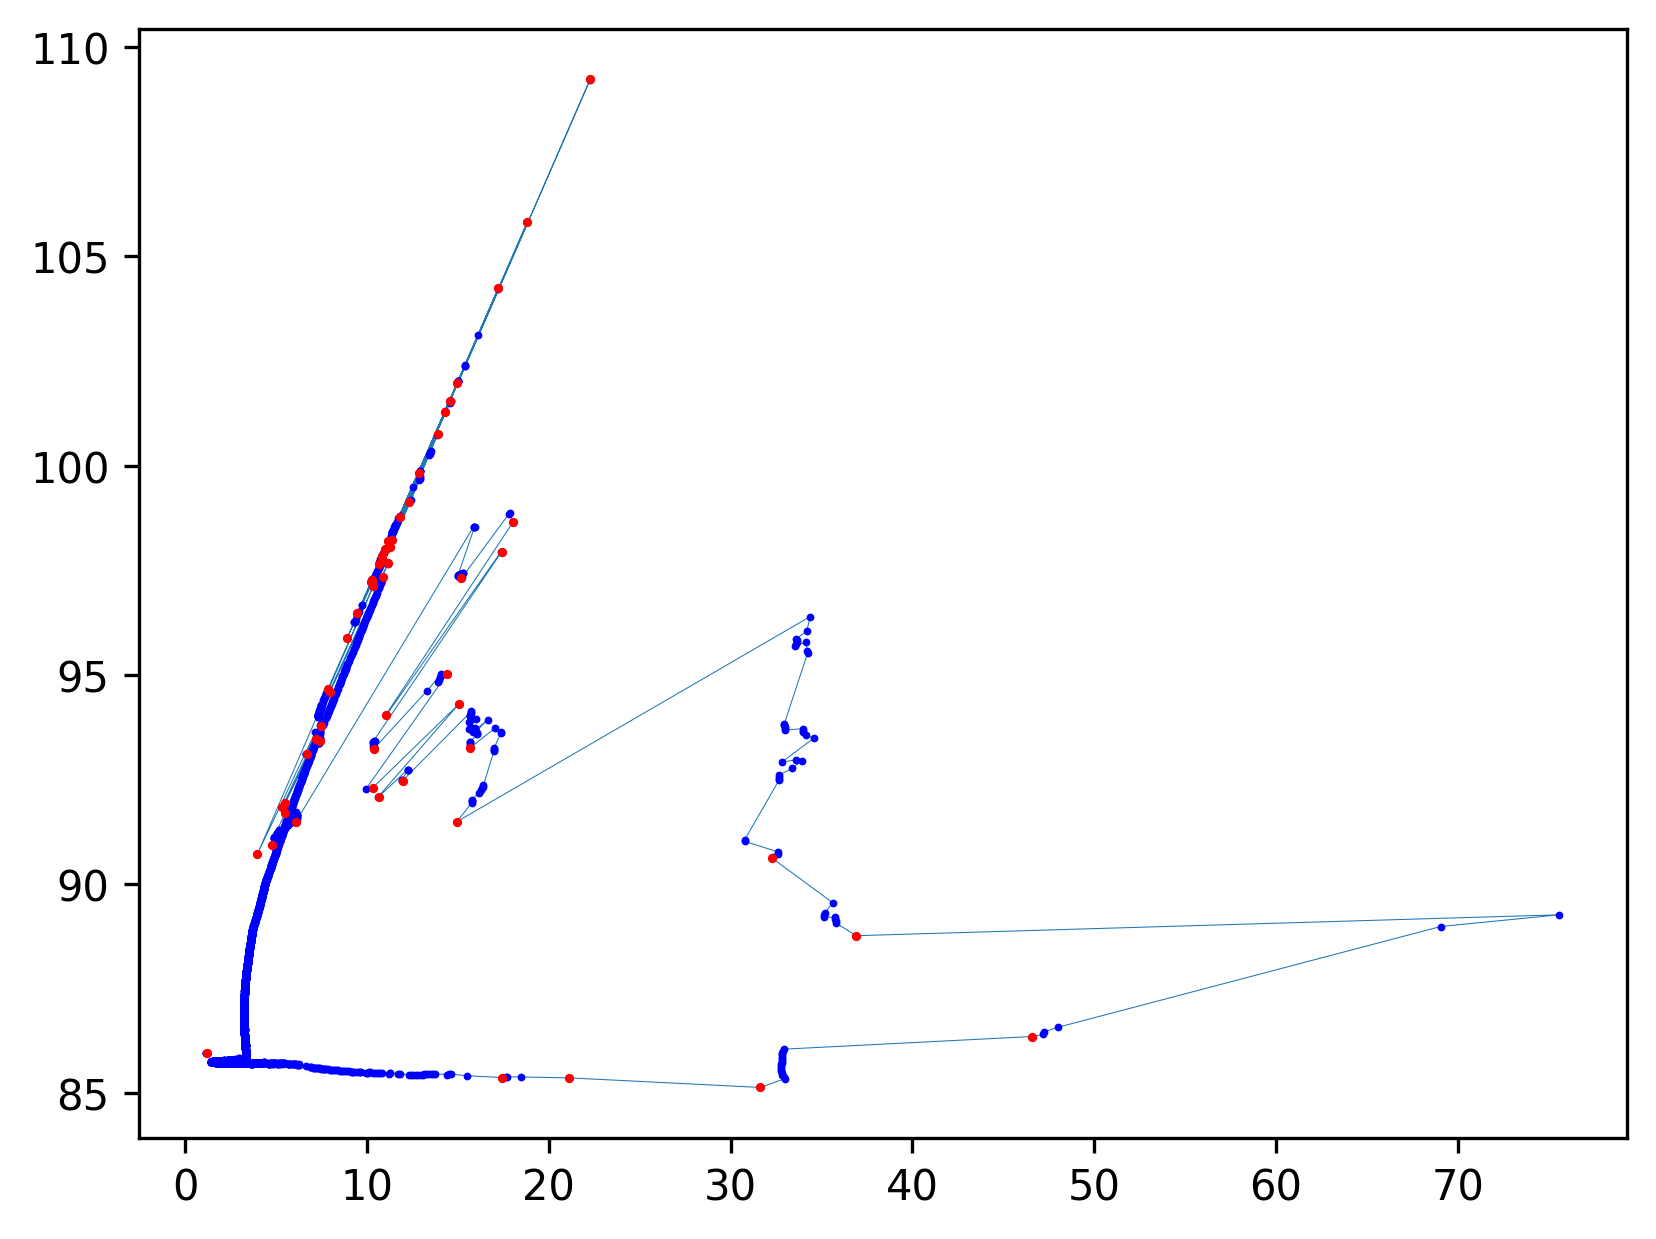

In [78]:
# plot scanline1_pcd[:, 2] against scanline1_pcd[:, -5] and colorize the points with the slope
start = 0
stop = 3000

cmap = plt.get_cmap("viridis")
colors = cmap(rho_diff[start:stop])

plt.plot(scanline1_pcd[start:stop, -5], scanline1_pcd[start:stop, 2], "-", linewidth=0.25, zorder=1)
plt.scatter(scanline1_pcd[start:stop, -5], scanline1_pcd[start:stop, 2], c='blue', s=0.75, zorder=2)

# Find indices where slope difference is greater than 50
indices = np.where(rho_diff[start:stop] > scanline1_pcd[start:stop,-2]*50) # 

# Plot those points in red
plt.scatter(scanline1_pcd[start:stop, -5][indices], scanline1_pcd[start:stop, 2][indices], c='red', s=1.5, zorder=3)

# plt.ylim(85.735,85.800)
# plt.xlim(1, 2)

plt.show()

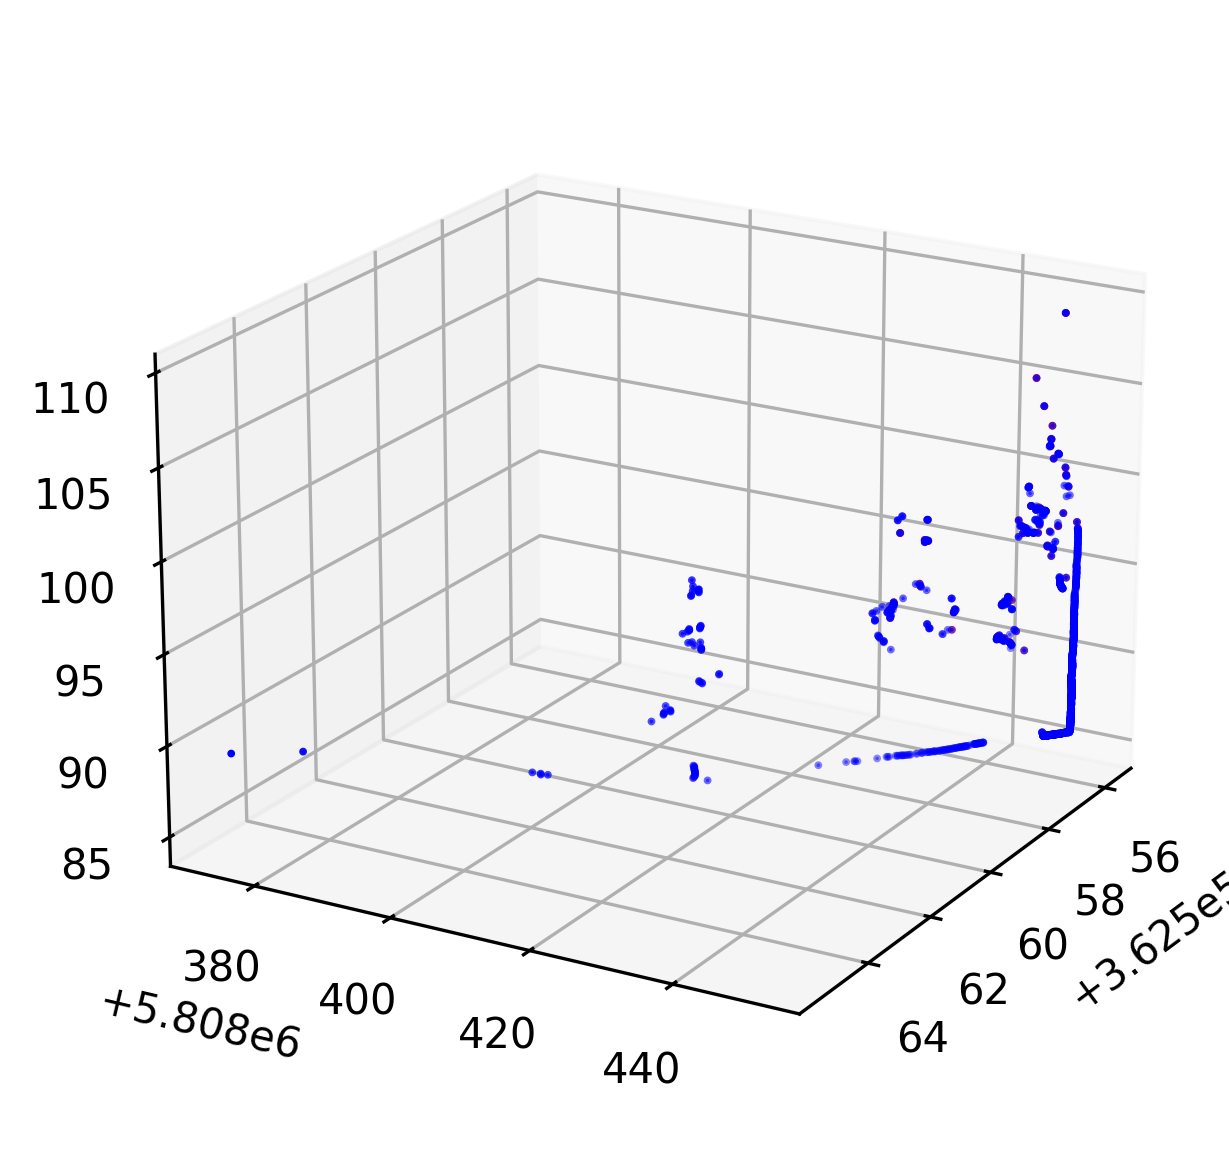

In [89]:
from mpl_toolkits.mplot3d import Axes3D

# Assume x, y, z are your arrays of x-values, y-values, and z-values
x = scanline1_pcd[start:stop, 0]
y = scanline1_pcd[start:stop, 1]
z = scanline1_pcd[start:stop, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points in blue
ax.scatter(x, y, z, c='blue', s=0.75)

# Find indices where slope difference is greater than 50
indices = np.where(slope_diff[start:stop] > 60)

# Plot those points in red
ax.scatter(x[indices], y[indices], z[indices], c='red', s=0.75)

ax.view_init(elev=20, azim=30)

plt.show()

In [125]:
# Assume z and r are your arrays of z-values (heights) and r-values (distances)
z = scanline1_pcd[1:50:,2]
r = scanline1_pcd[1:50:,-5]

# Calculate the differences between adjacent points
z_diff = np.roll(z, -1) - np.roll(z, 1)
r_diff = np.roll(r, -1) - np.roll(r, 1)

#r_diff = np.where(r_diff == 0, 0.001, r_diff)
z_diff += 1e-10
r_diff += 1e-10

# Calculate the slope
#slope = np.where(r_diff != 0, z_diff / r_diff, 0)
slope = z_diff / r_diff

# Replace unrealistic slope values with the value of the point before
max_slope = 1e6  # define your threshold for unrealistic slope values
slope = np.where(np.abs(slope) > max_slope, np.roll(slope, 1), slope)

# Note: The first value of slope will be incorrect because of the roll operation.
# You may want to set it to NaN or some other value.
slope[0] = np.nan
slope[-1] = np.nan

In [ ]:
@njit([(int64, float64[:], int64[:])], parallel=True)
def scanline_extraction(n, scanlines, knickpoints):
   
   for i in prange(n):
      scanlines[i] = np.searchsorted(knickpoints, i, side='left')
   
   scanlines += 1
   
   return scanlines

In [2]:
@jit(nopython=True) 
def sort_scanline(pcd: np.ndarray, col: int) -> np.ndarray:
    return pcd[pcd[:, col].argsort()]


@jit(nopython=True) 
def get_scanline(pcd: np.ndarray, col: int, id: int) -> np.ndarray:
    
    scanline_indices = np.where(pcd[:, col] == id)[0]
    scanline = pcd[scanline_indices]
    
    return scanline, scanline_indices

In [3]:
@jit(nopython=True) 
def calculate_rho_diff(pcd: np.ndarray, col: int) -> np.ndarray:
    """
    Calculates the absolute difference of the last column of the given point cloud data.

    Parameters:
    pcd (np.ndarray): The point cloud data.

    Returns:
    np.ndarray: The absolute difference of the last column.
    """
    # Calculate the absolute difference of the last column
    rho_diff = np.abs(np.diff(np.ascontiguousarray(pcd[:, col])))

    # Append the last value of rho_diff to itself
    rho_diff = np.append(rho_diff, rho_diff[-1])
    
    return rho_diff

In [26]:
@jit(nopython=True) 
def get_dist_3D(x1,y1,z1,x2,y2,z2):
    # Calculate the 3D distance between the two points 
    dist = np.sqrt( np.abs( ( (x2-x1)**2 ) + ( (y2-y1)**2 ) ) + ( (z2-z1)**2 ) )
    
    return dist

@jit(nopython=True) 
def get_slope_3D(x1,y1,z1,x2,y2,z2,deg=True):
    # Get the distance between the two points 
    dist = get_dist_3D(x1,y1,z1,x2,y2,z2)
    
    if dist == 0:
        return np.nan
    else:
        if deg:
            return np.round(np.rad2deg((z1 - z2) / dist), 4)
        else:
            return np.round((z1 - z2) / dist, 4)

@jit(nopython=True) 
def calculate_slope(scanline: np.ndarray) -> np.ndarray:
    x = scanline[:, 0]
    y = scanline[:, 1]
    z = scanline[:, 2]

    slope = np.zeros(scanline.shape[0])

    for i in range(scanline.shape[0]):
        if i == 0:
            slope[i] = get_slope_3D(x[i], y[i], z[i], x[i+1], y[i+1], z[i+1])
        elif i <= scanline.shape[0]-2:
            slope[i] = get_slope_3D(x[i-1], y[i-1], z[i-1], x[i+1], y[i+1], z[i+1])
        else:
            slope[i] = get_slope_3D(x[i-1], y[i-1], z[i-1], x[i], y[i], z[i])

    return np.abs(slope)

@jit(nopython=True) 
def calculate_curvature(slope):
    # Calculate the differences between adjacent points in the slope
    slope_diff = np.roll(slope, -1) - np.roll(slope, 1)

    # Calculate the curvature as the rate of change of the slope
    curvature = np.abs(slope_diff)

    # Note: The first and last values of curvature will be incorrect because of the roll operation.
    curvature[0] = np.nan
    curvature[-1] = np.nan

    return curvature


@jit(nopython=True) 
def get_scanline_ids(pcd):
    return np.unique(pcd[:,-1])

In [43]:
@njit(parallel=True)
def calculate_segmentation_metrics(pcd):
    pcd = sort_scanline(pcd, col=-3)
    scanline_ids = get_scanline_ids(pcd)
    
    # create an emtpy array with zeros of the shape (pcd.shape[0],3)
    rho_diff = np.zeros(pcd.shape[0])
    slope = np.zeros(pcd.shape[0])
    curvature = np.zeros(pcd.shape[0])

    for i in prange(scanline_ids.shape[0]):
        scanline, scanline_indices = get_scanline(pcd, col=-1, id=scanline_ids[i])
        rho_diff_i = calculate_rho_diff(scanline, col=-5)
        slope_i = calculate_slope(scanline)
        curvature_i = calculate_curvature(slope_i)
        
        for j in prange(scanline.shape[0]):
            rho_diff[scanline_indices[j]] = rho_diff_i[j]
            slope[scanline_indices[j]] = slope_i[j]
            curvature[scanline_indices[j]] = curvature_i[j]

    return rho_diff, slope, curvature

In [44]:
rho_diff, slope, curvature = calculate_segmentation_metrics(pcd)

In [48]:
pcd = sort_scanline(pcd, col=-3)
pcd2 = np.c_[pcd, rho_diff, slope, curvature]

In [49]:
pcd2.shape

(6989110, 15)

In [50]:
fmt =  "%1.4f %1.4f %1.4f %1.6f %u %u %u %1.4f %1.6f %1.6f %1.6f %u %1.6f %1.6f %1.6f"

np.savetxt(Path(root_dir) / 'data/raw_plus_scanline_extraction/SiteA_Scans_Global_I_RGB_RHV/Scan01_with_scanlineID_Metrics.asc', 
           pcd2, fmt=fmt, delimiter=' ')

# 08.01.2023

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math
from numba_kdtree import KDTree

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data/03_raw_plus_scanline_plus_segmentation/SiteA_Scans_Global_I_RGB_RHV/Scan01_ScanlineID_Segmentation.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [5]:
pcd_sorted = pcd[np.lexsort(np.rot90(pcd[:,(11,9)]))]

In [29]:
segments = np.where((pcd_sorted[:,12] > pcd_sorted[:,10]*50) | 
                    (pcd_sorted[:,13] < 0.25) |
                    (pcd_sorted[:,14] > 45))[0]

In [36]:
@njit(parallel=True)
def scanline_segmentation(pcd):
    
    segment_ids = np.zeros(pcd_sorted.shape[0])
    segments = np.where((pcd_sorted[:,12] > pcd_sorted[:,10]*50) | 
                        (pcd_sorted[:,13] < 0.25) |
                        (pcd_sorted[:,14] > 45))[0]
    
    for i in prange(pcd_sorted.shape[0]):
        segment_ids[i] = np.searchsorted(segments, i, side='left')
    
    # Increment all elements in scanlines by 1
    segment_ids += 1
    
    return segment_ids

In [37]:
segment_ids = scanline_segmentation(pcd)

# 10.01.2023

### Operations to consider for the centroid subsampling approach

**Statistics**

- np.nanmean
- np.nanvar
- np.nanstd
- np.nanmedian
- np.nanmin
- np.nanmax
- np.ptp? (Range of values (maximum - minimum) along an axis)

**Features**
- Reflectance 
- Red 
- Green
- Blue
- Height
- Rho
- Slope
- Curvature
- Orientation? (https://kitchingroup.cheme.cmu.edu/blog/2015/01/18/Equation-of-a-plane-through-three-points/ --> Generate following this approach)

Without orientation: 7 x 8 = 56 features

With orientation: 7 x 11 = 77 features

### Dummy code to calculate the normals:

Link: https://pointclouds.org/documentation/tutorials/normal_estimation.html

The actual compute call from the NormalEstimation class does nothing internally but:

for each point p in cloud P

  1. get the nearest neighbors of p

  2. compute the surface normal n of p

  3. check if n is consistently oriented towards the viewpoint and flip otherwise
The viewpoint is by default (0,0,0)

## Normal estimation for the thesis

for each point p in the cloup P 

1. get the previous (p-1) and next point (p+1) within the segment (consider the edge effect at the beginning and end of the segment)
   
2. get the nearest neighbor point of p in the neighboring scanline (p2)
   
3. compute a plane that contains p-1, p+1, and p2 following this approach: https://kitchingroup.cheme.cmu.edu/blog/2015/01/18/Equation-of-a-plane-through-three-points/
   
4. calculate the normal of the plane
   
5. check if the normal is consistently oriented towards the scanner and flip otherwise! (scanner pos: np.mean(xyz))


In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math
from typing import Tuple
from numba_kdtree import KDTree

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data/03_raw_plus_scanline_plus_segmentation/SiteA_Scans_Global_I_RGB_RHV/Scan01_ScanlineID_Segmentation.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [38]:
segment_classes = list(set(pcd[:,-1]))
segment_indices = np.where(pcd[:,-1] == segment_classes[0])[0]

segment_centroid = np.zeros((1, 3))
segment_min = np.zeros((1, 3))
segment_max = np.zeros((1, 3))
segment_attributes = np.zeros((1, 48))

xyz_segment = pcd[segment_indices, :][:, [0,1,2]]
height_segment = pcd[segment_indices, 2]
reflectance_segment = pcd[segment_indices, 3]
red_segment = pcd[segment_indices, 4]
green_segment = pcd[segment_indices, 5]
blue_segment = pcd[segment_indices, 6]
rho_segment = pcd[segment_indices, 7]
slope_segment = pcd[segment_indices, 13]
curvature_segment = pcd[segment_indices, 14]


xyz_segment_median = np.median(xyz_segment, axis=0)
xyz_segment_min = np.min(xyz_segment, axis=0)
xyz_segment_max = np.max(xyz_segment, axis=0)

# Find the point in the original point cloud that is closest to the xyz_segment_median
tree = cKDTree(xyz_segment)

# Query the tree for the nearest neighbor of each point
_, median_nn_index = tree.query(xyz_segment_median, k=1)
_, min_nn_index = tree.query(xyz_segment_min, k=1)
_, max_nn_index = tree.query(xyz_segment_max, k=1)

# Get the coordinates of the nearest neighbor
xyz_segment_median_centroidnn = xyz_segment[median_nn_index, 0:3]
xyz_segment_min_centroidnn = xyz_segment[min_nn_index, 0:3]
xyz_segment_max_centroidnn = xyz_segment[max_nn_index, 0:3]

In [48]:
## Alternative method to calculate the segment centroid (might be faster?)
# # Calculate the Euclidean distance from each point to the median
# distances = np.linalg.norm(xyz_segment - xyz_segment_median, axis=1)

# # Find the index of the point with the smallest distance
# nearest_neighbor_index = np.argmin(distances)

# # Get the coordinates of the nearest neighbor
# xyz_segment_centroidnearestneighbor = xyz_segment[nearest_neighbor_index, 0:3]

In [81]:
segment_attributes[0, 0] = np.nanmean(height_segment, axis=0)
segment_attributes[0, 1] = np.nanvar(height_segment, axis=0)
segment_attributes[0, 2] = np.nanstd(height_segment, axis=0)
segment_attributes[0, 3] = np.nanmedian(height_segment, axis=0)
segment_attributes[0, 4] = np.nanmin(height_segment, axis=0)
segment_attributes[0, 5] = np.nanmax(height_segment, axis=0)

segment_attributes[0, 6] = np.nanmean(reflectance_segment, axis=0)
segment_attributes[0, 7] = np.nanvar(reflectance_segment, axis=0)
segment_attributes[0, 8] = np.nanstd(reflectance_segment, axis=0)
segment_attributes[0, 9] = np.nanmedian(reflectance_segment, axis=0)
segment_attributes[0, 10] = np.nanmin(reflectance_segment, axis=0)
segment_attributes[0, 11] = np.nanmax(reflectance_segment, axis=0)

segment_attributes[0, 12] = np.nanmean(red_segment, axis=0)
segment_attributes[0, 13] = np.nanvar(red_segment, axis=0)
segment_attributes[0, 14] = np.nanstd(red_segment, axis=0)
segment_attributes[0, 15] = np.nanmedian(red_segment, axis=0)
segment_attributes[0, 16] = np.nanmin(red_segment, axis=0)
segment_attributes[0, 17] = np.nanmax(red_segment, axis=0)

segment_attributes[0, 18] = np.nanmean(green_segment, axis=0)
segment_attributes[0, 19] = np.nanvar(green_segment, axis=0)
segment_attributes[0, 20] = np.nanstd(green_segment, axis=0)
segment_attributes[0, 21] = np.nanmedian(green_segment, axis=0)
segment_attributes[0, 22] = np.nanmin(green_segment, axis=0)
segment_attributes[0, 23] = np.nanmax(green_segment, axis=0)

segment_attributes[0, 24] = np.nanmean(blue_segment, axis=0)
segment_attributes[0, 25] = np.nanvar(blue_segment, axis=0)
segment_attributes[0, 26] = np.nanstd(blue_segment, axis=0)
segment_attributes[0, 27] = np.nanmedian(blue_segment, axis=0)
segment_attributes[0, 28] = np.nanmin(blue_segment, axis=0)
segment_attributes[0, 29] = np.nanmax(blue_segment, axis=0)

segment_attributes[0, 30] = np.nanmean(rho_segment, axis=0)
segment_attributes[0, 31] = np.nanvar(rho_segment, axis=0)
segment_attributes[0, 32] = np.nanstd(rho_segment, axis=0)
segment_attributes[0, 33] = np.nanmedian(rho_segment, axis=0)
segment_attributes[0, 34] = np.nanmin(rho_segment, axis=0)
segment_attributes[0, 35] = np.nanmax(rho_segment, axis=0)

segment_attributes[0, 36] = np.nanmean(slope_segment, axis=0)
segment_attributes[0, 37] = np.nanvar(slope_segment, axis=0)
segment_attributes[0, 38] = np.nanstd(slope_segment, axis=0)
segment_attributes[0, 39] = np.nanmedian(slope_segment, axis=0)
segment_attributes[0, 40] = np.nanmin(slope_segment, axis=0)
segment_attributes[0, 41] = np.nanmax(slope_segment, axis=0)

segment_attributes[0, 42] = np.nanmean(curvature_segment, axis=0)
segment_attributes[0, 43] = np.nanvar(curvature_segment, axis=0)
segment_attributes[0, 44] = np.nanstd(curvature_segment, axis=0)
segment_attributes[0, 45] = np.nanmedian(curvature_segment, axis=0)
segment_attributes[0, 46] = np.nanmin(curvature_segment, axis=0)
segment_attributes[0, 47] = np.nanmax(curvature_segment, axis=0)

segment_centroid[0, :3] = xyz_segment_median_centroidnn
segment_min[0, :3] = xyz_segment_min_centroidnn
segment_max[0, :3] = xyz_segment_max_centroidnn

In [90]:
# merge the segment attributes with the segment centroid, min and max
segment_attributes = np.c_[segment_centroid, segment_min, segment_max, segment_attributes]

In [4]:
@njit()
def segment_subsampling(pcd: np.ndarray, 
                        segment_indices: int,
                        x_col: int=0,
                        y_col: int=1,
                        z_col: int=2) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate the segment centroid, min, max points.
    
    Parameters:
    pcd (np.ndarray): The point cloud array.
    segment_indices (int): The segment indices.

    Returns:
    tuple: A tuple containing the segment centroid, min, max.
    """    
    # Extract the relevant columns for the segment
    x_segment = pcd[segment_indices, x_col]
    y_segment = pcd[segment_indices, y_col]
    z_segment = pcd[segment_indices, z_col]
    xyz_segment = np.column_stack((x_segment, y_segment, z_segment))
    
    xyz_segment_median = np.zeros((1, 3))   
    xyz_segment_min = np.zeros((1, 3))
    xyz_segment_max = np.zeros((1, 3))
    distances_median = np.zeros(xyz_segment.shape[0])
    distances_min = np.zeros(xyz_segment.shape[0])
    distances_max = np.zeros(xyz_segment.shape[0])

    # Calculate the median, min, and max of the xyz coordinates
    for i in prange(xyz_segment.shape[1]):
        xyz_segment_median[0,i] = np.median(xyz_segment[:, i])
        xyz_segment_min[0,i] = np.min(xyz_segment[:, i])
        xyz_segment_max[0,i] = np.max(xyz_segment[:, i])    

    # Calculate the Euclidean distance from each point to the median, min, and max point
    for i in prange(xyz_segment.shape[0]):
        distances_median[i] = np.linalg.norm(xyz_segment[i,:] - xyz_segment_median)
        distances_min[i] = np.linalg.norm(xyz_segment[i,:] - xyz_segment_min)
        distances_max[i] = np.linalg.norm(xyz_segment[i,:] - xyz_segment_max)

    # Find the index of the point with the smallest distance
    nearest_neighbor_index_median = np.argmin(distances_median)
    nearest_neighbor_index_min = np.argmin(distances_min)
    nearest_neighbor_index_max = np.argmin(distances_max)

    # Get the coordinates of the nearest neighbor
    xyz_segment_median_nn = xyz_segment[nearest_neighbor_index_median, 0:3]
    xyz_segment_min_nn = xyz_segment[nearest_neighbor_index_min, 0:3]
    xyz_segment_max_nn = xyz_segment[nearest_neighbor_index_max, 0:3]

    return xyz_segment_median_nn, xyz_segment_min_nn, xyz_segment_max_nn

In [5]:
@njit
def extract_segment_attributes(pcd: np.ndarray, segment_indices: np.ndarray) -> np.ndarray:
    """
    Extract attributes for a specific segment in a point cloud.

    Parameters:
    pcd (np.ndarray): The point cloud array.
    segment_indices (np.ndarray): The indices of the segment to extract attributes for.

    Returns:
    segment_attributes (np.ndarray): The attributes of the segment.
    """
    # Create an empty dictionary to store the attributes
    segment_attributes = np.zeros((1, 48))
    
    # Extract the relevant columns for the segment
    height_segment = pcd[segment_indices, 2]
    reflectance_segment = pcd[segment_indices, 3]
    red_segment = pcd[segment_indices, 4]
    green_segment = pcd[segment_indices, 5]
    blue_segment = pcd[segment_indices, 6]
    rho_segment = pcd[segment_indices, 7]
    slope_segment = pcd[segment_indices, 13]
    curvature_segment = pcd[segment_indices, 14]
    
    # Calculate the segment attributes
    segment_attributes[0, 0] = np.nanmean(height_segment)
    segment_attributes[0, 1] = np.nanvar(height_segment)
    segment_attributes[0, 2] = np.nanstd(height_segment)
    segment_attributes[0, 3] = np.nanmedian(height_segment)
    segment_attributes[0, 4] = np.nanmin(height_segment)
    segment_attributes[0, 5] = np.nanmax(height_segment)

    segment_attributes[0, 6] = np.nanmean(reflectance_segment)
    segment_attributes[0, 7] = np.nanvar(reflectance_segment)
    segment_attributes[0, 8] = np.nanstd(reflectance_segment)
    segment_attributes[0, 9] = np.nanmedian(reflectance_segment)
    segment_attributes[0, 10] = np.nanmin(reflectance_segment)
    segment_attributes[0, 11] = np.nanmax(reflectance_segment)

    segment_attributes[0, 12] = np.nanmean(red_segment)
    segment_attributes[0, 13] = np.nanvar(red_segment)
    segment_attributes[0, 14] = np.nanstd(red_segment)
    segment_attributes[0, 15] = np.nanmedian(red_segment)
    segment_attributes[0, 16] = np.nanmin(red_segment)
    segment_attributes[0, 17] = np.nanmax(red_segment)

    segment_attributes[0, 18] = np.nanmean(green_segment)
    segment_attributes[0, 19] = np.nanvar(green_segment)
    segment_attributes[0, 20] = np.nanstd(green_segment)
    segment_attributes[0, 21] = np.nanmedian(green_segment)
    segment_attributes[0, 22] = np.nanmin(green_segment)
    segment_attributes[0, 23] = np.nanmax(green_segment)

    segment_attributes[0, 24] = np.nanmean(blue_segment)
    segment_attributes[0, 25] = np.nanvar(blue_segment)
    segment_attributes[0, 26] = np.nanstd(blue_segment)
    segment_attributes[0, 27] = np.nanmedian(blue_segment)
    segment_attributes[0, 28] = np.nanmin(blue_segment)
    segment_attributes[0, 29] = np.nanmax(blue_segment)

    segment_attributes[0, 30] = np.nanmean(rho_segment)
    segment_attributes[0, 31] = np.nanvar(rho_segment)
    segment_attributes[0, 32] = np.nanstd(rho_segment)
    segment_attributes[0, 33] = np.nanmedian(rho_segment)
    segment_attributes[0, 34] = np.nanmin(rho_segment)
    segment_attributes[0, 35] = np.nanmax(rho_segment)

    segment_attributes[0, 36] = np.nanmean(slope_segment)
    segment_attributes[0, 37] = np.nanvar(slope_segment)
    segment_attributes[0, 38] = np.nanstd(slope_segment)
    segment_attributes[0, 39] = np.nanmedian(slope_segment)
    segment_attributes[0, 40] = np.nanmin(slope_segment)
    segment_attributes[0, 41] = np.nanmax(slope_segment)

    segment_attributes[0, 42] = np.nanmean(curvature_segment)
    segment_attributes[0, 43] = np.nanvar(curvature_segment)
    segment_attributes[0, 44] = np.nanstd(curvature_segment)
    segment_attributes[0, 45] = np.nanmedian(curvature_segment)
    segment_attributes[0, 46] = np.nanmin(curvature_segment)
    segment_attributes[0, 47] = np.nanmax(curvature_segment)

    return segment_attributes

In [6]:
@njit
def combine_segment_attributes(xyz_segment_median_nn: np.ndarray, 
                               xyz_segment_min_nn: np.ndarray, 
                               xyz_segment_max_nn: np.ndarray, 
                               segment_attributes: np.ndarray) -> np.ndarray:
    """
    Combine centroid, min and max xyz positions and segment attributes into a single numpy array.

    Parameters:
    xyz_segment_median_nn (np.ndarray): The nearest neighbor of the median point of the segment.
    xyz_segment_min_nn (np.ndarray): The nearest neighbor of the minimum point of the segment.
    xyz_segment_max_nn (np.ndarray): The nearest neighbor of the maximum point of the segment.
    segment_attributes (np.ndarray): The existing segment attributes.

    Returns:
    np.ndarray: A numpy array containing the combined segment attributes.
    """  
    return np.hstack((xyz_segment_median_nn, 
                      xyz_segment_min_nn, 
                      xyz_segment_max_nn, 
                      segment_attributes.ravel()))

In [7]:
@njit(parallel=True)
def process_segments(pcd: np.ndarray, 
                     segment_classes: np.ndarray, 
                     processed_segments: np.ndarray,
                     counts: np.ndarray) -> np.ndarray:
    """
    Subsample each segment in a point cloud array and calculate the segment attributes.

    Parameters:
    pcd (np.ndarray): The point cloud array.
    segment_classes (np.ndarray): The segment classes.
    processed_segments (np.ndarray): Array containing the attributes of the processed segments.

    Returns:
    np.ndarray: A numpy array containing the processed segment attributes.
    """
    sorted_indices = np.argsort(pcd[:,-1])
    indices_per_class = np.split(sorted_indices, np.cumsum(counts[:-1]))
    
    # Process each segment
    for i in prange(segment_classes.shape[0]):
        segment_indices = indices_per_class[i]
        
        # Calculate the centroid nearest neighbor for the median, min, and max of the segment
        xyz_segment_median_nn, xyz_segment_min_nn, xyz_segment_max_nn = segment_subsampling(pcd, segment_indices)

        # Extract the attributes for the current segment
        segment_attributes = extract_segment_attributes(pcd, segment_indices)

        # Add the combined attributes to the array
        processed_segments[i] = combine_segment_attributes(xyz_segment_median_nn, 
                                                           xyz_segment_min_nn, 
                                                           xyz_segment_max_nn, 
                                                           segment_attributes)
    
    return processed_segments

In [9]:
segment_classess = np.array(list(set(pcd[:,-1])))
processed_segmentss = np.zeros((segment_classess.shape[0], 57))
_, counts = np.unique(pcd[:,-1], return_counts=True)

# Get the indices of the current segment
processed_segments = process_segments(pcd, segment_classess, processed_segmentss, counts)

# 12.01.2023

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math
from typing import Tuple
from numba_kdtree import KDTree
import open3d as o3d

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data/03_raw_plus_scanline_plus_segmentation/SiteA_Scans_Global_I_RGB_RHV/Scan01_ScanlineID_Segmentation.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

/Users/luiskremer/miniconda3/envs/scanline_segmentation/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
pcd_sorted = pcd[np.lexsort(np.rot90(pcd[:,(11,9)]))]

In [4]:
scanline1_indices = np.where(pcd_sorted[:, 11] == 250)[0]
pcd_scanline1 = pcd_sorted[scanline1_indices]
pcd_scanline1_xyz = pcd_scanline1[:, [0,1,2]]
pcd_scanline1_spheric_c = pcd_scanline1[:, [7,8,9]]

In [46]:
@njit()
def orient_cross_product(vector_ba: np.ndarray, 
                         vector_bc: np.ndarray, 
                         viewpoint: np.ndarray) -> np.ndarray:
    """
    Orient the cross product (normal) of two vectors towards a viewpoint.

    Parameters:
    vector_ba (np.ndarray): The first vector.
    vector_bc (np.ndarray): The second vector.
    viewpoint (np.ndarray): The viewpoint.

    Returns:
    np.ndarray: The oriented cross product of the two vectors.
    """
    # Calculate the cross product of the two vectors
    cross_product = np.cross(vector_ba, vector_bc)
    
    # Calculate the vector from the cross product to the viewpoint
    vector_to_viewpoint = viewpoint - cross_product
    
    # If the cross product is not oriented towards the viewpoint, flip it
    if np.dot(cross_product, vector_to_viewpoint) > 0:
        cross_product = np.cross(vector_bc, vector_ba)
    
    return cross_product

In [57]:
#viewpoint = np.mean(pcd_sorted[:,:3], axis=0)
scanner_pos = np.array([0,0,0])

@njit(parallel=True)
def compute_normals(pcd_scanline, scanner_pos):
    normals = np.zeros((pcd_scanline.shape[0], 3))

    for i in prange(pcd_scanline.shape[0]):
        if i == 0:
            #normal = np.cross(pcd_scanline[i+1], pcd_scanline[i])
            normal = orient_cross_product(pcd_scanline[i+1], pcd_scanline[i], scanner_pos)
            normals[i] = ( normal / np.linalg.norm(normal) ) / 5
        elif i <= pcd_scanline.shape[0]-2:
            #normal = np.cross(pcd_scanline[i-1], pcd_scanline[i+1])
            normal = orient_cross_product(pcd_scanline[i-1], pcd_scanline[i+1], scanner_pos)
            normals[i] = (normal / np.linalg.norm(normal)) / 5
        else:
            #normal = np.cross(pcd_scanline[i-1], pcd_scanline[i])
            normal = orient_cross_product(pcd_scanline[i-1], pcd_scanline[i], scanner_pos)
            normals[i] = (normal / np.linalg.norm(normal)) / 5

    return normals

In [58]:
normals = compute_normals(pcd_scanline1_xyz, scanner_pos)

In [35]:
#viewpoint = np.mean(pcd_sorted[:,:3], axis=0)
scanner_pos = np.array([0,0,0])
normals = np.zeros((pcd_scanline1_xyz.shape[0], 3))

for i in range(pcd_scanline1_xyz.shape[0]):
    if i == 0:
        normal = orient_cross_product(pcd_scanline1_xyz[i+1], pcd_scanline1_xyz[i], scanner_pos)
        normals[i] = ( normal / np.linalg.norm(normal) ) / 10
    elif i <= pcd_scanline1_xyz.shape[0]-2:
        normal = orient_cross_product(pcd_scanline1_xyz[i-1], pcd_scanline1_xyz[i+1], scanner_pos)
        normals[i] = (normal / np.linalg.norm(normal)) / 10
    else:
        normal = orient_cross_product(pcd_scanline1_xyz[i-1], pcd_scanline1_xyz[i], scanner_pos)
        normals[i] = (normal / np.linalg.norm(normal)) / 10

In [9]:
# viewpoint = np.array([0,0,0])
# normals = np.zeros((pcd_scanline1_xyz.shape[0], 3))

# for i in range(pcd_scanline1_xyz.shape[0]):
#     if i == 0:
#         vector_ba = viewpoint - pcd_scanline1_xyz[i]
#         vector_bc = pcd_scanline1_xyz[i+1] - pcd_scanline1_xyz[i]
#         cross_product = orient_cross_product(vector_ba, vector_bc, viewpoint)
#         cross_product /= np.linalg.norm(cross_product)
#         normals[i] = cross_product
#     elif i <= pcd_scanline1_xyz.shape[0]-2:
#         vector_ba = pcd_scanline1_xyz[i-1] - pcd_scanline1_xyz[i]
#         vector_bc = pcd_scanline1_xyz[i+1] - pcd_scanline1_xyz[i]
#         cross_product = orient_cross_product(vector_ba, vector_bc, viewpoint)
#         cross_product /= np.linalg.norm(cross_product)
#         normals[i] = cross_product
#     else:
#         vector_ba = pcd_scanline1_xyz[i-1] - pcd_scanline1_xyz[i]
#         vector_bc = viewpoint - pcd_scanline1_xyz[i]
#         cross_product = orient_cross_product(vector_ba, vector_bc, viewpoint)
#         cross_product /= np.linalg.norm(cross_product)
#         normals[i] = cross_product

/var/folders/j6/k2j8s_l175g46msm1l9hzz780000gn/T/ipykernel_47424/3148181768.py:15: RuntimeWarning: invalid value encountered in divide
  cross_product /= np.linalg.norm(cross_product)


In [3]:
pcd_xyz = pcd_sorted[::10, [0,1,2]]
normals = pcd_sorted[::10, [15,16,17]]

In [4]:
normals

array([[ 0.1208, -0.0076,  0.9927],
       [ 0.1859, -0.0116, -0.9825],
       [-0.1501,  0.0094, -0.9886],
       ...,
       [ 0.2717, -0.017 ,  0.9622],
       [-0.    , -0.    ,  1.    ],
       [ 0.5439, -0.034 ,  0.8385]])

In [4]:
normals

array([[ 0.1208, -0.0076,  0.9927],
       [ 0.1859, -0.0116, -0.9825],
       [-0.1501,  0.0094, -0.9886],
       ...,
       [ 0.2717, -0.017 ,  0.9622],
       [-0.    , -0.    ,  1.    ],
       [ 0.5439, -0.034 ,  0.8385]])

In [5]:
# visualize pcd_scanline1_xyz with the normals using open3d
normals_o3d = o3d.geometry.PointCloud()
normals_o3d.points = o3d.utility.Vector3dVector(pcd_xyz - np.mean(pcd_xyz, axis=0))  
normals_o3d.normals = o3d.utility.Vector3dVector(normals / 10)

o3d.visualization.draw_geometries([normals_o3d, normals_o3d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [1]:
import numpy as np

In [3]:
arr1 = np.array([[1,2,3], [4,5,6], [7,8,9]])
arr2 = np.array([[1,2,3], [4,5,6], [7,8,9]])

# stack the arrays vertically
arr3 = np.vstack((arr1, arr2))

arr3

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

# 15.01.2024

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math
from typing import Tuple
from numba_kdtree import KDTree
import open3d as o3d

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data/03_raw_plus_scanline_plus_segmentation/SiteA_Scans_Global_I_RGB_RHV/Scan01_ScanlineID_Segmentation.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

/Users/luiskremer/miniconda3/envs/scanline_segmentation/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
@njit(parallel=True)
def f_forloop_numba(indices, xyz):
    ev = np.empty((indices.shape[0],3))
    for n in prange(indices.shape[0]):
        q = xyz[n]
        _, evector = np.linalg.eigh(np.cov(q.T))
        
        # The first evector (lowest eigenvalue, evector[:, 0]) contains the normals
        ev[n] = evector[:, 0]          
    return ev


def ev_ckdtree_forloopnumba_k(xyz, kN=4):
    kdtree = cKDTree(xyz)
    distance, indices = kdtree.query(xyz, k=kN, workers=-1)
    xyz = xyz[indices]
    ev = f_forloop_numba(indices, xyz)
    indices = None
    return distance, ev

In [3]:
pcd_sorted = pcd[np.lexsort(np.rot90(pcd[:,(11,9)]))]
pcd_centered = pcd_sorted[:,:3] - np.mean(pcd_sorted[:,:3], axis=0)

In [39]:
#values = [247, 248, 249, 250, 251, 252, 253, 254, 255]  # Replace with your list of values
values = np.arange(80, 150, 1)
indices = np.where(np.isin(pcd_sorted[:, 11], values))
# pcd_scanlines = pcd_sorted[indices].copy()
pcd_centered = pcd_centered[indices].copy()
#pcd_scanline1_spheric_c = pcd_scanline1[:, [7,8,9]]

In [25]:
# Define the rotation matrix
theta = np.radians(90)  # Rotate by 90 degrees as an example
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

# Apply the rotation to each point
#pcd_scanline1_xyz_rot = np.dot(pcd_scanline1_xyz, rotation_matrix.T)

distance, ev = ev_ckdtree_forloopnumba_k(pcd_scanline1_xyz, kN=32)
normals = ev[:, 3:6]

# Calculate the vectors from each point to the origin
vectors_to_origin = -pcd_scanline1_xyz

# Normalize the vectors
vectors_to_origin /= np.linalg.norm(vectors_to_origin, axis=1, keepdims=True)

#Calculate the dot product of each normal with the corresponding vector to the origin
dot_product = np.einsum('ij,ij->i', normals, vectors_to_origin)

# Flip the normals where the dot product is negative
normals[dot_product < 0] *= -1

# normals[:, 0] = np.abs(normals[:, 0])
# normals[:, 1] = np.abs(normals[:, 1])
#normals[:, 2] = np.abs(normals[:, 2])

In [4]:
distance, ev = ev_ckdtree_forloopnumba_k(pcd_centered[:,:3], kN=8)
normals = ev.copy()

normals_xyz = pcd_centered[:,:3] / np.linalg.norm(pcd_centered[:,:3], axis=1, keepdims=True)

# Calculate the dot product of each normal with the baseline direction
dot_product = np.einsum('ij,ij->i', normals, -normals_xyz)

# Flip the normals where the dot product is negative
normals[dot_product < 0] *= -1

In [ ]:
# visualize pcd_scanline1_xyz with the normals using open3d
normals_o3d = o3d.geometry.PointCloud()
normals_o3d.points = o3d.utility.Vector3dVector(pcd_centered[:,:3][::20])
normals_o3d.colors = o3d.utility.Vector3dVector(pcd_sorted[:,[4,5,6]][::20] / 255.)
normals_o3d.normals = o3d.utility.Vector3dVector(normals[::20] / 15)

#o3d.visualization.draw_geometries([normals_o3d])

In [5]:
normals_o3d = o3d.geometry.PointCloud()
normals_o3d.points = o3d.utility.Vector3dVector(pcd[:,:3][::20] - np.mean(pcd[:,:3], axis=0))
#normals_o3d.colors = o3d.utility.Vector3dVector(pcd[:,[4,5,6]][::20] / 255.)
normals_o3d.normals = o3d.utility.Vector3dVector(pcd[:,-3:][::20] / 40)

o3d.visualization.draw_geometries([normals_o3d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [18]:
distances = normals_o3d.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist
#radius = 1

In [20]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(normals_o3d, o3d.utility.DoubleVector([radius, radius * 2]))

In [43]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(normals_o3d, depth=8, width=0, scale=1.1, linear_fit=False)[0]

In [ ]:
bbox = normals_o3d.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)
o3d.visualization.draw_geometries([p_mesh_crop])

In [2]:
s = "%1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %u %u %u %1.4f %1.4f %1.4f %u %u %u %1.4f %1.4f %1.4f %u %u %u %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f"
count = s.count("%1.4f")
print(count)

99


In [9]:
fmt = {
"x_median_nn": "%1.4f",
"y_median_nn": "%1.4f",
"z_median_nn": "%1.4f",
"x_min_nn": "%1.4f",
"y_min_nn": "%1.4f",
"z_min_nn": "%1.4f",
"x_max_nn": "%1.4f",
"y_max_nn": "%1.4f",
"z_max_nn": "%1.4f",
"height_mean": "%1.4f",
"height_var": "%1.4f",
"height_std": "%1.4f",
"height_median": "%1.4f",
"height_min": "%1.4f",
"height_max": "%1.4f",
"reflectance_mean": "%1.4f",
"reflectance_var": "%1.4f",
"reflectance_std": "%1.4f",
"reflectance_median": "%1.4f",
"reflectance_min": "%1.4f",
"reflectance_max": "%1.4f",
"red_mean": "%u",
"red_var": "%u",
"red_std": "%u",
"red_median": "%u",
"red_min": "%u",
"red_max": "%u",
"green_mean": "%u",
"green_var": "%u",
"green_std": "%u",
"green_median": "%u",
"green_min": "%u",
"green_max": "%u",
"blue_mean": "%u",
"blue_var": "%u",
"blue_std": "%u",
"blue_median": "%u",
"blue_min": "%u",
"blue_max": "%u",
"rho_mean": "%1.4f",
"rho_var": "%1.4f",
"rho_std": "%1.4f",
"rho_median": "%1.4f",
"rho_min": "%1.4f",
"rho_max": "%1.4f",
"slope_mean": "%1.4f",
"slope_var": "%1.4f",
"slope_std": "%1.4f",
"slope_median": "%1.4f",
"slope_min": "%1.4f",
"slope_max": "%1.4f",
"curvature_mean": "%1.4f",
"curvature_var": "%1.4f",
"curvature_std": "%1.4f",
"curvature_median": "%1.4f",
"curvature_min": "%1.4f",
"curvature_max": "%1.4f",
"roughness_mean": "%1.6f",
"roughness_var": "%1.6f",
"roughness_std": "%1.6f",
"roughness_median": "%1.6f",
"roughness_min": "%1.6f",
"roughness_max": "%1.6f",
"nx_xyz_mean": "%1.4f",
"nx_xyz_var": "%1.4f",
"nx_xyz_std": "%1.4f",
"nx_xyz_median": "%1.4f",
"nx_xyz_min": "%1.4f",
"nx_xyz_max": "%1.4f",
"nx_xyz_ptp": "%1.4f",
"ny_xyz_mean": "%1.4f",
"ny_xyz_var": "%1.4f",
"ny_xyz_std": "%1.4f",
"ny_xyz_median": "%1.4f",
"ny_xyz_min": "%1.4f",
"ny_xyz_max": "%1.4f",
"ny_xyz_ptp": "%1.4f",
"nz_xyz_mean": "%1.4f",
"nz_xyz_var": "%1.4f",
"nz_xyz_std": "%1.4f",
"nz_xyz_median": "%1.4f",
"nz_xyz_min": "%1.4f",
"nz_xyz_max": "%1.4f",
"nz_xyz_ptp": "%1.4f",
"nx_mean": "%1.4f",
"nx_var": "%1.4f",
"nx_std": "%1.4f",
"nx_median": "%1.4f",
"nx_min": "%1.4f",
"nx_max": "%1.4f",
"nx_ptp": "%1.4f",
"ny_mean": "%1.4f",
"ny_var": "%1.4f",
"ny_std": "%1.4f",
"ny_median": "%1.4f",
"ny_min": "%1.4f",
"ny_max": "%1.4f",
"ny_ptp": "%1.4f",
"nz_mean": "%1.4f",
"nz_var": "%1.4f",
"nz_std": "%1.4f",
"nz_median": "%1.4f",
"nz_min": "%1.4f",
"nz_max": "%1.4f",
"nz_ptp": "%1.4f"}

In [2]:
fmt = {
"x_median_nn": "%1.4f",
"y_median_nn": "%1.4f",
"z_median_nn": "%1.4f",
"x_min_nn": "%1.4f",
"y_min_nn": "%1.4f",
"z_min_nn": "%1.4f",
"x_max_nn": "%1.4f",
"y_max_nn": "%1.4f",
"z_max_nn": "%1.4f",
"height_mean": "%1.4f",
"height_var": "%1.4f",
"height_std": "%1.4f",
"height_median": "%1.4f",
"height_min": "%1.4f",
"height_max": "%1.4f",
"reflectance_mean": "%1.4f",
"reflectance_var": "%1.4f",
"reflectance_std": "%1.4f",
"reflectance_median": "%1.4f",
"reflectance_min": "%1.4f",
"reflectance_max": "%1.4f",
"red_mean": "%u",
"red_var": "%u",
"red_std": "%u",
"red_median": "%u",
"red_min": "%u",
"red_max": "%u",
"green_mean": "%u",
"green_var": "%u",
"green_std": "%u",
"green_median": "%u",
"green_min": "%u",
"green_max": "%u",
"blue_mean": "%u",
"blue_var": "%u",
"blue_std": "%u",
"blue_median": "%u",
"blue_min": "%u",
"blue_max": "%u",
"rho_mean": "%1.4f",
"rho_var": "%1.4f",
"rho_std": "%1.4f",
"rho_median": "%1.4f",
"rho_min": "%1.4f",
"rho_max": "%1.4f",
"slope_mean": "%1.4f",
"slope_var": "%1.4f",
"slope_std": "%1.4f",
"slope_median": "%1.4f",
"slope_min": "%1.4f",
"slope_max": "%1.4f",
"curvature_mean": "%1.4f",
"curvature_var": "%1.4f",
"curvature_std": "%1.4f",
"curvature_median": "%1.4f",
"curvature_min": "%1.4f",
"curvature_max": "%1.4f",
"roughness_mean": "%1.6f",
"roughness_var": "%1.6f",
"roughness_std": "%1.6f",
"roughness_median": "%1.6f",
"roughness_min": "%1.6f",
"roughness_max": "%1.6f",
"nx_xyz_mean": "%1.4f",
"nx_xyz_var": "%1.4f",
"nx_xyz_std": "%1.4f",
"nx_xyz_median": "%1.4f",
"nx_xyz_min": "%1.4f",
"nx_xyz_max": "%1.4f",
"nx_xyz_ptp": "%1.4f",
"ny_xyz_mean": "%1.4f",
"ny_xyz_var": "%1.4f",
"ny_xyz_std": "%1.4f",
"ny_xyz_median": "%1.4f",
"ny_xyz_min": "%1.4f",
"ny_xyz_max": "%1.4f",
"ny_xyz_ptp": "%1.4f",
"nz_xyz_mean": "%1.4f",
"nz_xyz_var": "%1.4f",
"nz_xyz_std": "%1.4f",
"nz_xyz_median": "%1.4f",
"nz_xyz_min": "%1.4f",
"nz_xyz_max": "%1.4f",
"nz_xyz_ptp": "%1.4f"}

In [10]:
# count how many values are in the fmt dict
concatenated_string = " ".join(fmt.values())
concatenated_string

'%1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %u %u %u %u %u %u %u %u %u %u %u %u %u %u %u %u %u %u %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.6f %1.6f %1.6f %1.6f %1.6f %1.6f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f'

In [11]:
# get the number of %1 in the concatenated string
count = concatenated_string.count("%")
count

105

In [3]:
class FormatDict:
    def __init__(self):
        self.fmt = {
            "x_median_nn": "%1.4f",
            # ... rest of your keys and values ...
            "nz_ptp": "%1.4f"
        }

    def get_format(self, key):
        return self.fmt.get(key)

    def set_format(self, key, value):
        self.fmt[key] = value

    def remove_format(self, key):
        if key in self.fmt:
            del self.fmt[key]

    def concatenate_formats(self):
        return " ".join(self.fmt.values())
    
    
fmt_dict = FormatDict()
print(fmt_dict.get_format("x_median_nn"))  # prints "%1.4f"
fmt_dict.set_format("x_median_nn", "%1.2f")
print(fmt_dict.get_format("x_median_nn"))  # prints "%1.2f"
fmt_dict.remove_format("x_median_nn")
print(fmt_dict.get_format("x_median_nn"))  # prints None
print(fmt_dict.concatenate_formats())  # prints the concatenated formats

%1.4f
%1.2f
None
%1.4f


# 18.01.2024

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math
from typing import Tuple
from numba_kdtree import KDTree
import open3d as o3d

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data/03_raw_plus_scanline_plus_segmentation/SiteA_Scans_Global_I_RGB_RHV/Scan01_ScanlineID_Segmentation.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

/Users/luiskremer/miniconda3/envs/scanline_segmentation/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [72]:
arr = np.array([10,20,30,40,50,60,70,80,90])
num_neighbors = 5

In [74]:
for i in range(len(arr)):
    start = np.maximum(0, i - num_neighbors)
    end = np.minimum(len(arr), i + num_neighbors + 1)
    
    print(arr[start:end])
    # if i == 0:
    #     print(np.c_[np.flip(arr[start:end])[:num_neighbors], arr[start:end][:num_neighbors]])

[10 20 30 40 50 60]
[10 20 30 40 50 60 70]
[10 20 30 40 50 60 70 80]
[10 20 30 40 50 60 70 80 90]
[10 20 30 40 50 60 70 80 90]
[10 20 30 40 50 60 70 80 90]
[20 30 40 50 60 70 80 90]
[30 40 50 60 70 80 90]
[40 50 60 70 80 90]


In [165]:
# # Your array
# arr = np.array([10,20,30,40,50,60,70,80,90,130,150,110,10])

# # Number of neighbors to consider on each side
# num_neighbors = np.array([1,3,5,2,2,2,2,2,2,3,1,5,3])

arr = np.random.randint(0, 500, 100000)
num_neighbors = np.random.randint(1, 10, 100000)

# Pad the array at the beginning and end
pad_arr = np.pad(arr, (np.max(num_neighbors), np.max(num_neighbors)), 'reflect')

# Initialize an empty list to store the differences
diff = np.zeros((arr.shape[0]))
idx = 0

# Loop over each point in the original array
for i in range(np.max(num_neighbors), arr.shape[0] + np.max(num_neighbors)):
    # Calculate the differences
    #print(pad_arr[i+1:i+num_neighbors[idx]+1], pad_arr[i-num_neighbors[idx]:i][::-1])
    diff[idx] = np.mean(pad_arr[i+1:i+num_neighbors[idx]+1]- pad_arr[i-num_neighbors[idx]:i][::-1])
    idx += 1

print(diff)

[   0.  -115.5  -98.6 ...   44.2  132.     0. ]


In [167]:
def calculate_differences(arr, num_neighbors):
    # Pad the array at the beginning and end
    pad_arr = np.pad(arr, (np.max(num_neighbors), np.max(num_neighbors)), 'reflect')

    # Initialize an empty array to store the differences
    diff = np.zeros(arr.shape[0])
    idx = 0

    # Loop over each point in the original array
    for i in range(np.max(num_neighbors), arr.shape[0] + np.max(num_neighbors)):
        diff[idx] = np.mean(pad_arr[i+1:i+num_neighbors[idx]+1]- pad_arr[i-num_neighbors[idx]:i][::-1])
        idx += 1

    return diff

# # Your array
# arr = np.array([10,20,30,40,50,60,70,80,90,130,150,110,10])

# # Number of neighbors to consider on each side
# num_neighbors = np.array([1,3,5,2,2,2,2,2,2,3,1,5,3])

arr = np.random.randint(0, 500, 10000)
num_neighbors = np.random.randint(1, 10, 10000)

print(calculate_differences(arr, num_neighbors))

[   0.      163.       12.5    ... -227.        6.8333    0.    ]


In [169]:
# #slower than the version above!!!!!!
# @njit
# def pad_reflect(arr, pad_width):
#     return np.concatenate((arr[pad_width:0:-1], arr, arr[-2:-pad_width-2:-1]))

# @njit
# def calculate_differences(arr, num_neighbors):
#     # Pad the array at the beginning and end
#     pad_arr = pad_reflect(arr, np.max(num_neighbors))

#     # Initialize an empty array to store the differences
#     diff = np.zeros(arr.shape[0])

#     # Loop over each point in the original array
#     for idx in range(arr.shape[0]):
#         i = idx + np.max(num_neighbors)
#         # Calculate the differences
#         diff[idx] = np.mean(pad_arr[i+1:i+num_neighbors[idx]+1] - pad_arr[i-num_neighbors[idx]:i][::-1])

#     return diff

# # # Your array
# # arr = np.array([10,20,30,40,50,60,70,80,90])

# # # Number of neighbors to consider on each side
# # num_neighbors = np.array([1,3,5,2,2,2,2,2,2])

# arr = np.random.randint(0, 500, 1000000)
# num_neighbors = np.random.randint(1, 10, 1000000)

# print(calculate_differences(arr, num_neighbors))

In [14]:
# fastest version of curvature calculation so far!!!!!!!!!!!!!!!!!!!!
# to consider!
@njit
def pad_reflect(arr: np.ndarray, 
                pad_width: int) -> np.ndarray:
    """
    Function to pad an array using the 'reflect' mode (numpy.pad replacement). 
    
    Parameters:
    arr (np.ndarray): The input array to be padded.
    pad_width (int): The number of elements by which to pad the array.
    
    Returns:
    np.ndarray: The padded array.
    """
    return np.concatenate((arr[pad_width:0:-1], arr, arr[-2:-pad_width-2:-1]))

@njit
def calculate_curvature(arr: np.ndarray, 
                        num_neighbors: np.ndarray) -> np.ndarray:
    """
    Function to calculate the curvature between elements in an array and their neighbors.
    
    Parameters:
    arr (np.ndarray): The input array.
    num_neighbors (np.ndarray): The number of neighbors to consider on each side for each element in arr.
    
    Returns:
    np.ndarray: An array of the calculated differences.
    """
    # Calculate the maximum number of neighbors to consider
    num_max_neighbors = np.max(num_neighbors)
    
    # Pad the array at the beginning and end
    pad_arr = pad_reflect(arr, num_max_neighbors)

    # Initialize an empty array to store the differences
    diff = np.zeros(arr.shape[0])
    
    # Loop over each point in the original array
    for idx in prange(arr.shape[0]):
        i = idx + num_max_neighbors
        # Calculate the differences
        diff[idx] = np.mean(np.abs(pad_arr[i+1:i+num_neighbors[idx]+1] - pad_arr[i-num_neighbors[idx]:i][::-1]))

    return diff

arr = np.random.randint(-100, 100, 30)
num_neighbors = np.random.randint(1, 10, 10000)

test = calculate_differences(arr, num_neighbors)
print(arr.shape)
print(test.shape)

(30,)
(30,)


In [50]:
density = 1 / pcd[:,10]
k_neighbors = np.ceil(np.sqrt(density))

idx = k_neighbors.argsort()

In [55]:
k_neighbors[idx[::-1]][1:100000]

array([20., 20., 20., ...,  7.,  7.,  7.])

In [1]:
import numpy as np

# 19.01.2024

## Roughness calculation

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import lognorm
import pandas as pd
from numba import jit, njit, prange, parallel_chunksize
from numba import vectorize, int32, int64, float32, float64
import math
from typing import Tuple
from numba_kdtree import KDTree
import open3d as o3d

np.set_printoptions(precision=4, suppress=True)

# increase the print qaulity of matplotlib
plt.rcParams['figure.dpi'] = 300

root_dir = Path().resolve().parent.parent

pcd_path = root_dir / "data/04_segmentation/SiteA_Scans_Global_I_RGB_RHV/Scan01_ScanlineID_Segmentation.asc"

pcd = np.loadtxt(pcd_path, delimiter=" ")

In [ ]:
@njit
def pad_reflect(arr: np.ndarray, 
                pad_width: int) -> np.ndarray:
    """
    Function to pad an array using the 'reflect' mode (numpy.pad replacement). 
    
    Parameters:
    arr (np.ndarray): The input array to be padded.
    pad_width (int): The number of elements by which to pad the array.
    
    Returns:
    np.ndarray: The padded array.
    """
    return np.concatenate((arr[pad_width:0:-1], arr, arr[-2:-pad_width-2:-1]))

@njit
def calculate_curvature(arr: np.ndarray, 
                        num_neighbors: np.ndarray) -> np.ndarray:
    """
    Function to calculate the curvature between elements in an array and their neighbors.
    
    Parameters:
    arr (np.ndarray): The input array.
    num_neighbors (np.ndarray): The number of neighbors to consider on each side for each element in arr.
    
    Returns:
    np.ndarray: An array of the calculated differences.
    """
    # Calculate the maximum number of neighbors to consider
    num_max_neighbors = np.max(num_neighbors)
    
    # Pad the array at the beginning and end
    pad_arr = pad_reflect(arr, num_max_neighbors)

    # Initialize an empty array to store the differences
    diff = np.zeros(arr.shape[0])
    
    # Loop over each point in the original array
    for idx in prange(arr.shape[0]):
        i = idx + num_max_neighbors
        # Calculate the differences
        diff[idx] = np.mean(np.abs(pad_arr[i+1:i+num_neighbors[idx]+1] - pad_arr[i-num_neighbors[idx]:i][::-1]))

    return diff

arr = np.random.randint(-100, 100, 30)
num_neighbors = np.random.randint(1, 10, 10000)

test = calculate_differences(arr, num_neighbors)

In [16]:
p0 = np.array([(5/3), 6, 10]) # point to consider for the roughness calculation/information
p1 = np.array([2,3,5]) # point before the point of interest
p2 = np.array([3,4,7]) # point after the point of interest
a = p2 - p1 # direction_vector p1p2 = p2 - p1
#a = np.array([-3,2,2])

# After rearranging the equation for the line:
# 0 = np.dot(p1, a) - np.dot(t*a, a) is becoming:
vec_p1_p0 = p0 - p1
t = np.dot(vec_p1_p0, a) / np.dot(a, a)
l1 = p1 + t*a
distance = np.linalg.norm(p0 - l1)

In [19]:
def calculate_roughness(scanline, num_neighbors):
    # Calculate the direction vectors
    a = np.diff(scanline, axis=0)

    # Calculate the t values
    vec_p1_p0 = scanline[:-1] - scanline[1:]
    t = np.einsum('ij,ij->i', vec_p1_p0, a) / np.einsum('ij,ij->i', a, a)

    # Calculate the points on the line
    l1 = scanline[:-1] + np.expand_dims(t, axis=1) * a

    # Calculate the distances
    distances = np.linalg.norm(scanline[1:] - l1, axis=1)

    # Calculate the roughness
    roughness = np.zeros(scanline.shape[0])
    for i in range(1, roughness.shape[0]-1):
        roughness[i] = np.mean(distances[i-num_neighbors[i]:i+num_neighbors[i]+1])

    return roughness

# Your scanline
scanline = np.array([[2,3,5], [5/3,6,10], [3,4,7]])

# Number of neighbors to consider on each side
num_neighbors = np.array([1, 2, 1])

print(calculate_roughness(scanline, num_neighbors))

[0.     7.6884 0.    ]


In [30]:
@njit
def calculate_roughness(scanline: np.ndarray, num_neighbors: np.ndarray) -> np.ndarray:
    """
    Function to calculate the roughness of a scanline with variable number of neighbors.
    
    Parameters:
    scanline (np.ndarray): The input scanline.
    num_neighbors (np.ndarray): The number of neighbors to consider on each side for each point in the scanline.
    
    Returns:
    np.ndarray: An array of the calculated roughness.
    """
    # Calculate the maximum number of neighbors to consider
    num_max_neighbors = np.max(num_neighbors)
    
    # Manually pad the scanline at the beginning and end
    pad_scanline = np.concatenate((scanline[num_max_neighbors:0:-1], scanline, scanline[-2:-num_max_neighbors-2:-1]))

    # Calculate the direction vectors
    a = np.diff(pad_scanline)

    # Calculate the t values
    vec_p1_p0 = pad_scanline[:-1] - pad_scanline[1:]
    t = np.sum(vec_p1_p0 * a, axis=1) / np.sum(a * a, axis=1)

    # Calculate the points on the line
    l1 = np.zeros_like(pad_scanline)
    for i in range(l1.shape[0]-1):
        l1[i] = pad_scanline[i] + t[i] * a[i]

    # Calculate the distances
    vector_diff = pad_scanline[1:] - l1[:-1]
    distances = np.sqrt(np.sum(vector_diff**2, axis=1))

    # Calculate the roughness
    roughness = np.zeros(scanline.shape[0])
    for idx in prange(scanline.shape[0]):
        i = idx + num_max_neighbors
        roughness[idx] = np.mean(distances[max(0, i-num_neighbors[idx]):min(distances.shape[0], i+num_neighbors[idx]+1)])

    return roughness

# Your scanline
scanline = np.array([[2,3,5], [5/3,6,10], [3,4,7]])

# Number of neighbors to consider on each side
num_neighbors = np.array([1, 2, 1])

print(calculate_roughness(scanline, num_neighbors))

ValueError: unable to broadcast argument 1 to output array
File "/var/folders/j6/k2j8s_l175g46msm1l9hzz780000gn/T/ipykernel_669/4118075290.py", line 1, 

In [ ]:
p0 = np.array([(5/3), 6, 10]) # point to consider for the roughness calculation/information
p1 = np.array([2,3,5]) # point before the point of interest
p2 = np.array([3,4,7]) # point after the point of interest
a = p2 - p1 # direction_vector p1p2 = p2 - p1
#a = np.array([-3,2,2])

# After rearranging the equation for the line:
# 0 = np.dot(p1, a) - np.dot(t*a, a) is becoming:
vec_p1_p0 = p0 - p1
t = np.dot(vec_p1_p0, a) / np.dot(a, a)
l1 = p1 + t*a
distance = np.linalg.norm(p0 - l1)

In [ ]:
# Calculate the direction vectors
a = np.diff(scanline, axis=0)

# Calculate the t values
vec_p1_p0 = scanline[:-1] - scanline[1:]
t = np.einsum('ij,ij->i', vec_p1_p0, a) / np.einsum('ij,ij->i', a, a)

# Calculate the points on the line
l1 = scanline[:-1] + np.expand_dims(t, axis=1) * a

# Calculate the distances
distances = np.linalg.norm(scanline[1:] - l1, axis=1)

In [ ]:
p0 = np.array([(5/3), 6, 10]) # point to consider for the roughness calculation/information
p1 = np.array([2,3,5]) # point before the point of interest
p2 = np.array([3,4,7]) # point after the point of interest
a = p2 - p1 # direction_vector p1p2 = p2 - p1

# After rearranging the equation for the line:
# 0 = np.dot(p1, a) - np.dot(t*a, a) is becoming:
vec_p1_p0 = p0 - p1
t = np.dot(vec_p1_p0, a) / np.dot(a, a)
l1 = p1 + t*a
distance = np.linalg.norm(p0 - l1)

In [3]:
# get the first scanline of pcd
scanline = pcd[np.where(pcd[:,11] == 200)]
scanline = scanline[np.lexsort(np.rot90(scanline[:,(9,10)]))]
scanline_test_xyz = scanline[200:207, :3]
points_left_side = scanline_test_xyz[:3]
center_point = scanline_test_xyz[3]
points_right_side = scanline_test_xyz[4:]

In [58]:
# Get the neighbors of the center point based on the passed in number of neighbors
points_left_side = scanline_test_xyz[:3]
center_point = scanline_test_xyz[3]
points_right_side = scanline_test_xyz[4:]

# Calculate the distance from the center point to the line
a = points_right_side - points_left_side
vec_p1_p0 = center_point - points_left_side
t = np.zeros(vec_p1_p0.shape[0])
l1 = np.zeros_like(points_left_side)
distance = np.zeros(vec_p1_p0.shape[0])
for i in range(vec_p1_p0.shape[0]):
    t[i] = np.dot(vec_p1_p0[i], a[i]) / np.dot(a[i], a[i])
    l1[i] = points_left_side[i] + t[i]*a[i]
    distance[i] = np.linalg.norm(l1[i] - center_point)

0.7805400056957553 [ 362555.4975 5808448.6415      85.7581] 0.0016292939033518542
0.2586269578737415 [ 362555.4995 5808448.6399      85.758 ] 0.00355186268555894
0.03470361936463808 [ 362555.4986 5808448.6407      85.7567] 0.0019882567888551876


In [186]:
@njit()
def calculate_distances_point_lines(center_point: np.ndarray, 
                                    points_left_side: np.ndarray, 
                                    points_right_side: np.ndarray) -> np.ndarray:
    a = points_right_side - points_left_side
    vec_p1_p0 = center_point - points_left_side
    distance = np.zeros(vec_p1_p0.shape[0])
    
    for i in prange(vec_p1_p0.shape[0]):
        # print when ZeroDivision occurs
        dot_product = np.dot(a[i], a[i])
        if dot_product != 0:
            t = np.dot(vec_p1_p0[i], a[i]) / dot_product
            l1 = points_left_side[i] + t*a[i]
            distance[i] = np.linalg.norm(l1 - center_point)
        else:
            # ZeroDivisionError occurs because points are too close together (identical point) 
            print("ZeroDivisionError")
            distance[i] = 0
            
    return distance


@njit()
def calculate_roughness(scanline: np.ndarray, 
                        num_neighbors: np.ndarray) -> np.ndarray:
    """
    Function to calculate the roughness of a scanline with variable number of neighbors.
    
    Parameters:
    scanline (np.ndarray): The input scanline.
    num_neighbors (np.ndarray): The number of neighbors to consider on each side for each point in the scanline.
    
    Returns:
    np.ndarray: An array of the calculated roughness.
    """
    # Calculate the maximum number of neighbors to consider
    num_max_neighbors = np.max(num_neighbors)
    
    # Manually pad the scanline at the beginning and end
    pad_scanline = np.concatenate((scanline[num_max_neighbors:0:-1], scanline, scanline[-2:-num_max_neighbors-2:-1]))[:,:3]
    
    # Calculate the roughness
    roughness = np.zeros(scanline.shape[0])
    for idx in prange(scanline.shape[0]):
        i = int(idx + num_max_neighbors)
        roughness[idx] = np.nanmean(calculate_distances_point_lines(pad_scanline[i], pad_scanline[i-num_neighbors[idx]:i], pad_scanline[i+1:i+num_neighbors[idx]+1]))
        
    return roughness

# Your scanline
#scanline = np.array([[1,1,1], [2,3,5], [5/3,6,10], [3,4,7], [2,2,2]])

# Number of neighbors to consider on each side
num_neighbors = np.ones(scanline.shape[0]) * 1
roughness = calculate_roughness(scanline, num_neighbors)
print(scanline.shape)
print(roughness.shape)
#print(calculate_roughness(scanline, num_neighbors))

ZeroDivisionError
ZeroDivisionError
0.011929164280046973
(2721, 19)
(2721,)


In [8]:
arr = scanline[1:10,:3]
arr

array([[ 362555.814 , 5808448.3919,      85.7434],
       [ 362555.8125, 5808448.3931,      85.7433],
       [ 362555.8113, 5808448.3941,      85.7438],
       [ 362555.81  , 5808448.3951,      85.7444],
       [ 362555.8086, 5808448.3962,      85.7444],
       [ 362555.8073, 5808448.3972,      85.7448],
       [ 362555.806 , 5808448.3983,      85.7452],
       [ 362555.8044, 5808448.3995,      85.7448],
       [ 362555.8025, 5808448.401 ,      85.7431]])

In [ ]:
np.concatenate((scanline[num_max_neighbors:0:-1], scanline, scanline[-2:-num_max_neighbors-2:-1]))

In [7]:
num_max_neighbors = 2
arr[num_max_neighbors:0:-1]

array([[ 362555.8113, 5808448.3941,      85.7438],
       [ 362555.8125, 5808448.3931,      85.7433]])

In [11]:
np.concatenate((arr[num_max_neighbors:0:-1], arr, arr[-2:-num_max_neighbors-2:-1]))

array([[ 362555.8113, 5808448.3941,      85.7438],
       [ 362555.8125, 5808448.3931,      85.7433],
       [ 362555.814 , 5808448.3919,      85.7434],
       [ 362555.8125, 5808448.3931,      85.7433],
       [ 362555.8113, 5808448.3941,      85.7438],
       [ 362555.81  , 5808448.3951,      85.7444],
       [ 362555.8086, 5808448.3962,      85.7444],
       [ 362555.8073, 5808448.3972,      85.7448],
       [ 362555.806 , 5808448.3983,      85.7452],
       [ 362555.8044, 5808448.3995,      85.7448],
       [ 362555.8025, 5808448.401 ,      85.7431],
       [ 362555.8044, 5808448.3995,      85.7448],
       [ 362555.806 , 5808448.3983,      85.7452]])

In [ ]:
# only replace the 01_raw in data/01_raw/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01.asc using pathlib Path
from pathlib import Path

# Original path
path = Path('data/01_raw/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01.asc')

# Replace '01_raw' with 'new_folder'
new_path = Path(*[part if part != '01_raw' else 'new_folder' for part in path.parts])
new_path = new_path.with_stem(new_path.stem + "_Segmentation")

print(new_path)

data/new_folder/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01_segmentation.asc


In [7]:
pcd.shape[0]

6989110

In [11]:
np.arange(pcd.shape[0])

array([      0,       1,       2, ..., 6989107, 6989108, 6989109])

In [9]:
xyz = pcd[:,:3]

stacked = np.c_[xyz, np.arange(0, pcd.shape[0])]

In [13]:
start_id = pcd.shape[0]

In [16]:
np.arange(start_id, start_id + pcd.shape[0])

array([ 6989110,  6989111,  6989112, ..., 13978217, 13978218, 13978219])

In [18]:
path = Path("/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/01_raw/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01.asc")

In [1]:
import numpy as np 

path1 = "/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/02_number_of_points_counter/SiteB_Scans_Global_I_RGB_RHV/SiteB_RHV_01_Counter.asc"
path2 = "/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/02_number_of_points_counter/SiteB_Scans_Global_I_RGB_RHV/SiteB_RHV_02_Counter.asc"

pcd1 = np.loadtxt(path1, delimiter=" ")
pcd2 = np.loadtxt(path2, delimiter=" ")

In [2]:
print(pcd1[:,10].max())
print(pcd2[:,10].min())

7174989.0
7174990.0


In [4]:
from pathlib import Path

In [5]:
input_dir = "/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/02_number_of_points_counter/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Counter.asc"

In [7]:
input_dir = Path(input_dir)

In [9]:
str(input_dir).replace("_Counter", "_Labeled")

'/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/02_number_of_points_counter/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled.asc'

In [1]:
import numpy as np
import pandas as pd

In [5]:
def load_data_asc_labeled_all_scans(file_path: Path) -> pd.DataFrame:
    data = pd.read_csv(file_path, delimiter=' ', header=None,
                       names=['x', 
                              'y', 
                              'z', 
                              'red', 
                              'green', 
                              'blue', 
                              'intensity', 
                              'rho', 
                              'horizontal_angle', 
                              'vertical_angle',
                              'point_id',
                              'label'])
    return data

def load_data_asc(file_path: Path) -> pd.DataFrame:
    data = pd.read_csv(file_path, delimiter=' ', header=None,
                       names=['x', 
                              'y', 
                              'z', 
                              'intensity', 
                              'red', 
                              'green', 
                              'blue', 
                              'rho', 
                              'horizontal_angle', 
                              'vertical_angle',
                              'point_id'])
    return data

def load_data_labeled_all_scans_extra_attributes(file_path: Path) -> pd.DataFrame:
    data = pd.read_csv(file_path, delimiter=' ', header=None,
                       names=['x', 
                              'y', 
                              'z', 
                              'red', 
                              'green', 
                              'blue', 
                              'blank1', 'blank2', 'blank3', 'blank4', 'point_id', 'blank6', 'blank7', 'blank8', 'blank9', 'blank10', 'blank11','blank12', 'blank13', 'blank14','blank15','label'])
    return data


In [6]:
input_path = "/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/Labels/SiteB_Scans_Global_I_RGB_RHV/SiteB_RHV_Counter_Labeled_PCD_ALLSCANS.txt"
scan = load_data_asc_labeled_all_scans(input_path)

In [44]:
input_path = "/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/02_number_of_points_counter/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_06_Counter.asc"
scan = load_data_asc(input_path)

In [5]:
input_path = "/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/Labels/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_Counter_Labeled_PCD_ALLSCANS.txt"
scan = load_data_labeled_all_scans_extra_attributes(input_path)
scan = scan[['x','y','z','red','green','blue','point_id','label']]

In [10]:
scans_merged_classified2 = scans_merged_classified.drop_duplicates(subset=['x', 'y', 'z', 'red', 'green', 'blue'])

In [7]:
scan.shape

(42443485, 12)

In [8]:
scan

,x,y,z,red,green,blue,intensity,rho,horizontal_angle,vertical_angle,point_id,label
0,362588.1366,5.808419e+06,116.2935,155,161,185,0.047075,40.889801,6.091020,123.730644,1444941.0,0.0
1,362588.2149,5.808418e+06,116.3891,163,169,193,0.021256,41.062199,6.162840,123.730637,1444942.0,0.0
2,362588.2286,5.808418e+06,116.3660,163,168,190,0.009908,41.098000,6.237540,123.658638,1446601.0,0.0
3,362588.1620,5.808418e+06,116.1927,169,175,197,0.028011,40.862400,6.091020,123.586647,1448147.0,0.0
4,362588.1568,5.808418e+06,116.2134,165,171,193,0.029519,40.899799,6.162840,123.586647,1448148.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
42443480,362548.7168,5.808456e+06,93.7144,108,101,82,0.101667,19.598101,160.113785,270.071777,38041788.0,4.0
42443481,362548.7206,5.808456e+06,93.6898,92,85,66,0.091436,19.591499,160.113785,270.143768,38044840.0,4.0
42443482,362548.7107,5.808456e+06,93.6651,62,55,36,0.069695,19.608999,160.113785,270.215790,38047776.0,4.0
42443483,362548.6206,5.808456e+06,93.6397,126,119,100,0.076523,19.730900,160.040161,270.287781,38050636.0,4.0


In [9]:
point_id = sorted(scan['point_id'].to_numpy())
idd = np.arange(0, len(point_id))

dups = idd - point_id

In [10]:
np.where(dups != 0)[0].shape

(15055397,)

In [51]:
# check if there is duplicated numbers in df scan['point_id']
duplicated = scan['point_id'].duplicated(keep=False)

print(duplicated)

0          False
1          False
2          False
3          False
4          False
           ...  
7000809    False
7000810    False
7000811    False
7000812    False
7000813    False
Name: point_id, Length: 7000814, dtype: bool


In [52]:
print(duplicated[duplicated == True])

Series([], Name: point_id, dtype: bool)


In [56]:
point_id = scan['point_id'].sort_values().to_numpy()

In [59]:
count = np.arange(point_id.min(), point_id.max()+1)

In [60]:
check = count - point_id

In [53]:
point_id

array([32165260, 32165261, 32165262, ..., 39166071, 39166072, 39166073])

In [1]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os

root_dir = Path(os.getcwd()).parent.parent
print(root_dir)

pcd1 = np.loadtxt(Path(root_dir) / "data/05_segmentation/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01_Labeled_Segmentation.txt", delimiter=' ')
pcd2 = np.loadtxt(Path(root_dir) / "data/05_segmentation/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_02_Labeled_Segmentation.txt", delimiter=' ')
pcd3 = np.loadtxt(Path(root_dir) / "data/05_segmentation/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_03_Labeled_Segmentation.txt", delimiter=' ')

# stack the two point clouds
pcd = np.vstack((pcd1, pcd2, pcd3))

/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation


In [5]:
pcd_xyz = pcd[:,:3]
pcd_colors = pcd[:,4:7]
normals = pcd[:,-3:]
print(normals.shape)

pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(pcd_xyz - np.mean(pcd_xyz, axis=0))
pcd_o3d.colors = o3d.utility.Vector3dVector(pcd_colors / 255.)
pcd_o3d.normals = o3d.utility.Vector3dVector(normals)

# downsample
pcd_o3d = pcd_o3d.voxel_down_sample(voxel_size=0.02)
distances = pcd_o3d.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
print(f'Average distance: {avg_dist}')
radius = 1 * avg_dist

bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd_o3d, o3d.utility.DoubleVector([radius, radius * 2, radius * 3, radius * 4, radius * 5]))
#bpa_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_o3d, depth=7)

print(bpa_mesh)

bpa_mesh.remove_degenerate_triangles()
bpa_mesh.remove_duplicated_triangles()
bpa_mesh.remove_duplicated_vertices()
bpa_mesh.remove_non_manifold_edges()


o3d.visualization.draw_geometries([bpa_mesh],
                                  width=1400, 
                                  height=1000,
                                  front = [ -0.81965113531166078, 0.45550361699470804, 0.34740246298356042 ],
			                      lookat = [ -2.800280852732973, 1.7267435951215568, -0.92853874114197343 ],
			                      up = [ 0.32009006313284094, -0.13877454945208628, 0.93716806171998024 ],
			                      zoom = 0.032449340820312499)

(21136492, 3)
Average distance: 0.02213844727947329
TriangleMesh with 5040031 points and 6729929 triangles.
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [12]:
import numpy as np

In [20]:
arr = np.array([[1,2,3,4,5], [11,12,13,14,15], [12,12,13,14,15], [13,12,13,14,15], [14,12,13,14,15], [15,12,13,14,15]]).T
arr

array([[ 1, 11, 12, 13, 14, 15],
       [ 2, 12, 12, 12, 12, 12],
       [ 3, 13, 13, 13, 13, 13],
       [ 4, 14, 14, 14, 14, 14],
       [ 5, 15, 15, 15, 15, 15]])

In [22]:
np.hstack((arr[:, :-2], arr[:, -1:]))

array([[ 1, 11, 12, 13, 15],
       [ 2, 12, 12, 12, 12],
       [ 3, 13, 13, 13, 13],
       [ 4, 14, 14, 14, 14],
       [ 5, 15, 15, 15, 15]])

In [29]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os

root_dir = Path(os.getcwd()).parent.parent
print(root_dir)

pcd1 = np.loadtxt(Path(root_dir) / "data/05_segmentation/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01_Labeled_Segmentation.txt", delimiter=' ')

/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation


In [30]:
pcd1.shape

(6989110, 25)

In [32]:
pcd1[0, :]

array([ 3.62555757e+05,  5.80844829e+06,  8.57453000e+01,  8.72360000e-02,
        6.20000000e+01,  6.40000000e+01,  6.30000000e+01,  1.35630000e+00,
        1.40400000e-02,  1.97127620e+01,  6.95558700e+06,  2.00000000e+00,
        1.12937000e-01,  1.00000000e+00,  4.00000000e-04,  6.51890000e+00,
        0.00000000e+00,  2.57190000e-04,  1.00000000e+00,  1.19200000e-01,
        3.75000000e-02,  9.92200000e-01, -5.65000000e-02, -5.01000000e-02,
        9.97100000e-01])

In [40]:
pcd1[0, 9:-1]

array([ 1.9712762e+01,  6.9555870e+06,  2.0000000e+00,  1.1293700e-01,
        1.0000000e+00,  4.0000000e-04,  6.5189000e+00,  0.0000000e+00,
        2.5719000e-04,  1.0000000e+00,  1.1920000e-01,  3.7500000e-02,
        9.9220000e-01, -5.6500000e-02, -5.0100000e-02])

# 30.01.2024

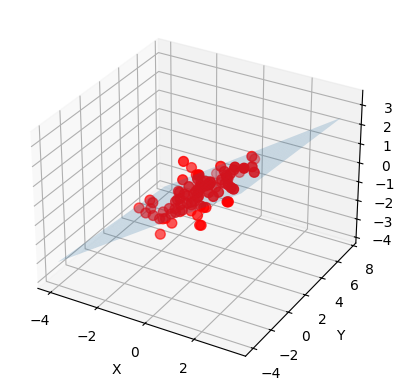

In [1]:
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# some 3-dim points
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.2,0.8], [-0.2,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 90)
data[:,1] = data[:,1]**2

# regular grid covering the domain of the data
r=4
X,Y = np.meshgrid(np.arange(-r, r, 0.5), np.arange(-r, r*2, 0.5))
XX = X.flatten()
YY = Y.flatten()

order = 1  # 1: linear, 2: quadratic, 3: cubic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

elif order == 3:
    # best-fit cubic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2, data[:,:2]**3]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2, XX**3, YY**3], C).reshape(X.shape)


# plot points and fitted surface
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')
plt.show()

In [72]:
print("Slope in x direction: ", C[0])
print("Slope in y direction: ", C[1])

Slope in x direction:  0.9017939893690625
Slope in y direction:  0.08738977559304625


In [35]:
# Project the data onto the XY plane
data_2d = data[:, :2]

# Create a matrix A where the first column is the x-coordinates of the data points and the second column is all ones
A = np.c_[data_2d[:, 0], np.ones(data_2d.shape[0])]

# Solve the equation Ax = b in the least squares sense, where b is the y-coordinates of the data points
C, _, _, _ = scipy.linalg.lstsq(A, data_2d[:, 1])

# The slope of the fitted line is C[0], and the y-intercept is C[1]
print("Slope: ", C[0])
print("Intercept: ", C[1])

Slope:  -0.5628808772876751
Intercept:  1.4821662909615816


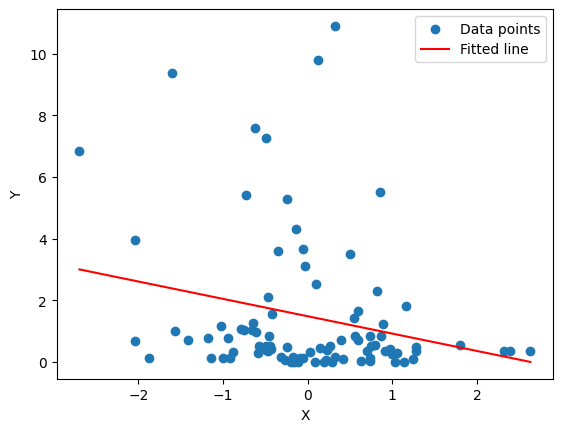

In [36]:
import matplotlib.pyplot as plt

# Generate x values
x_values = np.linspace(min(data_2d[:, 0]), max(data_2d[:, 0]), num=100)

# Compute the corresponding y values
y_values = C[0] * x_values + C[1]

# Plot the data points
plt.scatter(data_2d[:, 0], data_2d[:, 1], label='Data points')

# Plot the fitted line
plt.plot(x_values, y_values, color='red', label='Fitted line')

# Add labels and a legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()

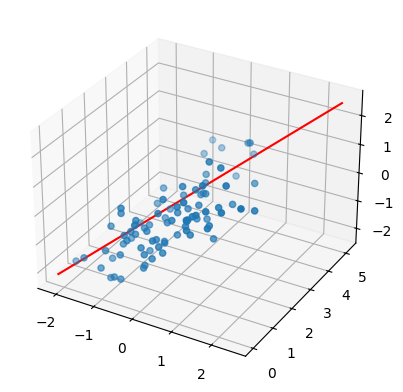

In [73]:
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a matrix A where the first two columns are the x and y coordinates of the data points, and the third column is all ones
A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]

# Solve the equation Ax = b in the least squares sense, where b is the z-coordinates of the data points
C, _, _, _ = scipy.linalg.lstsq(A, data[:, 2])

# Generate a range of x values
x_values = np.linspace(min(data[:, 0]), max(data[:, 0]), num=100)

# Generate a range of y values
y_values = np.linspace(min(data[:, 1]), max(data[:, 1]), num=100)

# Compute the corresponding z values
z_values = C[0] * x_values + C[1] * y_values + C[2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(data[:, 0], data[:, 1], data[:, 2])

# Plot the fitted line
ax.plot(x_values, y_values, z_values, color='red')

# Show the plot
plt.show()

In [74]:
print("Direction vector: ", [C[0], C[1], 1])

Direction vector:  [0.9017939893690625, 0.08738977559304625, 1]


In [75]:
slope_magnitude = np.sqrt(C[0]**2 + C[1]**2 + 1**2)
print("Absolute value of slope: ", slope_magnitude)

Absolute value of slope:  1.3493959286067125


In [76]:
# Calculate the magnitude of the direction vector
magnitude = np.sqrt(C[0]**2 + C[1]**2 + 1**2)

# Calculate the z-component of the direction vector
z_component = 1

# Calculate the angle in radians
theta_rad = np.arccos(z_component / magnitude)

# Convert the angle to degrees
theta_deg = np.degrees(theta_rad)

print("Angle with horizontal plane: ", theta_deg, "degrees")

Angle with horizontal plane:  42.177157129515436 degrees


In [25]:
# Pick two points on the line
t1 = 0  # parameter value for the first point
t2 = 1 # parameter value for the second point

x1, y1, z1 = t1, t1, C[0]*t1 + C[1]*t1 + C[2]
x2, y2, z2 = t2, t2, C[0]*t2 + C[1]*t2 + C[2]

# Calculate the rise (change in z)
rise = z2 - z1

# Calculate the run (distance in the xy-plane)
run = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

# Calculate the slope
slope = rise / run

print("Slope: ", slope)

# Calculate the angle in radians
angle_rad = np.arctan(slope)

# Convert the angle to degrees
angle_deg = np.rad2deg(angle_rad)

#angle_deg = np.degrees(angle_rad)

print("Angle: ", angle_deg, "degrees")

Slope:  0.4798854111319861
Angle:  25.63566954991755 degrees


In [26]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os

root_dir = Path(os.getcwd()).parent.parent
print(root_dir)

pcd1 = np.loadtxt(Path(root_dir) / "data/05_segmentation/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01_Labeled_Segmentation.txt", delimiter=' ')

/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation


In [28]:
points_left_side = pcd1[1:10, [0,1,2]]
points_right_side = pcd1[11:21, [0,1,2]]

In [29]:
# Merge the left and right side points into a single array
neighborhood_points = np.concatenate((points_left_side, points_right_side))
X = neighborhood_points[:, 0]
Y = neighborhood_points[:, 1]

# Calculate the least-squares solution
A = np.column_stack((X, Y, np.ones(neighborhood_points.shape[0])))
B = neighborhood_points[:, 2]

In [38]:
print(B.shape)

(19,)


In [8]:
import numpy as np

# Your array
arr = np.array([1, 1, 1, 2, 2, 2, 3, 3, 3])

# Calculate the difference between consecutive elements
diff = np.diff(arr)

# Find the indices where the difference is greater than 0
indices = np.where(diff > 0)[0] + 1

# add the first index
indices = np.insert(indices, 0, 0)

# add the last index
indices = np.append(indices, arr.shape[0])

print("Indices where values increase: ", indices)

Indices where values increase:  [0 3 6 9]


In [12]:
for i in range(indices.shape[0]-1):
    print(arr[indices[i]:indices[i+1]])
    print(np.arange(indices[i], indices[i+1]))

[1 1 1]
[0 1 2]
[2 2 2]
[3 4 5]
[3 3 3]
[6 7 8]


In [11]:
np.unique(arr, return_counts=True)

(array([1, 2, 3]), array([3, 3, 3]))

# 04.02.2024

**Relocate origin**

In [1]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os
import matplotlib.cm as cm

root_dir = Path(os.getcwd()).parent.parent
print(root_dir)

pcd = np.loadtxt(Path(root_dir) / "data/03_labeled/SiteA_Scans_Global_I_RGB_RHV/SiteA_RHV_01_Labeled.txt", delimiter=' ')

/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation


In [15]:
mean_pos = np.mean(pcd[:,:3], axis=0)
mean_pos[2] += 30
pcd_xyz_centered = pcd[:,:3] - mean_pos
normals_xyz = pcd_xyz_centered / np.linalg.norm(pcd_xyz_centered, axis=1, keepdims=True)

rho = np.sqrt(pcd_xyz_centered[:,0]**2 + pcd_xyz_centered[:,1]**2 + pcd_xyz_centered[:,2]**2)

# Normalize rho to range [0, 1]
rho_normalized = (rho - np.percentile(rho, 2)) / (np.percentile(rho, 98) - np.percentile(rho, 2))

# Map normalized rho to colors from the Viridis colormap
colors = cm.inferno(rho_normalized)

In [4]:
xyz = pcd_xyz_centered
colors = pcd[:, [4, 5, 6]] / 255.
#colors = colors[:, :3]
normals = -normals_xyz

thinning_factor = 10

pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(xyz[::thinning_factor])  
pcd_o3d.colors = o3d.utility.Vector3dVector(colors[::thinning_factor])
pcd_o3d.normals = o3d.utility.Vector3dVector(normals[::thinning_factor] / 10)

# create second pcd with mean_pos
pcd_o3d_mean = o3d.geometry.PointCloud()
pcd_o3d_mean.points = o3d.utility.Vector3dVector(np.expand_dims(np.array([0,0,0]), axis=0))
pcd_o3d_mean.colors = o3d.utility.Vector3dVector(np.expand_dims(np.array([1, 0, 0]), axis=0))

o3d.visualization.draw_geometries([pcd_o3d,pcd_o3d_mean], 
                                  width=1400, 
                                  height=1000,
                                  front = [ -0.81965113531166078, 0.45550361699470804, 0.34740246298356042 ],
			                      lookat = [ -2.800280852732973, 1.7267435951215568, -0.92853874114197343 ],
			                      up = [ 0.32009006313284094, -0.13877454945208628, 0.93716806171998024 ],
			                      zoom = 0.032449340820312499)

#o3d.visualization.draw_geometries([pcd_o3d_mean])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# 06.02.2024

In [1]:
from scipy.stats import skew
import numpy as np

In [13]:
# sample a right skewed distribution
data = np.random.exponential(scale=1, size=1000)

# calculate the skewness
skewness1 = skew(data)

print(skewness1)

1.7696192565357511


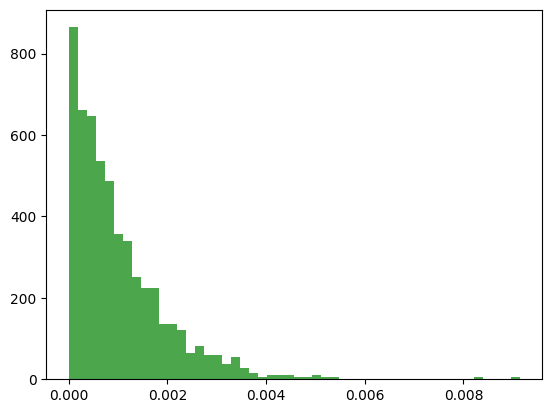

In [11]:
# plot data as histogram
import matplotlib.pyplot as plt

plt.hist(data, bins=50, density=True, alpha=0.7, color='g')
plt.show()

In [14]:
# sample a right skewed distribution
data = np.random.exponential(scale=1, size=1000)

# Calculate mean and standard deviation
mean = np.mean(data)
std_dev = np.std(data)

# Calculate skewness
skewness2 = np.mean(((data - mean) / std_dev) ** 3)

print(f'Skewness: {skewness2}')

Skewness: 1.7696192565357503


In [15]:
skewness1 - skewness2

8.881784197001252e-16

# 07.02.2024

In [1]:
import numpy as np
from typing import List, Dict, Tuple

In [2]:
pcd_cols = {
  "x": 0,
  "y": 1,
  "z": 2,
  "intensity": 3,
  "red": 4,
  "green": 5,
  "blue": 6,
  "rho": 7,
  "horiz_angle": 8,
  "vert_angle": 9,
  "point_counter": 10,
  "label": 11,
  "expected_value": 12,
  "expected_value_std": 13,
  "scanline_id": 14,
  "rho_diff": 15,
  "slope": 16,
  "curvature": 17,
  "roughness": 18,
  "segment_ids": 19,
  "nx_xyz": 20,
  "ny_xyz": 21,
  "nz_xyz": 22,
  "nx": 23,
  "ny": 24,
  "nz": 25
}

pcd_col_fmt = {
  "x": "%1.4f",
  "y": "%1.4f",
  "z": "%1.4f",
  "intensity": "%1.6f",
  "red": "%u",
  "green": "%u",
  "blue": "%u",
  "rho": "%1.4f",
  "horiz_angle": "%1.4f",
  "vert_angle": "%1.4f",
  "point_counter": "%u",
  "label": "%u",
  "expected_value": "%1.4f",
  "expected_value_std": "%1.4f",
  "scanline_id": "%u",
  "rho_diff": "%1.4f",
  "slope": "%1.4f",
  "curvature": "%1.4f",
  "roughness": "%1.6f",
  "segment_ids": "%1.4f",
  "nx_xyz": "%1.4f",
  "ny_xyz": "%1.4f",
  "nz_xyz": "%1.4f",
  "nx": "%1.4f",
  "ny": "%1.4f",
  "nz": "%1.4f"
}

statistics = ["mean","var","std","median","perc2nd","perc98th","skewness"]
attributes= ["intensity","red","green","blue","rho","slope","curvature","roughness","nx_xyz","ny_xyz","nz_xyz"]

In [4]:
def prepare_attributes_and_format(attributes: List[str], 
                                  statistics: List[str], 
                                  xyz_attributes: List[str], 
                                  pcd_cols: Dict[str, int],
                                  pcd_col_fmt: Dict[str, str]) -> Tuple[str, str, str, List[int], List[str]]:
    def get_column_indices(attributes: List[str], pcd_col: Dict[str, int]) -> List[int]:
        try:
            column_indices = [pcd_col[attribute.lower()] for attribute in attributes]
            column_fmt = [pcd_col_fmt[attribute.lower()] for attribute in attributes]
            return column_indices, column_fmt
        except KeyError as e:
            raise KeyError(f"The attribute '{e.args[0]}' is not found in the dictionary. Please check the attribute names.")

    # fmt for scanline extraction
    fmt_sce = " ".join(fmt for fmt in list(pcd_col_fmt.values())[:15])
    
    # fmt for scanline segmentation
    fmt_scs = " ".join(fmt for fmt in list(pcd_col_fmt.values()))
    
    # fmt scanline subsampling
    column_indices, column_fmt = get_column_indices(attributes, pcd_cols)
    fmt_scsb = " ".join(fmt for fmt in column_fmt for _ in range(7)) + " %u" #7 because of the number of statistics
    fmt_scsb = " ".join(["%1.4f"] * len(xyz_attributes)) + " " + fmt_scsb

    attribute_statistics = [f"{attribute}_{statistic}" for attribute in attributes for statistic in statistics]
    attribute_statistics = xyz_attributes + attribute_statistics + ["label"]

    return fmt_sce, fmt_scs, fmt_scsb, column_indices, attribute_statistics

In [17]:
xyz_attributes = ["x_median_nn", "y_median_nn", "z_median_nn", "x_perc2nd_nn", "y_perc2nd_nn", "z_perc2nd_nn", "x_perc98th_nn", "y_perc98th_nn", "z_perc98th_nn"] 
fmt_sce, fmt_scs, fmt_scsb, column_indices, attribute_statistics = prepare_attributes_and_format(attributes, statistics, xyz_attributes, pcd_cols, pcd_col_fmt)

In [ ]:
def prepare_attributes_and_format(attributes: List[str], 
                                  statistics: List[str], 
                                  xyz_attributes: List[str], 
                                  pcd_col: Dict[str, int],
                                  pcd_col_fmt: Dict[str, str]) -> Tuple[str, str, str, List[int], List[str]]:
    
    def get_column_indices(attributes: List[str], 
                           pcd_col: Dict[str, int], 
                           pcd_col_fmt: Dict[str, str]) -> Tuple(List[int], str):
        try:
            column_indices = [pcd_col[attribute.lower()] for attribute in attributes]
            column_fmt = [pcd_col_fmt[attribute.lower()] for attribute in attributes]
            return column_indices, column_fmt
        except KeyError as e:
            raise KeyError(f"The attribute '{e.args[0]}' is not found in the dictionary. Please check the attribute names.")

    # fmt scanline extraction
    fmt_sce = " ".join(fmt for fmt in list(pcd_col_fmt.values())[:15])
    
    # fmt scanline segmentation
    fmt_scs = " ".join(fmt for fmt in list(pcd_col_fmt.values()))
    
    # fmt scanline subsampling
    column_indices, column_fmt = get_column_indices(attributes, pcd_col)
    fmt_scsb = " ".join(fmt for fmt in column_fmt for _ in range(7)) + " %u" #7 because of the number of statistics
    fmt_scsb = " ".join(["%1.4f"] * len(xyz_attributes)) + " " + fmt_scsb

    attribute_statistics = [f"{attribute}_{statistic}" for attribute in attributes for statistic in statistics]
    attribute_statistics = xyz_attributes + attribute_statistics + ["label"]

    return fmt_sce, fmt_scs, fmt_scsb, column_indices, attribute_statistics

In [13]:
fmt_scs

'%1.4f %1.4f %1.4f %1.6f %u %u %u %1.4f %1.4f %1.4f %u %u %1.4f %1.4f %u %1.4f %1.4f %1.4f %1.6f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f'

In [15]:
# remove the last 3 elements from the string
fmt_scs = fmt_scs.rsplit(' ', 3)[0]


In [19]:
fmt_scs

'%1.4f %1.4f %1.4f %1.6f %u %u %u %1.4f %1.4f %1.4f %u %u %1.4f %1.4f %u %1.4f %1.4f %1.4f %1.6f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f %1.4f'

In [18]:
fmt_scs.rsplit(' ', 3)

['%1.4f %1.4f %1.4f %1.6f %u %u %u %1.4f %1.4f %1.4f %u %u %1.4f %1.4f %u %1.4f %1.4f %1.4f %1.6f %1.4f %1.4f %1.4f %1.4f',
 '%1.4f',
 '%1.4f',
 '%1.4f']

In [21]:
# count the number of "%" in fmt_scs
fmt_scsb.count("%")

87

# 08.02.2024

In [1]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt

root_dir = Path(os.getcwd()).parent.parent
print(root_dir)

pcd = np.loadtxt(Path(root_dir) / "data/03_labeled/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled.txt", delimiter=' ')

/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation


In [2]:
origin = np.array([362470.657, 5808491.421, 74.574])

In [3]:
x = pcd[:, 0].copy()
y = pcd[:, 1].copy()
z = pcd[:, 2].copy()

In [35]:
# Extract the x, y, z coordinates from the scanline (numba does not support indexing with multiple columns)
x = pcd[:, 0].copy()
y = pcd[:, 1].copy()
z = pcd[:, 2].copy()

x -= np.median(x)
y -= np.median(y-5)
z -= np.median(z)

rho = np.sqrt((x+1)**2 + (y+1)**2 + z**2)
theta = ( 180 * np.arccos(z / rho) ) / np.pi
phi = ( 180 * np.arctan2((y), (x)) / np.pi )

# phi_below_zero_idx = np.where(phi < 0)[0]
# phi = np.where(phi < 0, phi + 180, phi)
# theta[phi_below_zero_idx] *= -1

#phi = np.where(phi < 0, phi + 360, phi)

In [2]:
# ZF spherical coordinates trnasformation
rho_zf = pcd[:,7].copy()
phi_zf = pcd[:, 8].copy()
theta_zf = pcd[:,9].copy()

#############################################
# this works (but theta is high at low phi values)
# theta_zf_a180_idx = np.where(theta_zf > 180)[0]
# theta_zf[theta_zf_a180_idx] *= -1
# theta_zf[theta_zf_a180_idx] += 360
# phi_zf[theta_zf_a180_idx] -= 180


#############################################
# Flip the theta values such that they start low when phi is at its lowest.
theta_zf = 360 - theta_zf
theta_zf_a180_idx = np.where(theta_zf > 180)[0]

# For these indices, multiply the theta values by -1.
# Flip the direction of the theta values that are greater than 180.
theta_zf[theta_zf_a180_idx] *= -1

# Add 360 to these theta values to shift these theta values back into the positive range 
# after they were flipped in the previous step
theta_zf[theta_zf_a180_idx] += 360

# Subtract 180 from the corresponding phi values to adjust the phi values 
# corresponding to the theta values that were greater than 180.
phi_zf[theta_zf_a180_idx] -= 180

In [37]:
# get first ten values of phi
phi_sort_idx = np.argsort(phi)
phi_ex = theta[phi_sort_idx][:5000]
range_phi = np.arange(0, phi_ex.shape[0])

# start = 50000*120

# phi_sort_idx = np.argsort(phi_zf)
# theta_ex = theta_zf[phi_sort_idx][start:start+20000]
# range_phi = np.arange(0, theta_ex.shape[0])

In [34]:
theta_ex_diff = np.abs(np.diff(theta_ex))
# append the last value
theta_ex_diff = np.append(theta_ex_diff, theta_ex_diff[-1])

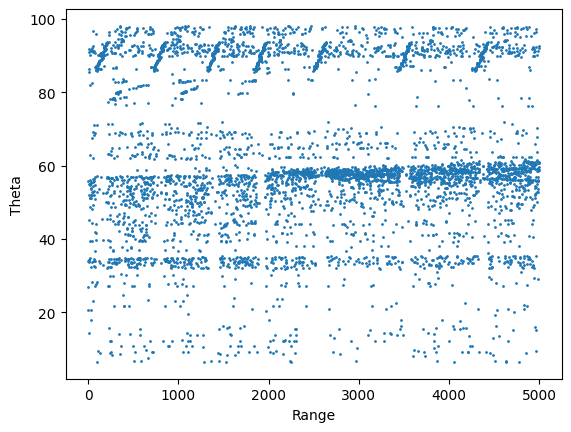

In [38]:
# plot phi against range
plt.scatter(range_phi, phi_ex, s=1)
plt.xlabel('Range')
plt.ylabel('Theta')
plt.show()

In [43]:
OWN = True
ZF = False
RGB = True

thinning_factor = 10

if OWN:
    points = np.c_[rho, theta, phi]
    
    phi_normalized = (phi - np.min(phi)) / (np.max(phi) - np.min(phi))
    colors = cm.viridis(phi_normalized)
    mask1 = np.abs(phi) <= 5
    mask2 = theta <= 10
    colors[mask1] = [1, 0, 0, 1]
    # colors[mask2] = [0, 0, 1, 1]

    pcd_o3d = o3d.geometry.PointCloud()
    pcd_o3d.points = o3d.utility.Vector3dVector(points[::thinning_factor])
    if RGB:
        pcd_o3d.colors = o3d.utility.Vector3dVector(pcd[:, 4:7][::thinning_factor] / 255.)
    else:
        pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:,:3][::thinning_factor])
else:
    points = np.c_[phi_zf, theta_zf, rho_zf]
    
    phi_normalized = (phi_zf - np.min(phi_zf)) / (np.max(phi_zf) - np.min(phi_zf))
    colors = cm.viridis(phi_normalized)
    mask1 = np.abs(phi_zf) <= 5
    mask2 = np.abs(theta_zf) <= 20
    colors[mask1] = [1, 0, 0, 1]
    colors[mask2] = [0, 0, 1, 1]
    
    pcd_o3d = o3d.geometry.PointCloud()
    pcd_o3d.points = o3d.utility.Vector3dVector(points[::thinning_factor])
    if RGB:
        pcd_o3d.colors = o3d.utility.Vector3dVector(pcd[:, 4:7][::thinning_factor] / 255.)
    else:
        pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:,:3][::thinning_factor])
    
    
o3d.visualization.draw_geometries([pcd_o3d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


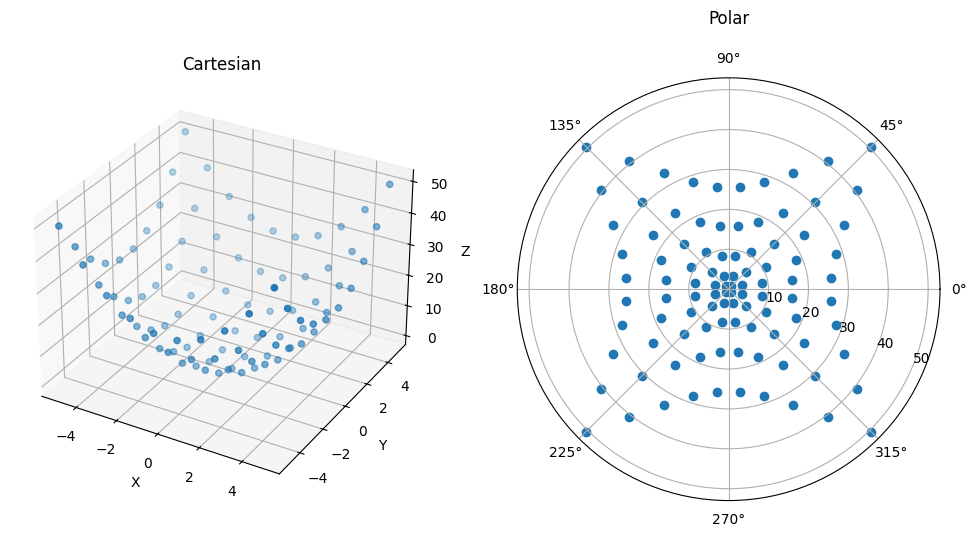

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate 100 points in a quadratic shape
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2

# Flatten the arrays and pair the coordinates
cartesian_points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))

# Convert to polar coordinates
polar_points = []
for point in cartesian_points:
    X, Y, Z = point
    distance = np.sqrt(X**2 + Y**2 + Z**2)
    zenith = np.arccos(Z / distance) * (180 / np.pi)
    azimuth = np.arctan2(Y, X) * (180 / np.pi)
    polar_points.append((distance, zenith, azimuth))
polar_points = np.array(polar_points)

# Plot the points in Cartesian coordinates
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(cartesian_points[:, 0], cartesian_points[:, 1], cartesian_points[:, 2])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Cartesian')

# Plot the points in polar coordinates
ax2 = fig.add_subplot(122, projection='polar')
ax2.scatter(np.deg2rad(polar_points[:, 2]), polar_points[:, 0])
ax2.set_rlabel_position(-22.5)
ax2.set_title('Polar', pad=20)

plt.show()

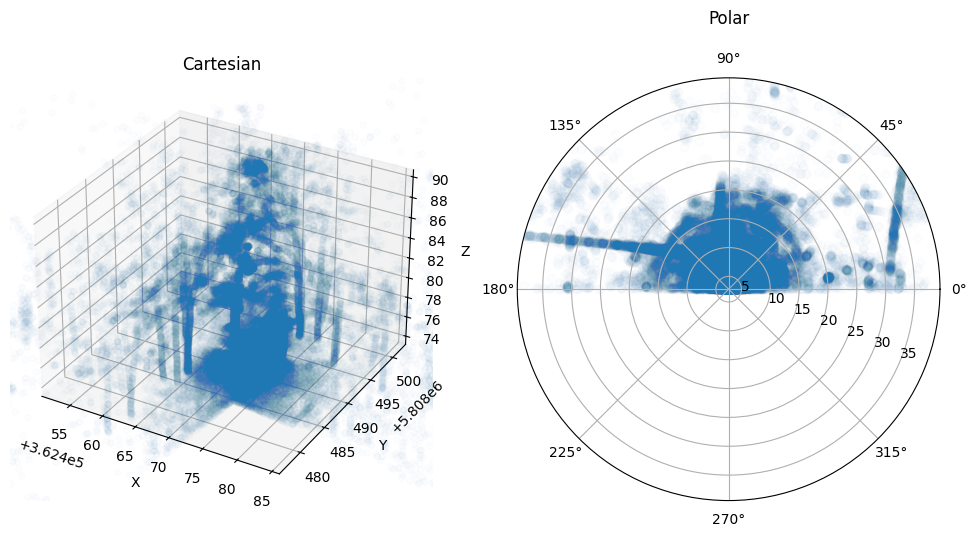

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

thinning_factor = 50

# Plot the points in Cartesian coordinates
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pcd[:, 0][::thinning_factor], pcd[:, 1][::thinning_factor], pcd[:, 2][::thinning_factor], alpha=0.01)
ax1.set_xlim(np.percentile(pcd[:, 0][::thinning_factor],2), np.percentile(pcd[:, 0][::thinning_factor],98))
ax1.set_ylim(np.percentile(pcd[:, 1][::thinning_factor],2), np.percentile(pcd[:, 1][::thinning_factor],98))
ax1.set_zlim(np.percentile(pcd[:, 2][::thinning_factor],2), np.percentile(pcd[:, 2][::thinning_factor],98))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Cartesian')

# change the perspective
#ax1.view_init(0, 0)

# Plot the points in polar coordinates
ax2 = fig.add_subplot(122, projection='polar')
ax2.scatter(np.deg2rad(phi[::thinning_factor]), rho[::thinning_factor], alpha=0.01)
ax2.set_rlim(np.percentile(rho[::thinning_factor],1), np.percentile(rho[::thinning_factor],99))

# ax2.scatter(np.deg2rad(pcd[:,8][::thinning_factor]), pcd[:,7][::thinning_factor], alpha=0.01)
# ax2.set_rlim(np.percentile(pcd[:,7][::thinning_factor],1), np.percentile(pcd[:,7][::thinning_factor],99))

ax2.set_rlabel_position(-22.5)
ax2.set_title('Polar', pad=20)

plt.show()

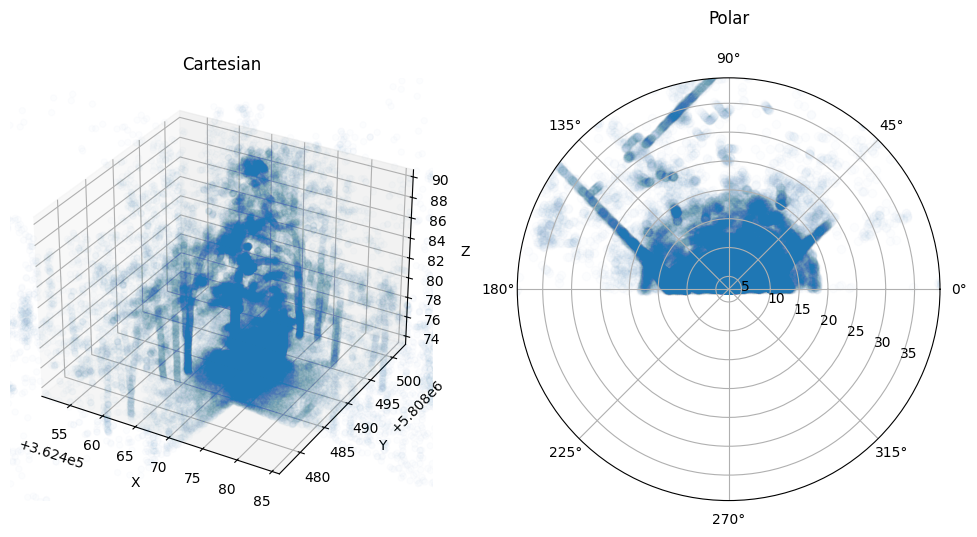

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

thinning_factor = 50

# Plot the points in Cartesian coordinates
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pcd[:, 0][::thinning_factor], pcd[:, 1][::thinning_factor], pcd[:, 2][::thinning_factor], alpha=0.01)
ax1.set_xlim(np.percentile(pcd[:, 0][::thinning_factor],2), np.percentile(pcd[:, 0][::thinning_factor],98))
ax1.set_ylim(np.percentile(pcd[:, 1][::thinning_factor],2), np.percentile(pcd[:, 1][::thinning_factor],98))
ax1.set_zlim(np.percentile(pcd[:, 2][::thinning_factor],2), np.percentile(pcd[:, 2][::thinning_factor],98))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Cartesian')

# change the perspective
#ax1.view_init(0, 0)

# Plot the points in polar coordinates
ax2 = fig.add_subplot(122, projection='polar')
# ax2.scatter(np.deg2rad(phi[::thinning_factor]), rho[::thinning_factor], alpha=0.01)
# # set the limit
# ax2.set_rlim(np.percentile(rho[::thinning_factor],1), np.percentile(rho[::thinning_factor],99))

ax2.scatter(np.deg2rad(pcd[:,8][::thinning_factor]), pcd[:,7][::thinning_factor], alpha=0.01)
ax2.set_rlim(np.percentile(rho[::thinning_factor],1), np.percentile(rho[::thinning_factor],99))

ax2.set_rlabel_position(-22.5)
ax2.set_title('Polar', pad=20)

plt.show()

# 15.02.2024

## Curvature calculation on 3D point clouds

Workflow: 

- Center the point cloud 
- Get the neighborhood of a point --> KdTree
- Get the covariance matrix evalue, evector = (np.linalg.eigh(np.cov(q.T)))
- Curvature: np.min(evalue)/ np.sum(evalue) --> Smallest eigenvalue divided by the sum of the eigenvalues

In [15]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

root_dir = Path(os.getcwd()).parent.parent
print(root_dir)

pcd = np.loadtxt(Path(root_dir) / "data/03_labeled/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled.txt", delimiter=' ')
pcd = pcd[::40]

/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation


In [3]:
@njit(parallel=True)
def compute_curvature(pcd_centered, radius):
    
    curvature = np.zeros(pcd_centered.shape[0])
    
    for i in prange(pcd_centered.shape[0]):
        # Select the a point from the point cloud
        pt = pcd_centered[i,:3]
        dist_pt = np.zeros(pcd_centered.shape[0])
        
        # Compute the distance between the point and all other points in the point cloud
        for j in prange(pcd_centered.shape[0]):
            dist_pt[j] = np.sqrt(np.sum((pcd_centered[j,:3] - pt)**2))
            
        # Select the points within the given radius
        pt_nbh = pcd_centered[dist_pt < radius]
        
        # Compute the covariance matrix of the selected points
        eigenvalues, _ = np.linalg.eigh(np.cov(pt_nbh.T))
        
        # Compute the curvature as the ratio of the smallest eigenvalue to the sum of all eigenvalues
        curvature[i] = np.min(eigenvalues) / np.sum(eigenvalues)
        
    return curvature

In [4]:
curvature = compute_curvature(pcd_centered, 0.25)

In [18]:
from numba import jit

In [44]:
@jit(nopython=True)
def compute_curvature(pcd_centered: np.ndarray, 
                      radius: float) -> np.ndarray:
    
    curvature = np.zeros(pcd_centered.shape[0])
    
    print(curvature.shape)
    
    for i in range(pcd_centered.shape[0]):
        #print(i)
        # Select the a point from the point cloud
        pt = pcd_centered[i,:3]
        dist_pt = np.zeros(pcd_centered.shape[0])
        
        # Compute the distance between the point and all other points in the point cloud
        for j in range(pcd_centered.shape[0]):
            dist_pt[j] = np.sqrt(np.sum((pcd_centered[j,:3] - pt)**2))
            
        # Select the points within the given radius
        pt_nbh = pcd_centered[dist_pt < radius]
        
        # Compute the covariance matrix of the selected points
        if pt_nbh.shape[0] > 1:
            eigenvalues, _ = np.linalg.eigh(np.cov(pt_nbh.T))
            curvature[i] = np.min(eigenvalues) / np.sum(eigenvalues)
        else:
            curvature[i] = 0 
        
        # Compute the curvature as the ratio of the smallest eigenvalue to the sum of all eigenvalues
        curvature[i] = np.min(eigenvalues) / np.sum(eigenvalues)
        
    return curvature

In [16]:
# pcd centered
pcd_centered = pcd[:,:3] - np.mean(pcd[:,:3], axis=0)

In [45]:
curvature = compute_curvature(pcd_centered[::20], 0.25)

(8425,)


In [49]:
pt1 = pcd_centered[0,:3]
sub = pcd_centered[0:10] - pt1

np.linalg.norm(sub, axis = 1)

array([0.        , 0.00447772, 0.00661665, 0.00998248, 0.01353551,
       0.01958903, 0.07740633, 0.08012528, 0.08265597, 0.08510376])

In [52]:
np.sqrt(np.sum(sub**2, axis=1))

array([0.        , 0.00447772, 0.00661665, 0.00998248, 0.01353551,
       0.01958903, 0.07740633, 0.08012528, 0.08265597, 0.08510376])

# 16.02.2024

In [80]:
import numpy as np 

pcd = np.loadtxt("/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/data/05_segmentation/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled_Segmentation.txt", delimiter=' ')

In [54]:
pcd.shape

(6739446, 23)

In [83]:
pcd[:, 16].mean()

-0.4040445048747336

In [78]:
scanline = pcd[pcd[:, 14] == 1000]

X = np.sqrt(scanline[:, 0]**2 + scanline[:, 1]**2)
B = scanline[:, 2]

# Create a matrix A with rho-values and a column of ones
A = np.column_stack((X, np.ones(scanline.shape[0])))

# Solve the linear system Ax = B using least squares method
lstsq_solution, _, _, _ = np.linalg.lstsq(A, B)

# Calculate the slope in degrees
slope_deg = np.rad2deg(np.arctan(lstsq_solution[0]))

/var/folders/j6/k2j8s_l175g46msm1l9hzz780000gn/T/ipykernel_8972/2704981013.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  lstsq_solution, _, _, _ = np.linalg.lstsq(A, B)


In [79]:
slope_deg

-26.29446357313257

# 18.02.2024

## PCD classification implementation

In [1]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import joblib 
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

root_dir = Path(os.getcwd()).parent.parent
pcd_path = Path(root_dir) / "data/06_subsampling/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled_Subsampling.txt"
attribute_statistics_path = Path(root_dir) / "data/06_subsampling/attribute_statistics/attribute_statistics.pkl"
rf_model_path = Path(root_dir) / "data/models/random_forest_98features.joblib"
results_metrics_path = Path(root_dir) / "data/07_classification/results_metrics"
results_confmat_path = Path(root_dir) / "data/07_classification/results_confusion_matrix"

output_dir = Path(root_dir) / "data/07_classification"

pcd_subsampled = np.loadtxt(pcd_path, delimiter=' ')

In [2]:
def evaluate_classifier(rf_model, features, labels):
    predicted_labels = rf_model.predict(features)
    accuracy = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels, average='weighted')
    recall = recall_score(labels, predicted_labels, average='weighted')
    f1 = f1_score(labels, predicted_labels, average='weighted')
    cnf_matrix = confusion_matrix(labels, predicted_labels)
    return predicted_labels, accuracy, precision, recall, f1, cnf_matrix

In [41]:
with open(attribute_statistics_path, 'rb') as f:
    stats = pickle.load(f)
        
# Load and prepare data
data = pd.read_csv(pcd_path, delimiter=' ', header=None, names=stats)
features = data.iloc[:, 9:-2].values

In [43]:
type(features)

numpy.ndarray

In [8]:
def classify_pcd(pcd_filepath: str, 
                 out_dir: str, 
                 stats_file: str, 
                 results_file: str, 
                 matrix_file: str, 
                 model_file: str):
    # Load attribute statistics and model
    with open(stats_file, 'rb') as f:
        stats = pickle.load(f)
    model = joblib.load(model_file)
        
    # Load and prepare data
    data = pd.read_csv(pcd_filepath, delimiter=' ', header=None, names=stats)
    features = data.iloc[:, 9:-2].values # ignore the first 9 columns (position) and the last 2 columns (segment ids, labels)
    labels = data.iloc[:, -1].values
    
    # Evaluate classifier
    predicted_labels, acc, prec, rec, f1, cnf_matrix = evaluate_classifier(model, features, labels)
    
    # Add predictions to data and save
    data['predicted'] = predicted_labels
    classified_file = Path(out_dir) / f"{Path(pcd_filepath).stem}_classified.txt"
    data.to_csv(classified_file, sep=' ', header=False, index=False)
    
    # Prepare results paths
    results_path = Path(results_file) / f"{Path(pcd_filepath).stem}.csv"
    matrix_path = Path(matrix_file) / Path(pcd_filepath).name
    
    # Write results and confusion matrix
    with results_path.open('a') as f:
        if results_path.stat().st_size == 0:
            f.write("accuracy,precision,recall,f1,filename\n")
        f.write(f"{acc},{prec},{rec},{f1},{Path(pcd_filepath).name}\n")
    np.savetxt(matrix_path, cnf_matrix, delimiter=',', fmt='%u')

In [9]:
classify_pcd(pcd_filepath=pcd_path,
             out_dir=output_dir,
             stats_file=attribute_statistics_path,
             results_file=results_metrics_path,
             matrix_file=results_confmat_path,
             model_file=rf_model_path)

## Write the classification results back into the original point cloud

In [10]:
import numpy as np
import open3d as o3d
from pathlib import Path
from numba import njit, prange
import os
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import joblib 
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numba

root_dir = Path(os.getcwd()).parent.parent
pcd_path = Path(root_dir) / "data/06_subsampling/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled_Subsampling.txt"
attribute_statistics_path = Path(root_dir) / "data/06_subsampling/attribute_statistics/attribute_statistics.pkl"
rf_model_path = Path(root_dir) / "data/models/random_forest_98features.joblib"
results_metrics_path = Path(root_dir) / "data/07_classification/results_metrics"
results_confmat_path = Path(root_dir) / "data/07_classification/results_confusion_matrix"

output_dir = Path(root_dir) / "data/07_classification"

In [4]:
classified_subsampled_pcd = np.loadtxt(output_dir / "SiteD_RHV_01_Labeled_Subsampling_classified.txt", delimiter=' ')
fr_pcd = np.loadtxt(root_dir / "data/05_segmentation/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled_Segmentation.txt", delimiter=' ')

In [5]:
id_diff = np.diff(fr_pcd[:, 19])
segmentss = np.where(id_diff != 0)[0]
_, counts = np.unique(fr_pcd[:, 19], return_counts=True)
indices_per_class = np.split(np.arange(0, fr_pcd[:, 19].shape[0]), np.cumsum(counts[:-1]))

In [29]:
@njit(parallel=True)
def assign_labels(fr_pcd, indices_per_class, classified_subsampled_pcd):
    labels = np.zeros(fr_pcd.shape[0])

    for i in prange(classified_subsampled_pcd.shape[0]):
        segment_indices = indices_per_class[i]
        predicted_labels = classified_subsampled_pcd[i, -1]
    
        labels[segment_indices] = predicted_labels

    return labels

In [31]:
labelss = assign_labels(fr_pcd, numba.typed.List(indices_per_class), classified_subsampled_pcd)

In [1]:
from pathlib import Path
import os 

In [5]:
root_dirr = Path(os.getcwd()).parent.parent

testung = "bli/bla/blub"

ending = "data/03_labeled/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled.txt"

In [2]:
dirr = Path("data/03_labeled/SiteD_Scans_Global_I_RGB_RHV/SiteD_RHV_01_Labeled.txt")

In [5]:
dirr.stem

'SiteD_RHV_01_Labeled'

In [9]:
Path(root_dirr) / testung / (str(Path(ending).stem) + "_metrics.csv")

PosixPath('/Users/luiskremer/Code/Uni/Code_Master_RSIV/019_scanline_segmentation/bli/bla/blub/SiteD_RHV_01_Labeled_metrics.csv')